<a href="https://colab.research.google.com/github/orangegreen212/Bike_share_demand_project/blob/main/PCA_%2BK_Mean_Bike_Demand.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bike Demand Analysis and Forecasting using Clustering**


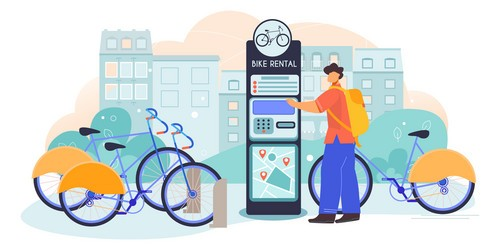

**Project Goal:**

 To develop models for forecasting bicycle rental demand for the next 7 days and to test the hypothesis that pre-clustering the data and subsequently training models on each cluster improves prediction accuracy compared to using a single global model.

**Objectives:**
1.  Data preparation and exploratory data analysis.
2.  Data clustering to identify hidden user segments or demand patterns.
3.  Development and training of various forecasting models:
    *   Simple Baseline model (average by day of the week).
    *   SARIMA.
    *   Prophet with hyperparameter tuning via Optuna.
    *   LightGBM.
    *   XGBoost.
4.  Training models on both individual clusters and the overall (global) dataset.
5.  Comparison of model accuracy (using MAPE metric) between the cluster-based and global approaches.
6.  Visualization of results and formulation of conclusions.

**Data Used:** Bicycle rental demand data (presumably the Bike Sharing dataset).
**Forecast Horizon:** 7 days.
The dataset was taken from this site [Kaggle](https://www.kaggle.com/competitions/bike-sharing-demand/data)

Dataset Description

**datetime** - hourly date + timestamp  
**season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter

**holiday** - whether the day is considered a holiday

**workingday** - whether the day is neither a weekend nor holiday

**weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

**temp** - temperature in Celsius

**atemp** - "feels like" temperature in Celsius

**humidity** - relative humidity

**windspeed** - wind speed

**casual** - number of non-registered user rentals initiated

**registered** - number of registered user rentals initiated

**count** - number of total rentals

# 0. Environment Setup: Installing and Importing Libraries

Before starting the analysis, we ensure all necessary libraries are installed and imported. This includes standard libraries for data analysis, as well as specialized packages for time series modeling and hyperparameter optimization.

In [45]:
!pip install optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import logging
from prophet import Prophet
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning as StatsmodelsValueWarning
import optuna
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm as lgb
from datetime import timedelta
import xgboost as xgb


In [46]:
data = pd.read_csv('/content/drive/MyDrive/Data for GC/Bike Share/train.csv')
data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


# 1.EXPLORATORY DATA ANALISYS

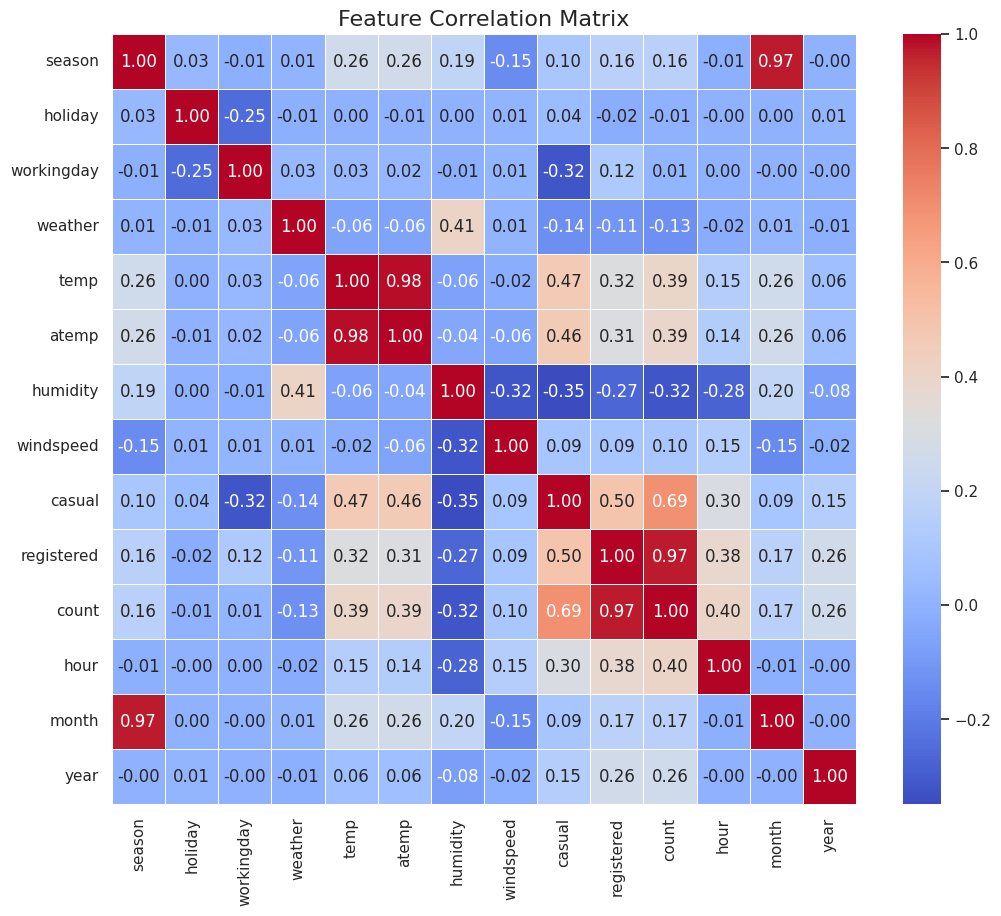

In [47]:
# Convert datetime to numerical features if we want to include them
data['hour'] = pd.to_datetime(data['datetime']).dt.hour
data['month'] = pd.to_datetime(data['datetime']).dt.month
data['year'] = pd.to_datetime(data['datetime']).dt.year


numerical_cols_for_corr = ['season', 'holiday', 'workingday', 'weather',
                           'temp', 'atemp', 'humidity', 'windspeed',
                           'casual', 'registered', 'count','hour', 'month', 'year']

# Ensure all selected columns are present in the DataFrame
existing_cols_for_corr = [col for col in numerical_cols_for_corr if col in data.columns]
if len(existing_cols_for_corr) < len(numerical_cols_for_corr):
    print(f"Warning: Not all columns from the `numerical_cols_for_corr` list were found in the DataFrame. Using: {existing_cols_for_corr}")

if not existing_cols_for_corr:
    raise ValueError("No suitable numerical columns found for building the correlation matrix.")

correlation_matrix = data[existing_cols_for_corr].corr()

# Visualizing the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Matrix', fontsize=16) # Changed title to English
plt.show()

Definitely Keep:

    temp
    humidity
    month (Absorbs season)
    weather
    workingday

Definitely Remove:     atemp ( the same as temp), casual, holiday (has in workingday column), registered, windspeed


In [48]:
data = data[['datetime', 'temp', 'humidity','count', 'workingday', 'weather','month']].copy()
data

,datetime,temp,humidity,count,workingday,weather,month
0,2011-01-01 00:00:00,9.84,81,16,0,1,1
1,2011-01-01 01:00:00,9.02,80,40,0,1,1
2,2011-01-01 02:00:00,9.02,80,32,0,1,1
3,2011-01-01 03:00:00,9.84,75,13,0,1,1
4,2011-01-01 04:00:00,9.84,75,1,0,1,1
...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,15.58,50,336,1,1,12
10882,2012-12-19 20:00:00,14.76,57,241,1,1,12
10883,2012-12-19 21:00:00,13.94,61,168,1,1,12
10884,2012-12-19 22:00:00,13.94,61,129,1,1,12


In [49]:
data['datetime'] = pd.to_datetime(data['datetime'], errors='coerce')
data['date'] = data['datetime'].dt.date
data['hour'] = data['datetime'].dt.hour
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   temp        10886 non-null  float64       
 2   humidity    10886 non-null  int64         
 3   count       10886 non-null  int64         
 4   workingday  10886 non-null  int64         
 5   weather     10886 non-null  int64         
 6   month       10886 non-null  int32         
 7   date        10886 non-null  object        
 8   hour        10886 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(4), object(1)
memory usage: 680.5+ KB


In [50]:
daily_sum = data.groupby('date').agg(
    total_count=('count', 'sum'),
    avg_temp=('temp', 'mean'),
    avg_humidity=('humidity', 'mean'),
    weather_day_mode=('weather', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    month_mode=('month', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    workingday_derived=('workingday', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
).reset_index()

In [51]:
daily_sum

,date,total_count,avg_temp,avg_humidity,weather_day_mode,month_mode,workingday_derived
0,2011-01-01,985,14.110833,80.583333,1,1,0
1,2011-01-02,801,14.902609,69.608696,2,1,0
2,2011-01-03,1349,8.050909,43.727273,1,1,1
3,2011-01-04,1562,8.200000,59.043478,1,1,1
4,2011-01-05,1600,9.305217,43.695652,1,1,1
...,...,...,...,...,...,...,...
451,2012-12-15,5047,13.290833,65.041667,1,12,0
452,2012-12-16,3786,14.862500,83.875000,2,12,0
453,2012-12-17,4585,16.126667,90.708333,2,12,1
454,2012-12-18,5557,16.844167,66.625000,1,12,1


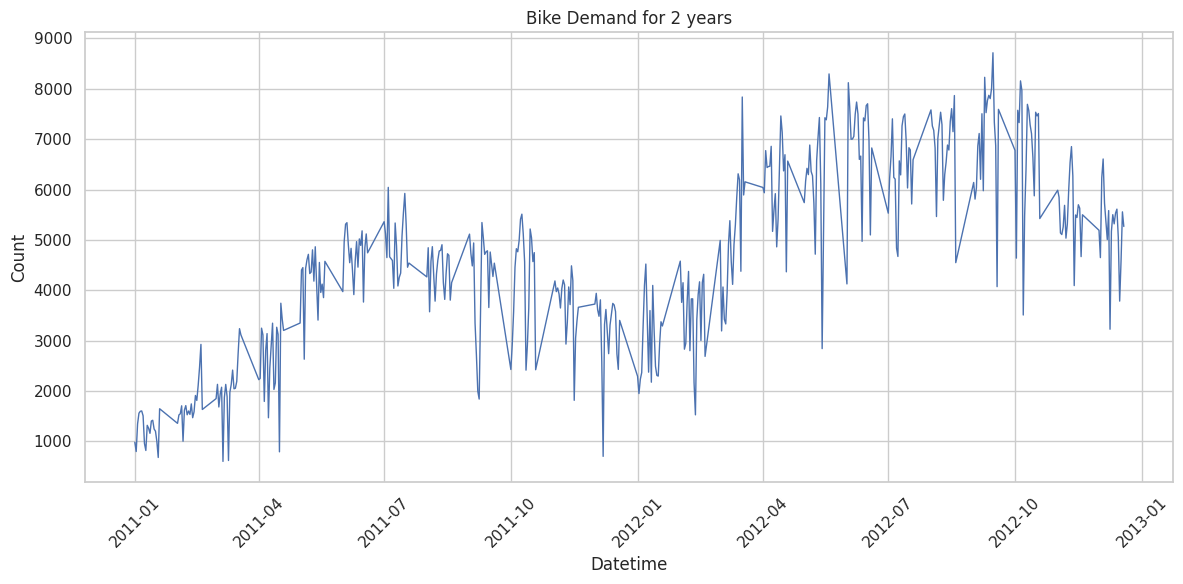

In [53]:
plt.figure(figsize=(12, 6))
sns.set_theme(style="whitegrid")
sns.lineplot(x='date', y='total_count', data=daily_sum, linewidth=1) # linewidth=0.5 или 1
plt.xlabel('Datetime')
plt.ylabel('Count')
plt.title('Bike Demand for 2 years')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The decision to "trim/truncate the data up to April 2011" implies that all data points recorded before April 1st, 2011, will be removed from the dataset used for analysis and model building. The dataset will now effectively begin on or after April 1st, 2011.


In [54]:
daily_sum['date']=pd.to_datetime(daily_sum['date'])

In [55]:
start_date = '2011-04-01'
data_cropped = data[data['datetime'] >= start_date].copy()
data_cropped

,datetime,temp,humidity,count,workingday,weather,month,date,hour
1323,2011-04-01 00:00:00,10.66,100,6,1,3,4,2011-04-01,0
1324,2011-04-01 01:00:00,10.66,100,4,1,3,4,2011-04-01,1
1325,2011-04-01 02:00:00,10.66,93,7,1,3,4,2011-04-01,2
1326,2011-04-01 03:00:00,9.84,93,4,1,2,4,2011-04-01,3
1327,2011-04-01 04:00:00,9.84,93,3,1,2,4,2011-04-01,4
...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,15.58,50,336,1,1,12,2012-12-19,19
10882,2012-12-19 20:00:00,14.76,57,241,1,1,12,2012-12-19,20
10883,2012-12-19 21:00:00,13.94,61,168,1,1,12,2012-12-19,21
10884,2012-12-19 22:00:00,13.94,61,129,1,1,12,2012-12-19,22


In [56]:
data_cropped['datetime'] = pd.to_datetime(data_cropped['datetime'], errors='coerce')
data_cropped['date'] = data_cropped['datetime'].dt.date
data_cropped['hour'] = data_cropped['datetime'].dt.hour

In [57]:
daily_sum = data_cropped.groupby('date').agg(
    total_count=('count', 'sum'),
    avg_temp=('temp', 'mean'),
    avg_humidity=('humidity', 'mean'),
    weather_day_mode=('weather', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    month_mode=('month', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    workingday_derived=('workingday', lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
).reset_index()

In [58]:
hourly_vector=data_cropped.pivot_table(index='date',columns='hour',values='count', fill_value=0)
hourly_vector

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
date,,,,,,,,,,,,,,,,,,,,,
2011-04-01,6.0,4.0,7.0,4.0,3.0,12.0,28.0,95.0,206.0,173.0,...,87.0,111.0,167.0,281.0,241.0,136.0,77.0,93.0,74.0,53.0
2011-04-02,32.0,32.0,21.0,9.0,5.0,5.0,12.0,18.0,55.0,87.0,...,190.0,136.0,196.0,184.0,179.0,148.0,85.0,77.0,55.0,53.0
2011-04-03,39.0,34.0,24.0,11.0,3.0,5.0,33.0,33.0,62.0,142.0,...,349.0,292.0,303.0,274.0,172.0,144.0,79.0,45.0,36.0,31.0
2011-04-04,6.0,11.0,2.0,1.0,2.0,7.0,46.0,157.0,339.0,158.0,...,123.0,143.0,189.0,366.0,386.0,278.0,173.0,95.0,75.0,48.0
2011-04-05,22.0,15.0,5.0,4.0,2.0,5.0,38.0,134.0,157.0,46.0,...,76.0,68.0,130.0,273.0,267.0,160.0,91.0,89.0,46.0,26.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-15,94.0,95.0,69.0,23.0,6.0,3.0,11.0,48.0,119.0,220.0,...,426.0,447.0,413.0,309.0,272.0,257.0,201.0,184.0,156.0,119.0
2012-12-16,110.0,96.0,87.0,38.0,11.0,9.0,6.0,27.0,88.0,132.0,...,310.0,338.0,400.0,243.0,107.0,109.0,122.0,106.0,89.0,33.0
2012-12-17,28.0,15.0,5.0,3.0,5.0,24.0,108.0,319.0,592.0,282.0,...,181.0,211.0,302.0,495.0,507.0,340.0,200.0,120.0,54.0,47.0


In [59]:
hourly_vector.columns = [f'count_h{h}' for h in hourly_vector.columns]
hourly_vector.reset_index(inplace=True)
hourly_vector['date'] = pd.to_datetime(hourly_vector['date'])

# 2.Performing clustering using K-Means+PCA


In [60]:
features = [f'count_h{h}' for h in range(24)]
X = hourly_vector[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

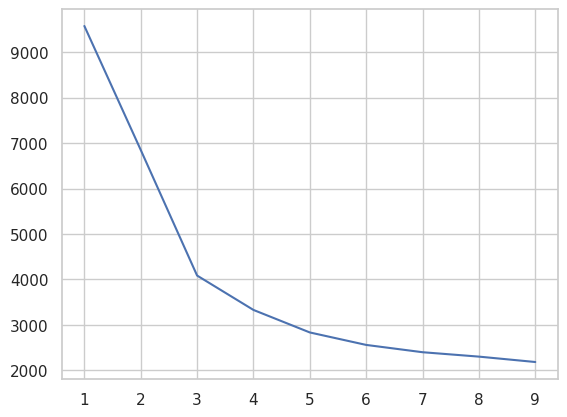

In [61]:
wcss=[]
for  i in range(1,10):
  kmeans=KMeans(i)

  kmeans.fit(X_scaled)
  wcss.append(kmeans.inertia_)
wcss

plt.plot(range(1,10),wcss)

In [67]:
n_clusters = 3 # или 3, или 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_scaled)

silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Для n_clusters = {n_clusters}, Silhouette Score = {silhouette_avg}")
hourly_vector['cluster_id']=kmeans.fit_predict(X_scaled)
hourly_vector

Для n_clusters = 3, Silhouette Score = 0.3420080400581079


,date,count_h0,count_h1,count_h2,count_h3,count_h4,count_h5,count_h6,count_h7,count_h8,...,count_h15,count_h16,count_h17,count_h18,count_h19,count_h20,count_h21,count_h22,count_h23,cluster_id
0,2011-04-01,6.0,4.0,7.0,4.0,3.0,12.0,28.0,95.0,206.0,...,111.0,167.0,281.0,241.0,136.0,77.0,93.0,74.0,53.0,0
1,2011-04-02,32.0,32.0,21.0,9.0,5.0,5.0,12.0,18.0,55.0,...,136.0,196.0,184.0,179.0,148.0,85.0,77.0,55.0,53.0,0
2,2011-04-03,39.0,34.0,24.0,11.0,3.0,5.0,33.0,33.0,62.0,...,292.0,303.0,274.0,172.0,144.0,79.0,45.0,36.0,31.0,0
3,2011-04-04,6.0,11.0,2.0,1.0,2.0,7.0,46.0,157.0,339.0,...,143.0,189.0,366.0,386.0,278.0,173.0,95.0,75.0,48.0,0
4,2011-04-05,22.0,15.0,5.0,4.0,2.0,5.0,38.0,134.0,157.0,...,68.0,130.0,273.0,267.0,160.0,91.0,89.0,46.0,26.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,2012-12-15,94.0,95.0,69.0,23.0,6.0,3.0,11.0,48.0,119.0,...,447.0,413.0,309.0,272.0,257.0,201.0,184.0,156.0,119.0,1
395,2012-12-16,110.0,96.0,87.0,38.0,11.0,9.0,6.0,27.0,88.0,...,338.0,400.0,243.0,107.0,109.0,122.0,106.0,89.0,33.0,1
396,2012-12-17,28.0,15.0,5.0,3.0,5.0,24.0,108.0,319.0,592.0,...,211.0,302.0,495.0,507.0,340.0,200.0,120.0,54.0,47.0,0
397,2012-12-18,18.0,15.0,7.0,5.0,8.0,36.0,118.0,355.0,662.0,...,246.0,363.0,572.0,525.0,353.0,268.0,168.0,132.0,81.0,2


In [68]:
daily_sum['date'] = pd.to_datetime(daily_sum['date'], errors='coerce')

In [71]:
daily_data_with_clusters = pd.merge(daily_sum, hourly_vector[['date', 'cluster_id']], on='date', how='left')

print(f"Количество NaN в cluster_id: {daily_data_with_clusters['cluster_id'].isna().sum()}")

daily_data_with_clusters.dropna(subset=['cluster_id'], inplace=True) # Удаляем дни без кластера
daily_data_with_clusters['cluster_id'] = daily_data_with_clusters['cluster_id'].astype(int)


Количество NaN в cluster_id: 0



Features after OneHotEncoding and scaling (total 20):
Dimensionality of data after preprocessing (X_pca_source_processed): (399, 20)
Selected 3 principal components for PCA.

DataFrame with principal components (pca_df, first 5 rows):
        PC1       PC2       PC3
0 -2.113606 -0.242932 -0.498479
1 -2.025476 -0.452333 -0.392128
2 -1.022165 -1.417867 -0.565845
3 -0.206124 -1.186943 -1.606946
4 -1.789435 -0.200196 -1.162094

Running Elbow Method for k in range [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] on PCA data...


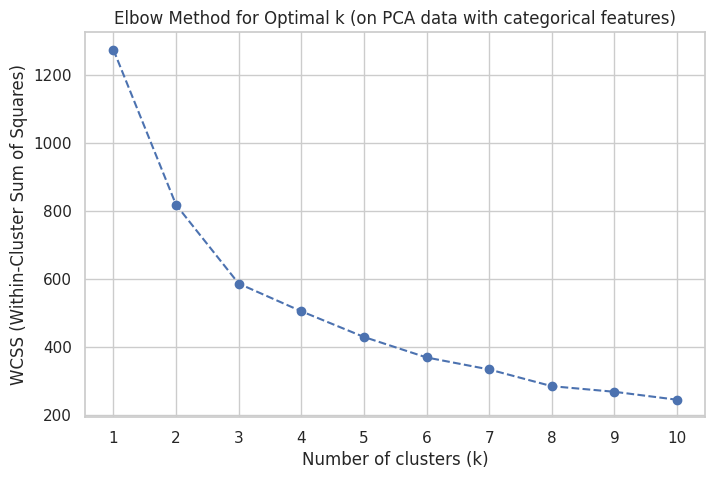

Selected optimal k (on PCA data): 3

Centroids in PCA space (for k=3):
[[-0.85437489 -1.07582758  0.01435405]
 [-0.74751198  1.05358014  0.04444755]
 [ 1.27596298  0.05226513 -0.04628546]]

First 5 rows of daily_data_with_clusters with new 'Cluster_KMeans_PCA' labels:
        date  total_count   avg_temp  avg_humidity  weather_day_mode  \
0 2011-04-01         2227  12.300000     68.625000                 1   
1 2011-04-02         2252  12.915000     65.375000                 1   
2 2011-04-03         3249  15.511667     48.000000                 1   
3 2011-04-04         3115  23.506667     42.625000                 1   
4 2011-04-05         1795  16.980833     64.208333                 1   

   month_mode  workingday_derived  cluster_id  Cluster_KMeans_PCA  
0           4                   1           0                   0  
1           4                   0           0                   0  
2           4                   0           0                   0  
3           4             

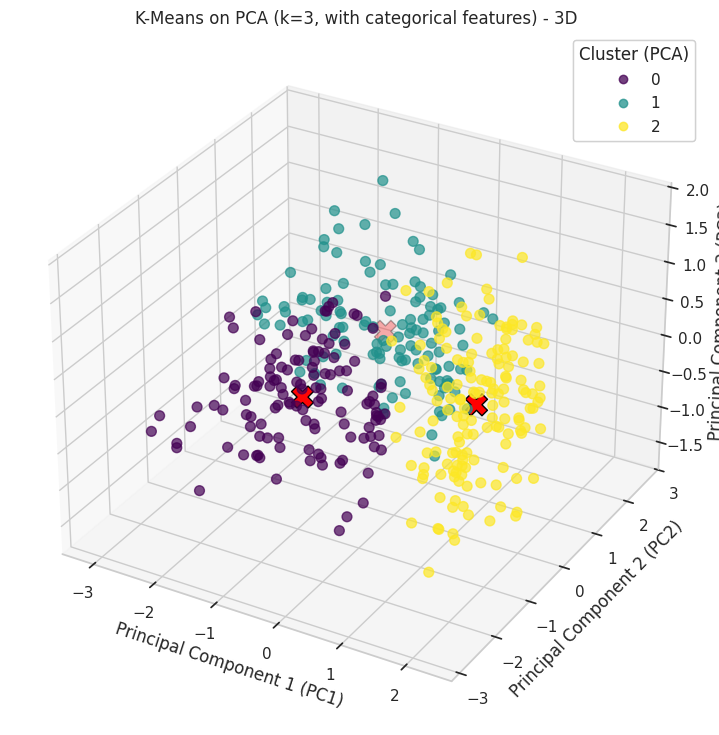

In [72]:

numerical_features = ['total_count', 'avg_temp', 'avg_humidity'] # Ensure 'total_count' or your target is appropriate here for PCA source features
categorical_features = ['weather_day_mode', 'month_mode', 'workingday_derived']

for col in categorical_features:
    if daily_data_with_clusters[col].dtype.name not in ['object', 'category', 'int64', 'int32']:
        print(f"Warning: Column {col} has type {daily_data_with_clusters[col].dtype}, conversion to category might be needed.")
# Create a preprocessor for columns: StandardScaler for numerical, OneHotEncoder for categorical
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features) # sparse_output=False for a dense array
    ],
    remainder='drop' # Other columns (e.g., 'date') will be dropped
)

# Apply preprocessing
X_pca_source_processed = preprocessor.fit_transform(daily_data_with_clusters)

try:
    ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_processed_feature_names = numerical_features + list(ohe_feature_names)
    print(f"\nFeatures after OneHotEncoding and scaling (total {len(all_processed_feature_names)}):")
except Exception as e:
    print(f"Could not get feature names from OneHotEncoder: {e}")
    all_processed_feature_names = None


print(f"Dimensionality of data after preprocessing (X_pca_source_processed): {X_pca_source_processed.shape}")
# Applying PCA ---
pca_expl = PCA()
pca_expl.fit(X_pca_source_processed) # Use processed data
explained_variance_ratio = pca_expl.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Select the number of components
n_components_pca = 3
print(f"Selected {n_components_pca} principal components for PCA.")

pca = PCA(n_components=n_components_pca)
principal_components = pca.fit_transform(X_pca_source_processed)

pc_column_names = [f'PC{i+1}' for i in range(n_components_pca)]
pca_df = pd.DataFrame(data=principal_components, columns=pc_column_names)
pca_df.index = daily_data_with_clusters.index # Preserve original index for merging back

print("\nDataFrame with principal components (pca_df, first 5 rows):")
print(pca_df.head())

# Determining the optimal k for K-Means on PCA data (Elbow Method) ---
wcss_pca_kmeans = []
k_range_elbow_pca = range(1, 11)
print(f"\nRunning Elbow Method for k in range {list(k_range_elbow_pca)} on PCA data...")

for i in k_range_elbow_pca:
    kmeans_elbow_on_pca = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')
    kmeans_elbow_on_pca.fit(pca_df[pc_column_names]) # Fit on the PCA data
    wcss_pca_kmeans.append(kmeans_elbow_on_pca.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range_elbow_pca, wcss_pca_kmeans, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k (on PCA data with categorical features)') # Title in English
plt.xlabel('Number of clusters (k)') # X-axis label in English
plt.ylabel('WCSS (Within-Cluster Sum of Squares)') # Y-axis label in English
plt.xticks(k_range_elbow_pca)
plt.grid(True)
plt.show()

optimal_k_pca = 3  # REPLACE THIS VALUE BASED ON YOUR ELBOW PLOT
print(f"Selected optimal k (on PCA data): {optimal_k_pca}")

# Applying K-Means with the chosen k on PCA data ---
kmeans_on_pca = KMeans(n_clusters=optimal_k_pca, init='k-means++', random_state=42, n_init='auto')
cluster_labels_on_pca = kmeans_on_pca.fit_predict(pca_df[pc_column_names]) # Predict on PCA data

pca_df['Cluster_KMeans_PCA'] = cluster_labels_on_pca
daily_data_with_clusters['Cluster_KMeans_PCA'] = cluster_labels_on_pca # Update or add to the main DataFrame

centroids_on_pca = kmeans_on_pca.cluster_centers_
print(f"\nCentroids in PCA space (for k={optimal_k_pca}):\n{centroids_on_pca}")
print(f"\nFirst 5 rows of daily_data_with_clusters with new 'Cluster_KMeans_PCA' labels:\n{daily_data_with_clusters.head()}")


# --- 5. Visualizing clusters in PCA space ---
# (Visualization code remains the same as in your previous example, titles/labels translated)
if n_components_pca == 2: # Corrected condition to match common 2D scatter plot
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster_KMeans_PCA', palette='viridis', s=70, alpha=0.8, legend='full')
    plt.scatter(centroids_on_pca[:, 0], centroids_on_pca[:, 1],
                marker='X', s=200, color='red', edgecolors='black', label='Centroids (PCA space)')
    plt.title(f'K-Means on PCA (k={optimal_k_pca}, with categorical features) - PC1 vs PC2') # Title in English
    plt.xlabel('Principal Component 1 (PC1)')
    plt.ylabel('Principal Component 2 (PC2)')
    plt.legend(title='Cluster (PCA)') # Legend title in English
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

elif n_components_pca == 3:
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
                         c=pca_df['Cluster_KMeans_PCA'], cmap='viridis', alpha=0.7, s=50)
    ax.scatter(centroids_on_pca[:, 0], centroids_on_pca[:, 1], centroids_on_pca[:, 2],
               marker='X', s=250, color='red', edgecolors='black', label='Centroids (PCA space)')
    ax.set_title(f'K-Means on PCA (k={optimal_k_pca}, with categorical features) - 3D') # Title in English
    ax.set_xlabel('Principal Component 1 (PC1)')
    ax.set_ylabel('Principal Component 2 (PC2)')
    ax.set_zlabel('Principal Component 3 (PC3)')
    legend1 = ax.legend(*scatter.legend_elements(), title="Cluster (PCA)")
    ax.add_artist(legend1)
    if len(ax.get_legend_handles_labels()[0]) > len(scatter.legend_elements()[0]):
        ax.legend(loc='best')
    plt.show()
else:
    print(f"Visualization for {n_components_pca} components is not implemented (only for 2 or 3).")


Hourly data with PCA cluster labels (first 5 rows):
                datetime   temp  humidity  count  workingday  weather  month  \
1323 2011-04-01 00:00:00  10.66       100      6           1        3      4   
1324 2011-04-01 01:00:00  10.66       100      4           1        3      4   
1325 2011-04-01 02:00:00  10.66        93      7           1        3      4   
1326 2011-04-01 03:00:00   9.84        93      4           1        2      4   
1327 2011-04-01 04:00:00   9.84        93      3           1        2      4   

            date  hour  Cluster_KMeans_PCA  
1323  2011-04-01     0                   0  
1324  2011-04-01     1                   0  
1325  2011-04-01     2                   0  
1326  2011-04-01     3                   0  
1327  2011-04-01     4                   0  


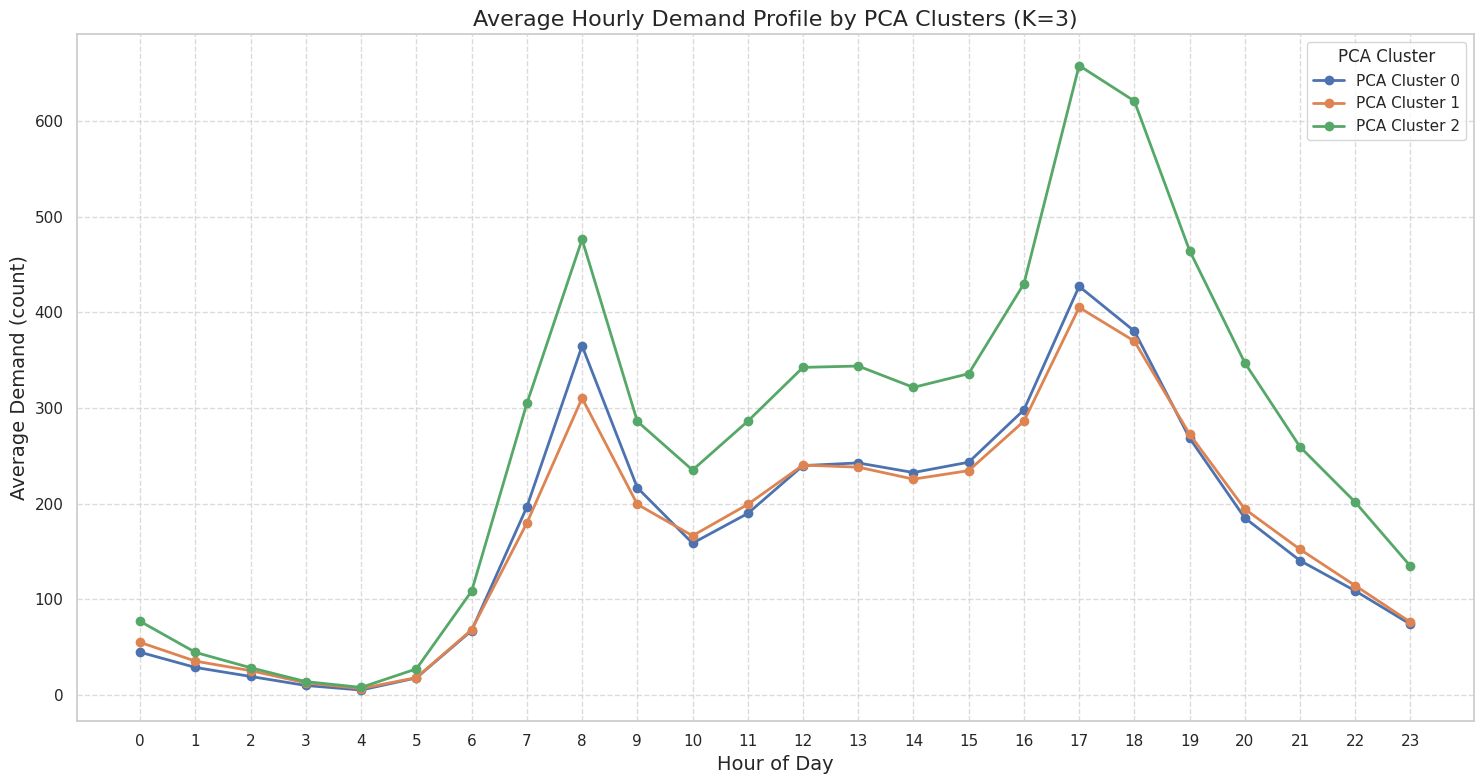

In [73]:
# Convert the 'date' column in daily_data_with_clusters to datetime64[ns] if it isn't already (important for merge)
daily_data_with_clusters['date'] = pd.to_datetime(daily_data_with_clusters['date'])

# Prepare original hourly data
hourly_data_for_profiles = data.copy() # Assuming 'data' is your original hourly DataFrame
hourly_data_for_profiles['datetime'] = pd.to_datetime(hourly_data_for_profiles['datetime'])
hourly_data_for_profiles['date_only'] = hourly_data_for_profiles['datetime'].dt.date # For merging, if 'date' in daily_data_with_clusters is also a date object
hourly_data_for_profiles['hour'] = hourly_data_for_profiles['datetime'].dt.hour

# Convert 'date_only' to a timestamp for merging, if 'date' in daily_data_with_clusters is datetime64
hourly_data_for_profiles['date_for_merge'] = pd.to_datetime(hourly_data_for_profiles['date_only'])


# Merging PCA cluster labels with hourly data ---
# Ensure 'date' and 'Cluster_KMeans_PCA' exist in daily_data_with_clusters
if 'date' in daily_data_with_clusters.columns and 'Cluster_KMeans_PCA' in daily_data_with_clusters.columns:
    pca_cluster_labels_df = daily_data_with_clusters[['date', 'Cluster_KMeans_PCA']].drop_duplicates()

    # Merge
    hourly_data_with_pca_clusters = pd.merge(
        hourly_data_for_profiles,
        pca_cluster_labels_df,
        left_on='date_for_merge', # Use the prepared column
        right_on='date',        # 'date' from daily_data_with_clusters (already datetime64)
        how='left'
    )

    # Remove auxiliary date columns if they are no longer needed
    # The 'date_y' column is created by merge if 'date' exists in both DFs before merge with different content/names
    # 'date_x' would be the original 'date' from the left DataFrame if 'date' was also in the right.
    # It's safer to explicitly drop the one from the right ('date') if it was duplicated.
    columns_to_drop_after_merge = ['date_only', 'date_for_merge']
    if 'date_y' in hourly_data_with_pca_clusters.columns: # This 'date_y' comes from pca_cluster_labels_df
        columns_to_drop_after_merge.append('date_y')
    # If 'date_x' and 'date' (from pca_cluster_labels_df which becomes 'date_y') both exist,
    # it means 'date' was also a column name in hourly_data_for_profiles.
    # We need to decide which 'date' column to keep or rename.
    # Assuming 'date_x' (original from hourly_data_for_profiles) is what we want as the primary date after merge:
    if 'date_x' in hourly_data_with_pca_clusters.columns and 'date_y' in hourly_data_with_pca_clusters.columns:
        hourly_data_with_pca_clusters.rename(columns={'date_x': 'date'}, inplace=True) # Keep original date from hourly data
    elif 'date' not in hourly_data_with_pca_clusters.columns and 'date_x' in hourly_data_with_pca_clusters.columns: # if 'date' was only on right
        hourly_data_with_pca_clusters.rename(columns={'date_x': 'date'}, inplace=True)


    hourly_data_with_pca_clusters.drop(columns=columns_to_drop_after_merge, inplace=True, errors='ignore')


    # Check for NaNs after merge (if not all days from hourly_data have a cluster label)
    if 'Cluster_KMeans_PCA' in hourly_data_with_pca_clusters.columns:
        if hourly_data_with_pca_clusters['Cluster_KMeans_PCA'].isna().any():
            print(f"Warning: {hourly_data_with_pca_clusters['Cluster_KMeans_PCA'].isna().sum()} rows did not receive a PCA cluster label after merge.")
            hourly_data_with_pca_clusters.dropna(subset=['Cluster_KMeans_PCA'], inplace=True) # Remove rows without a cluster label
        hourly_data_with_pca_clusters['Cluster_KMeans_PCA'] = hourly_data_with_pca_clusters['Cluster_KMeans_PCA'].astype(int)
    else:
        print("Warning: 'Cluster_KMeans_PCA' column not found after merge.")

else:
    print("Error: 'date' or 'Cluster_KMeans_PCA' not found in daily_data_with_clusters for merging.")
    hourly_data_with_pca_clusters = pd.DataFrame() # Create empty df to avoid further errors


print("\nHourly data with PCA cluster labels (first 5 rows):") # Title in English
if not hourly_data_with_pca_clusters.empty:
    print(hourly_data_with_pca_clusters.head())
else:
    print("DataFrame 'hourly_data_with_pca_clusters' is empty.")


# Aggregating hourly demand by PCA clusters ---
if not hourly_data_with_pca_clusters.empty and 'Cluster_KMeans_PCA' in hourly_data_with_pca_clusters.columns and 'hour' in hourly_data_with_pca_clusters.columns and 'count' in hourly_data_with_pca_clusters.columns:
    average_hourly_profiles_pca = hourly_data_with_pca_clusters.groupby(['Cluster_KMeans_PCA', 'hour'])['count'].mean().unstack(level=0)
    # unstack(level=0) makes Cluster_KMeans_PCA columns

    # Visualizing average hourly profiles for PCA clusters ---
    plt.figure(figsize=(15, 8))
    sns.set_theme(style="whitegrid")

    for cluster_pca_id in average_hourly_profiles_pca.columns:
        plt.plot(average_hourly_profiles_pca.index, average_hourly_profiles_pca[cluster_pca_id], marker='o', linewidth=2, label=f'PCA Cluster {cluster_pca_id}')

    # Determine optimal_k for title, robustly
    optimal_k_title = "Unknown"
    if "kmeans_on_pca" in locals() and hasattr(kmeans_on_pca, 'n_clusters'):
        optimal_k_title = kmeans_on_pca.n_clusters
    elif 'optimal_k_pca' in locals():
        optimal_k_title = optimal_k_pca


    plt.title(f'Average Hourly Demand Profile by PCA Clusters (K={optimal_k_title})', fontsize=16) # Title in English
    plt.xlabel('Hour of Day', fontsize=14) # X-axis label in English
    plt.ylabel('Average Demand (count)', fontsize=14) # Y-axis label in English
    plt.xticks(average_hourly_profiles_pca.index) # To ensure all hours are on the X-axis
    plt.legend(title='PCA Cluster') # Legend title in English
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Could not create hourly profiles because 'hourly_data_with_pca_clusters' is empty or missing required columns.")

**In summary, the PCA-KMeans clustering has effectively identified groups of days with unique intraday demand characteristics. Cluster 2 represents high-demand "commuter" days, while Clusters 0 and 1 represent days with more moderate, yet still bimodal, demand patterns, with Cluster 0 generally having slightly higher usage than Cluster 1. **

## Cluster Composition Analysis (Post PCA+K-Means)

After performing clustering using PCA and K-Means (K=3), we now analyze the composition of each cluster to understand what characteristics define them. This involves looking at the distribution of days of the week, working vs. non-working days, seasons, weather conditions, and average meteorological values within each cluster.

In [75]:
if 'Cluster_KMeans_PCA' not in daily_data_with_clusters.columns:
    print("Error: 'Cluster_KMeans_PCA' column not found in daily_data_with_clusters. Cannot perform cluster analysis.")
else:
    n_clusters_to_analyze = daily_data_with_clusters['Cluster_KMeans_PCA'].nunique() # Should be 3 if optimal_k_pca was 3

    for i in range(n_clusters_to_analyze):
        print(f"\n\n--- Analysis of Cluster {i} Composition (K={n_clusters_to_analyze}) ---") # Title in English
        cluster_subset = daily_data_with_clusters[daily_data_with_clusters['Cluster_KMeans_PCA'] == i]

        if cluster_subset.empty:
            print("Cluster is empty.")
            continue

        print(f"Number of days in cluster: {len(cluster_subset)}")

        # 1. Day of the week
        if 'day_name' in cluster_subset.columns: # Assuming you have a 'day_name' column (e.g., Monday, Tuesday)
            print("\nDistribution by day of the week:")
            print(cluster_subset['day_name'].value_counts(normalize=True).sort_index())
        elif 'date' in cluster_subset.columns: # Fallback to deriving day name if 'day_name' is missing
            print("\nDistribution by day of the week (derived):")
            print(pd.to_datetime(cluster_subset['date']).dt.day_name().value_counts(normalize=True).sort_index())


        # 2. Working/Weekend day
        if 'workingday' in cluster_subset.columns: # Assuming 'workingday' column (0 or 1)
            print("\nDistribution working/non-working day (0=weekend/holiday, 1=working day):")
            print(cluster_subset['workingday'].value_counts(normalize=True))

        # 3. Season
        if 'season' in cluster_subset.columns: # Assuming 'season' column (1,2,3,4)
            print("\nDistribution by seasons (1:Spring, 2:Summer, 3:Fall, 4:Winter):")
            season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}
            print(cluster_subset['season'].map(season_map).value_counts(normalize=True))

        # 4. Weather category (e.g., from original Kaggle dataset or a derived daily mode)
        weather_col_name = 'weather_day_mode'
        if weather_col_name in cluster_subset.columns:
            print("\nDistribution by weather categories (1:Clear, 2:Mist, 3:Light Rain/Snow, 4:Heavy Rain/Snow/Fog):")
            weather_map = {1: 'Clear/Few clouds', 2: 'Mist/Cloudy', 3: 'Light Snow/Rain', 4: 'Heavy Rain/Snow/Fog'}
            # Check if mapping is needed or if values are already descriptive
            if cluster_subset[weather_col_name].dtype == 'object' or cluster_subset[weather_col_name].max() > 4 :
                 print(cluster_subset[weather_col_name].value_counts(normalize=True))
            else:
                 print(cluster_subset[weather_col_name].map(weather_map).value_counts(normalize=True))


        # 5. Average weather conditions
        print("\nAverage weather conditions in the cluster:")
        if 'avg_temp' in cluster_subset.columns: # Assuming 'avg_temp' for average daily temperature
            print(f"  Average temperature: {cluster_subset['avg_temp'].mean():.2f} C")
        if 'avg_humidity' in cluster_subset.columns: # Assuming 'avg_humidity' for average daily humidity
            print(f"  Average humidity: {cluster_subset['avg_humidity'].mean():.2f} %")
        if 'avg_windspeed' in cluster_subset.columns: # Assuming 'avg_windspeed' for average daily windspeed
            print(f"  Average wind speed: {cluster_subset['avg_windspeed'].mean():.2f}")

        # 6. Look at some example dates from the cluster
        if 'date' in cluster_subset.columns:
            print("\nExample dates in the cluster:")
            print(pd.to_datetime(cluster_subset['date']).sample(min(5, len(cluster_subset))).dt.strftime('%Y-%m-%d').tolist())
        else:
            print("\n'date' column not found, cannot show example dates.")



--- Analysis of Cluster 0 Composition (K=3) ---
Number of days in cluster: 125

Distribution by day of the week (derived):
date
Friday       0.184
Monday       0.144
Saturday     0.160
Sunday       0.136
Thursday     0.152
Tuesday      0.112
Wednesday    0.112
Name: proportion, dtype: float64

Distribution by weather categories (1:Clear, 2:Mist, 3:Light Rain/Snow, 4:Heavy Rain/Snow/Fog):
weather_day_mode
Clear/Few clouds    0.856
Mist/Cloudy         0.136
Light Snow/Rain     0.008
Name: proportion, dtype: float64

Average weather conditions in the cluster:
  Average temperature: 14.39 C
  Average humidity: 53.58 %

Example dates in the cluster:
['2011-11-04', '2012-11-03', '2011-12-16', '2012-02-12', '2011-11-05']


--- Analysis of Cluster 1 Composition (K=3) ---
Number of days in cluster: 120

Distribution by day of the week (derived):
date
Friday       0.108333
Monday       0.158333
Saturday     0.116667
Sunday       0.200000
Thursday     0.108333
Tuesday      0.158333
Wednesday   

## Visualizing Cluster Composition

To better understand the characteristics that define each PCA-KMeans cluster (K=3), we visualize the distribution of key categorical features within each cluster. This includes:
*   Working days vs. Non-working days.
*   Distribution across months.
*   Distribution across different weather types.

This analysis helps to interpret what each cluster represents in terms of daily conditions.

--- Determining working/non-working day column ---
Column 'workingday' is missing. Creating 'workingday_derived' based on day of the week.
Created columns 'dayofweek' and 'workingday_derived'. (0 = Weekend, 1 = Weekday)
Column for day type analysis: workingday_derived


--- Analysis and Visualization for PCA-Cluster 0 ---
Number of days in cluster: 125


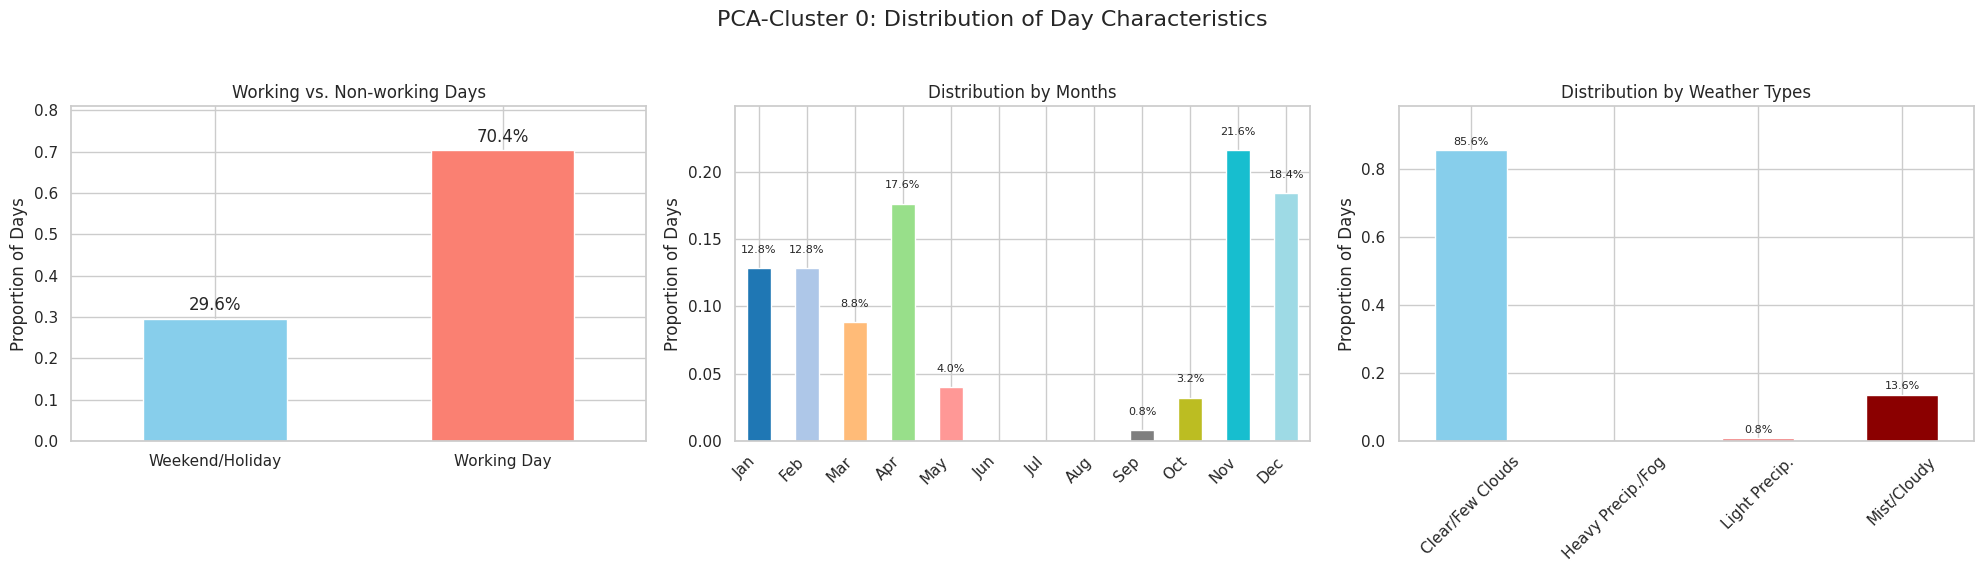



--- Analysis and Visualization for PCA-Cluster 1 ---
Number of days in cluster: 120


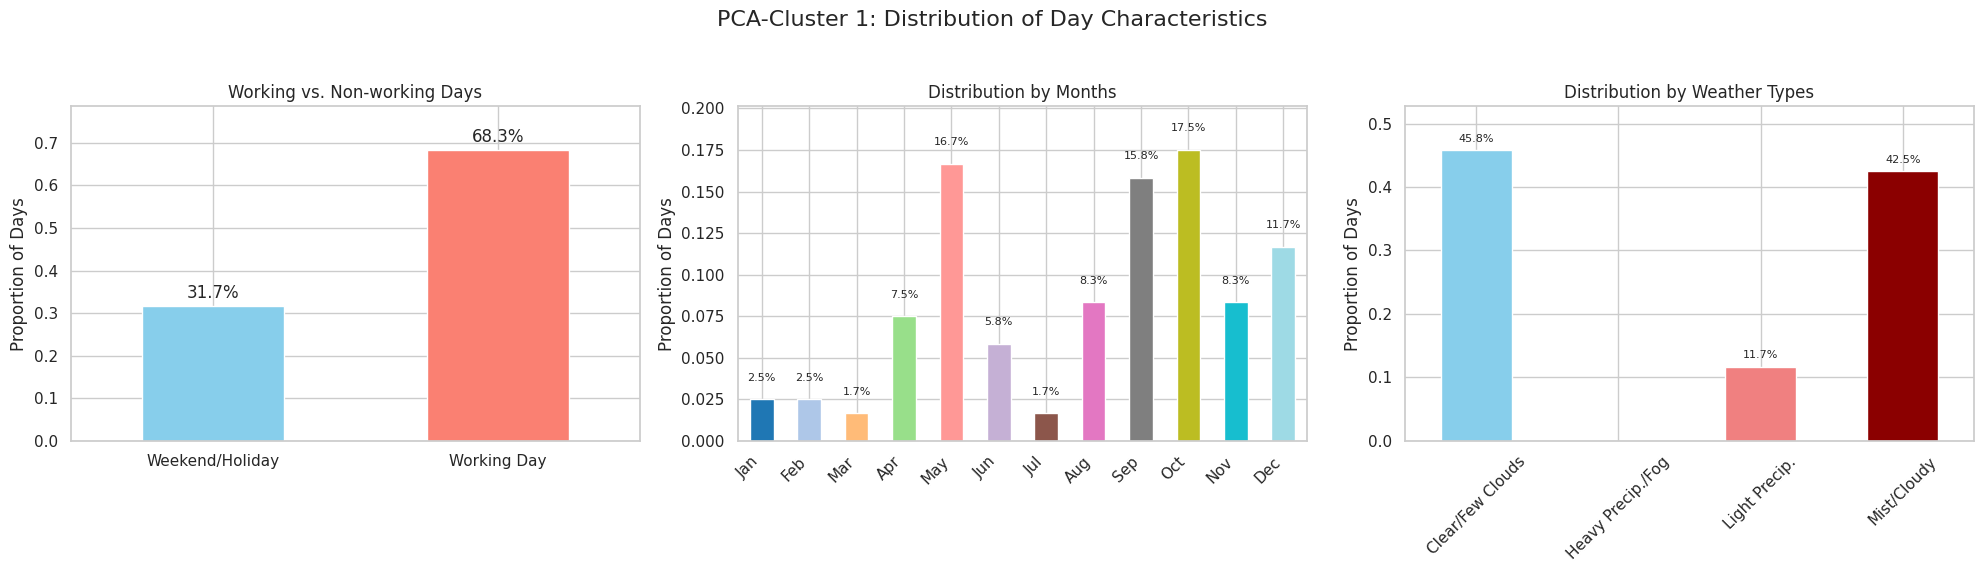



--- Analysis and Visualization for PCA-Cluster 2 ---
Number of days in cluster: 154


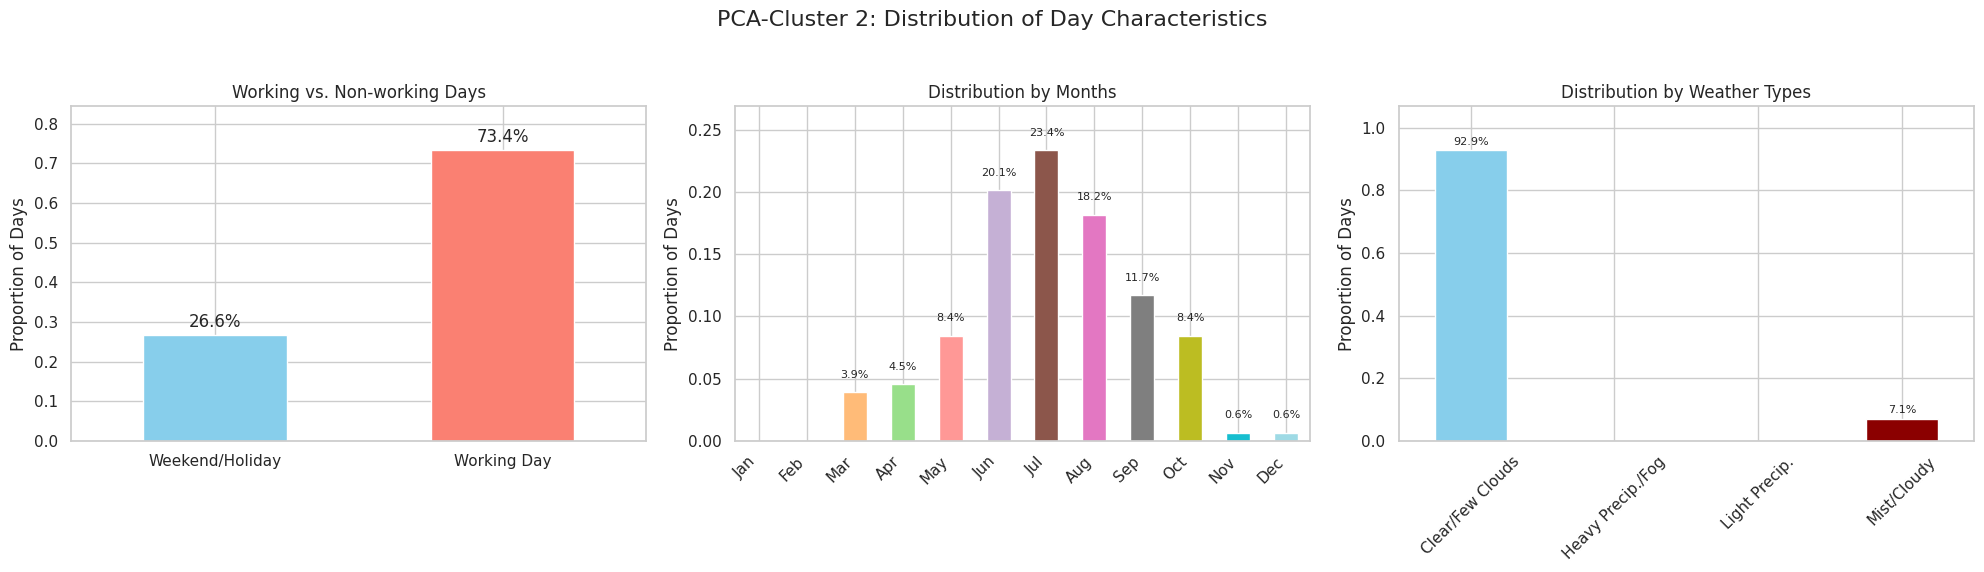


--- Percentage Distribution of Working vs. Non-Working Days per Cluster ---

Percentage Share:
workingday_derived  Working Days (%)  Non-Working Days (%)
Cluster_KMeans_PCA                                        
0                              70.40                 29.60
1                              68.33                 31.67
2                              73.38                 26.62


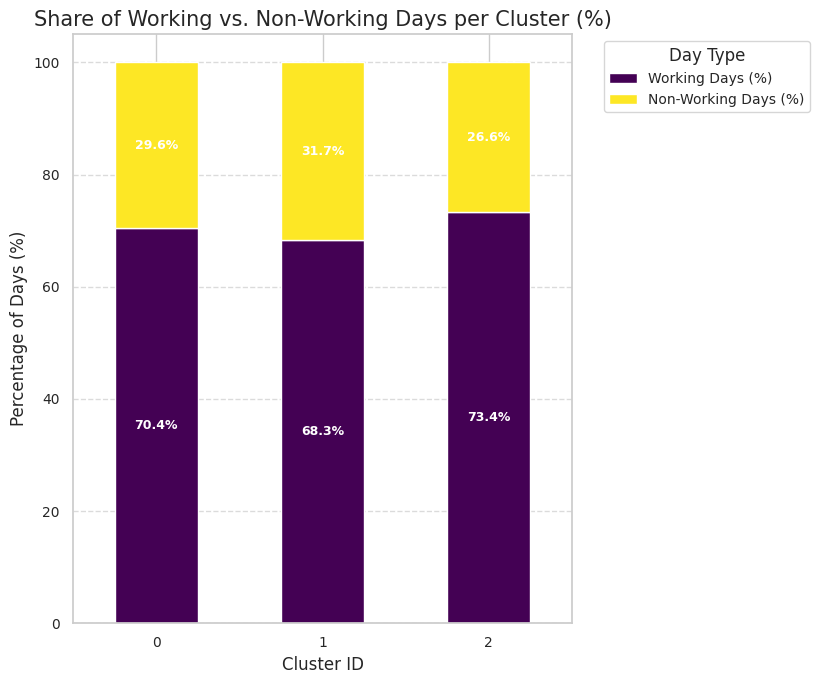

In [78]:
print("--- Determining working/non-working day column ---")
if 'workingday' not in daily_data_with_clusters.columns:
    print("Column 'workingday' is missing. Creating 'workingday_derived' based on day of the week.")
    if 'date' not in daily_data_with_clusters.columns or not pd.api.types.is_datetime64_any_dtype(daily_data_with_clusters['date']):
        raise ValueError("Critical error: 'date' column is missing or not datetime, cannot create 'workingday_derived'.")
    daily_data_with_clusters['dayofweek'] = daily_data_with_clusters['date'].dt.dayofweek # Monday=0, Sunday=6
    daily_data_with_clusters['workingday_derived'] = daily_data_with_clusters['dayofweek'].apply(lambda x: 0 if x >= 5 else 1) # 0 for weekend, 1 for weekday
    workingday_col_name = 'workingday_derived'
    print(f"Created columns 'dayofweek' and '{workingday_col_name}'. (0 = Weekend, 1 = Weekday)")
else:
    workingday_col_name = 'workingday'
    print(f"Using existing column '{workingday_col_name}'. (Typically 0 = Holiday/Weekend, 1 = Working Day)")

print(f"Column for day type analysis: {workingday_col_name}")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume daily_data_with_clusters is defined and populated
# Assume DATE_COLUMN and TARGET_COLUMN are defined

# --- Data Preparation and Checks (if not already done or to ensure robustness) ---
if 'daily_data_with_clusters' not in locals() or daily_data_with_clusters.empty:
    print("WARNING: 'daily_data_with_clusters' not found. Creating example data...") # Text in English
    dates_example_ds = pd.to_datetime(pd.date_range(start='2011-04-01', periods=399, freq='D'))
    daily_data_with_clusters_example = pd.DataFrame({
        'date': dates_example_ds, # Assuming DATE_COLUMN is 'date'
        'total_count': np.random.randint(1000, 8000, size=399), # Assuming TARGET_COLUMN could be 'total_count' or similar for example
        'avg_temp': np.random.uniform(5, 30, size=399),
        'avg_humidity': np.random.uniform(30, 90, size=399),
        'avg_windspeed': np.random.uniform(1, 25, size=399),
        'weather_day_mode': np.random.choice([1, 2, 3, 4], size=399, p=[0.65, 0.25, 0.08, 0.02]),
        'month_mode': dates_example_ds.month,
        'dayofweek': dates_example_ds.dayofweek,
        'Cluster_KMeans_PCA': np.random.choice([0, 1, 2], size=399)
    })
    daily_data_with_clusters_example['workingday_derived'] = np.where(
        (daily_data_with_clusters_example['dayofweek'] < 5) , 1, 0
    )
    # Assign to the main variable if it was missing
    daily_data_with_clusters = daily_data_with_clusters_example.copy()
else:
    # Ensure required columns exist for analysis, create 'month_mode' if missing
    required_cols_analysis = ['Cluster_KMeans_PCA', 'workingday_derived', 'month_mode', 'weather_day_mode']
    if 'date' not in daily_data_with_clusters.columns and DATE_COLUMN in daily_data_with_clusters.columns: # If 'date' is used internally but main date col has different name
        daily_data_with_clusters['date_internal_viz'] = pd.to_datetime(daily_data_with_clusters[DATE_COLUMN])
    elif 'date' in daily_data_with_clusters.columns:
        daily_data_with_clusters['date_internal_viz'] = pd.to_datetime(daily_data_with_clusters['date'])


    if not all(col in daily_data_with_clusters.columns for col in required_cols_analysis):
        missing_cols = [col for col in required_cols_analysis if col not in daily_data_with_clusters.columns]
        if 'month_mode' in missing_cols and 'date_internal_viz' in daily_data_with_clusters.columns:
            print("Column 'month_mode' is missing, creating from 'date_internal_viz'.") # Text in English
            daily_data_with_clusters['month_mode'] = daily_data_with_clusters['date_internal_viz'].dt.month
            if 'month_mode' in missing_cols: missing_cols.remove('month_mode') # Check before removing
        if missing_cols: # If still missing cols after attempting to create month_mode
            raise ValueError(f"Missing required columns for analysis in daily_data_with_clusters: {missing_cols}") # Text in English

    # Ensure categorical columns are integer type and handle NaNs before astype
    for col_int in ['Cluster_KMeans_PCA', 'workingday_derived', 'month_mode', 'weather_day_mode']:
        if col_int in daily_data_with_clusters.columns: # Check if column exists
            if daily_data_with_clusters[col_int].isna().any():
                print(f"Warning: Column '{col_int}' contains NaNs. Dropping rows with NaNs in this column before astype(int).")
                daily_data_with_clusters.dropna(subset=[col_int], inplace=True)
            # Check if column still exists after potential dropna and is not empty
            if col_int in daily_data_with_clusters.columns and not daily_data_with_clusters.empty:
                 daily_data_with_clusters[col_int] = daily_data_with_clusters[col_int].astype(int)
            elif col_int not in daily_data_with_clusters.columns:
                 print(f"Warning: Column '{col_int}' was removed or does not exist after NaNs check.")
        else:
            print(f"Warning: Column '{col_int}' for astype(int) not found in daily_data_with_clusters.")


# Check if 'Cluster_KMeans_PCA' exists and is not empty before proceeding
if 'Cluster_KMeans_PCA' not in daily_data_with_clusters.columns or daily_data_with_clusters['Cluster_KMeans_PCA'].empty:
    print("Critical: 'Cluster_KMeans_PCA' column is missing or empty in 'daily_data_with_clusters'. Cannot proceed with cluster analysis visualization.")
else:
    n_clusters_to_analyze = daily_data_with_clusters['Cluster_KMeans_PCA'].nunique()
    pca_cluster_ids_to_analyze = sorted(daily_data_with_clusters['Cluster_KMeans_PCA'].unique())

    # --- Mappings for readable labels ---
    workingday_map = {0: 'Weekend/Holiday', 1: 'Working Day'} # Labels in English
    weather_map = {1: 'Clear/Few Clouds', 2: 'Mist/Cloudy', 3: 'Light Precip.', 4: 'Heavy Precip./Fog'} # Labels in English, Precip. for Precipitation
    month_map_names = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
        7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    } # Month abbreviations in English

    # Generate a colormap for months
    try:
        month_cmap = plt.colormaps.get_cmap('tab20') # Get the colormap object
        month_colors = [month_cmap(i) for i in np.linspace(0, 1, 12)] # Generate 12 distinct colors
    except AttributeError: # Fallback for older matplotlib if plt.colormaps.get_cmap fails
        month_cmap = plt.cm.get_cmap('tab20')
        month_colors = [month_cmap(i) for i in np.linspace(0, 1, 12)]


    sns.set_theme(style="whitegrid")

    for i in pca_cluster_ids_to_analyze:
        print(f"\n\n--- Analysis and Visualization for PCA-Cluster {i} ---") # Text in English
        cluster_subset = daily_data_with_clusters[daily_data_with_clusters['Cluster_KMeans_PCA'] == i]

        if cluster_subset.empty:
            print("Cluster is empty.") # Text in English
            continue

        print(f"Number of days in cluster: {len(cluster_subset)}") # Text in English

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        fig.suptitle(f'PCA-Cluster {i}: Distribution of Day Characteristics', fontsize=16) # Title in English

        # --- 1. Distribution by WORKING/NON-WORKING DAYS ---
        if 'workingday_derived' in cluster_subset.columns:
            wd_dist = cluster_subset['workingday_derived'].map(workingday_map).value_counts(normalize=True).sort_index()
            wd_dist.plot(kind='bar', ax=axes[0], color=['skyblue', 'salmon'])
            axes[0].set_title('Working vs. Non-working Days') # Title in English
            axes[0].set_ylabel('Proportion of Days') # Y-axis label in English
            axes[0].set_xlabel('')
            axes[0].tick_params(axis='x', rotation=0)
            for index, value in enumerate(wd_dist):
                axes[0].text(index, value + 0.01, f"{value:.1%}", ha='center', va='bottom')
            if not wd_dist.empty: axes[0].set_ylim(0, max(0.1, wd_dist.max() * 1.15)) # Ensure some space for text
        else:
            axes[0].text(0.5, 0.5, 'No "workingday_derived" data', ha='center', va='center', fontsize=10, color='red') # Text in English
            axes[0].set_title('Working vs. Non-working Days') # Title in English

        # --- 2. Distribution by MONTHS ---
        if 'month_mode' in cluster_subset.columns:
            month_dist = cluster_subset['month_mode'].value_counts(normalize=True).sort_index()
            # Ensure all months are present for consistent plotting order, fill with 0 if month is missing
            month_dist_full = pd.Series(index=range(1, 13), data=0.0)
            month_dist_full.update(month_dist)
            month_dist_full_labels = month_dist_full.index.map(month_map_names)

            month_dist_full.plot(kind='bar', ax=axes[1], color=month_colors) # Use generated colors
            axes[1].set_title('Distribution by Months') # Title in English
            axes[1].set_ylabel('Proportion of Days') # Y-axis label in English
            axes[1].set_xlabel('')
            axes[1].set_xticklabels(month_dist_full_labels, rotation=45, ha='right')
            for index, value in enumerate(month_dist_full):
                if value > 0: # Only annotate bars with actual values
                    axes[1].text(index, value + 0.01, f"{value:.1%}", ha='center', va='bottom', fontsize=8)
            if not month_dist_full.empty: axes[1].set_ylim(0, max(0.1, month_dist_full.max() * 1.15))
        else:
            axes[1].text(0.5, 0.5, 'No "month_mode" data', ha='center', va='center', fontsize=10, color='red') # Text in English
            axes[1].set_title('Distribution by Months') # Title in English

        # --- 3. Distribution by WEATHER ---
        if 'weather_day_mode' in cluster_subset.columns:
            weather_dist = cluster_subset['weather_day_mode'].map(weather_map).value_counts(normalize=True)
            # Ensure all weather types from map are present for consistent plotting order
            weather_dist_full = pd.Series(index=list(weather_map.values()), data=0.0) # Use values from map as index
            weather_dist_full.update(weather_dist)
            weather_dist_full = weather_dist_full.sort_index() # Sort by weather type description if desired

            weather_dist_full.plot(kind='bar', ax=axes[2], color=['skyblue', 'lightgrey', 'lightcoral', 'darkred'])
            axes[2].set_title('Distribution by Weather Types') # Title in English
            axes[2].set_ylabel('Proportion of Days') # Y-axis label in English
            axes[2].set_xlabel('')
            axes[2].tick_params(axis='x', rotation=45) # Rotate and align x-ticks
            for index, value in enumerate(weather_dist_full):
                if value > 0: # Only annotate bars with actual values
                    axes[2].text(index, value + 0.01, f"{value:.1%}", ha='center', va='bottom', fontsize=8)
            if not weather_dist_full.empty: axes[2].set_ylim(0, max(0.1, weather_dist_full.max() * 1.15))
        else:
            axes[2].text(0.5, 0.5, 'No "weather_day_mode" data', ha='center', va='center', fontsize=10, color='red') # Text in English
            axes[2].set_title('Distribution by Weather Types') # Title in English

        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
        plt.show()
#  Calculate Percentage Distribution ---
print("\n--- Percentage Distribution of Working vs. Non-Working Days per Cluster ---")

working_day_percentage = pd.DataFrame() # Initialize empty DataFrame in case of errors

try:
    if workingday_col_name not in daily_data_with_clusters.columns:
        raise KeyError(f"Critical error: Column '{workingday_col_name}' is still missing in daily_data_with_clusters!")

    # Group by cluster_id and then by the working day column, calculate normalized value counts
    value_counts_perc = daily_data_with_clusters.groupby('Cluster_KMeans_PCA')[workingday_col_name].value_counts(normalize=True)

    working_day_percentage = value_counts_perc.unstack(fill_value=0.0) # fill_value is float for percentages

    rename_map = {}
    if 0 in working_day_percentage.columns:
        rename_map[0] = 'Non-Working Days (%)'
    if 1 in working_day_percentage.columns:
        rename_map[1] = 'Working Days (%)'

    if rename_map: # If there's anything to rename
        working_day_percentage.rename(columns=rename_map, inplace=True)

    # Fill missing day types with 0 if one type is completely absent in all clusters after unstacking
    if 'Working Days (%)' not in working_day_percentage.columns and 'Non-Working Days (%)' in working_day_percentage.columns:
        working_day_percentage['Working Days (%)'] = 0.0
    if 'Non-Working Days (%)' not in working_day_percentage.columns and 'Working Days (%)' in working_day_percentage.columns:
        working_day_percentage['Non-Working Days (%)'] = 0.0

    # Ensure correct column order for stacked bar
    if 'Working Days (%)' in working_day_percentage.columns and 'Non-Working Days (%)' in working_day_percentage.columns:
         working_day_percentage = working_day_percentage[['Working Days (%)', 'Non-Working Days (%)']]


    # Convert to percentages
    if not working_day_percentage.empty:
        for col in working_day_percentage.columns:
            if col.endswith('(%)'): # Only multiply columns intended to be percentages
                 working_day_percentage[col] *= 100

except Exception as e:
    print(f"!!! ERROR during calculation of working_day_percentage: {e}")

print("\nPercentage Share:")
if not working_day_percentage.empty:
    print(working_day_percentage.round(2))
else:
    print("Could not calculate percentage distribution.")


# --- Step 3: Visualization (Stacked Bar Chart) ---
if not working_day_percentage.empty and \
   ('Working Days (%)' in working_day_percentage.columns or \
    'Non-Working Days (%)' in working_day_percentage.columns) : # Check if there's data to plot

    # Ensure we only plot percentage columns if they exist
    plot_columns = [col for col in ['Working Days (%)', 'Non-Working Days (%)'] if col in working_day_percentage.columns]

    if plot_columns: # Only plot if there are valid columns
        working_day_percentage[plot_columns].plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')
        plt.title('Share of Working vs. Non-Working Days per Cluster (%)', fontsize=15)
        plt.xlabel('Cluster ID', fontsize=12)
        plt.ylabel('Percentage of Days (%)', fontsize=12)
        plt.xticks(rotation=0, fontsize=10)
        plt.yticks(fontsize=10)
        plt.legend(title='Day Type', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add text annotations for percentages
        for i, cluster_idx in enumerate(working_day_percentage.index):
            cumulative_height = 0
            for col_name in plot_columns: # Iterate through the columns we are plotting
                value = working_day_percentage.loc[cluster_idx, col_name]
                if value > 1: # Only annotate if the value is somewhat significant (e.g., > 1%)
                    # Position text in the middle of the segment
                    text_y_position = cumulative_height + value / 2
                    plt.text(i, text_y_position, f'{value:.1f}%',
                             ha='center', va='center', color='white', fontsize=9, fontweight='bold')
                cumulative_height += value

        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout to make space for legend
        plt.show()
    else:
        print("No valid percentage columns to plot.")
else:
    print("working_day_percentage DataFrame is empty or missing expected columns, visualization skipped.")

# 3.Forecasting Setup: Initializing Data Structures

This block prepares the foundational elements for our forecasting models. It defines key settings like the forecast horizon and column names, and initializes the main data dictionary (`all_segment_dfs`) that will hold time series data (actuals and predictions) for each identified data segment (clusters and 'Global').

In [79]:
TARGET_COLUMN = 'total_count'
DATE_COLUMN = 'date'
FORECAST_HORIZON = 7

# Initialize global accumulation structures
all_segment_dfs = {}
all_model_results_list = []
all_mape_records = [] # If you use this

print("INFO: Global variables and structures initialized.")

if 'daily_data_with_clusters' in locals() and not daily_data_with_clusters.empty:
    daily_data_with_clusters[DATE_COLUMN] = pd.to_datetime(daily_data_with_clusters[DATE_COLUMN], errors='coerce')
if 'daily_sum' in locals() and not daily_sum.empty:
    daily_sum[DATE_COLUMN] = pd.to_datetime(daily_sum[DATE_COLUMN], errors='coerce')

print("INFO: Main DataFrames loaded/created and preprocessed.")

if not all_segment_dfs:
    print("INFO: Initializing all_segment_dfs structure with actual data and future dates.")

    # Check for the existence of necessary DataFrames
    if 'daily_data_with_clusters' not in locals() or daily_data_with_clusters.empty or \
       'daily_sum' not in locals() or daily_sum.empty:
        raise ValueError("CRITICAL ERROR: daily_data_with_clusters or daily_sum are not defined. Cannot initialize all_segment_dfs.")
    if 'Cluster_KMeans_PCA' not in daily_data_with_clusters.columns:
        raise KeyError("CRITICAL ERROR: Column 'Cluster_KMeans_PCA' not found in daily_data_with_clusters.")

    # Find the latest date across all historical data
    all_dates_list_ts = []
    max_date_dc = daily_data_with_clusters[DATE_COLUMN].max()
    if pd.notna(max_date_dc): all_dates_list_ts.append(pd.Timestamp(max_date_dc))
    max_date_ds = daily_sum[DATE_COLUMN].max()
    if pd.notna(max_date_ds): all_dates_list_ts.append(pd.Timestamp(max_date_ds))

    if not all_dates_list_ts:
        print("ERROR: No data to determine the last historical date. Using current date as fallback.")
        last_historical_date_overall = pd.Timestamp.now().normalize() - pd.Timedelta(days=FORECAST_HORIZON + 1)
    else:
        last_historical_date_overall = max(all_dates_list_ts)
    print(f"Last historical date for initializing all_segment_dfs: {last_historical_date_overall}")

    future_forecast_dates = pd.date_range(
        start=last_historical_date_overall + pd.Timedelta(days=1),
        periods=FORECAST_HORIZON,
        freq='D'
    )
    print(f"Dates for future forecast in all_segment_dfs:\n{future_forecast_dates}")

    model_pred_cols_to_init = ['baseline_pred', 'prophet_pred', 'sarima_pred', 'lgbm_pred', 'xgb_pred'] # Include all model prediction columns

    # Initialization for clusters
    for cid in sorted(daily_data_with_clusters['Cluster_KMeans_PCA'].unique()):
        segment_key = str(cid)
        segment_hist_df = daily_data_with_clusters[daily_data_with_clusters['Cluster_KMeans_PCA'] == cid][[DATE_COLUMN, TARGET_COLUMN]].copy()
        segment_hist_df.set_index(DATE_COLUMN, inplace=True)
        full_segment_index = segment_hist_df.index.union(future_forecast_dates).drop_duplicates().sort_values() # drop_duplicates just in case
        temp_df = pd.DataFrame(index=full_segment_index)
        temp_df['actual'] = segment_hist_df[TARGET_COLUMN] # Assign actuals from historical data
        temp_df['actual'] = pd.to_numeric(temp_df['actual'], errors='coerce') # Ensure numeric, coerce errors
        for model_pred_col in model_pred_cols_to_init:
            temp_df[model_pred_col] = np.nan # Initialize prediction columns with NaN
        all_segment_dfs[segment_key] = temp_df.sort_index()

    # Initialization for the global segment
    segment_key_global = 'Global'
    global_hist_df = daily_sum[[DATE_COLUMN, TARGET_COLUMN]].copy()
    global_hist_df.set_index(DATE_COLUMN, inplace=True)
    full_global_index = global_hist_df.index.union(future_forecast_dates).drop_duplicates().sort_values()
    temp_df_global = pd.DataFrame(index=full_global_index)
    temp_df_global['actual'] = global_hist_df[TARGET_COLUMN] # Assign actuals for global
    temp_df_global['actual'] = pd.to_numeric(temp_df_global['actual'], errors='coerce')
    for model_pred_col in model_pred_cols_to_init:
        temp_df_global[model_pred_col] = np.nan # Initialize prediction columns with NaN
    all_segment_dfs[segment_key_global] = temp_df_global.sort_index()

INFO: Global variables and structures initialized.
INFO: Main DataFrames loaded/created and preprocessed.
INFO: Initializing all_segment_dfs structure with actual data and future dates.
Last historical date for initializing all_segment_dfs: 2012-12-19 00:00:00
Dates for future forecast in all_segment_dfs:
DatetimeIndex(['2012-12-20', '2012-12-21', '2012-12-22', '2012-12-23',
               '2012-12-24', '2012-12-25', '2012-12-26'],
              dtype='datetime64[ns]', freq='D')


# **4. Building Models**

The process begins of training and evaluating our forecasting models. Each model will be trained on data from individual clusters as well as on the global dataset. The results (MAPE, parameters, forecasts) will be saved for subsequent analysis.


## 4.1. Baseline Model

A simple approach is used as a baseline model: the forecast for each day of the week is the average historical demand for that specific day of the week. This will help establish a lower performance benchmark against which more complex models will be compared.

**Logic:**
1.  For each cluster and for the global data:
    *   Historical actual values are extracted.
    *   Data is split into training and testing sets (last `FORECAST_HORIZON` days for testing).
    *   Average demand for each day of the week is calculated on the training set.
    *   Forecasts for the test period are generated by applying these average values.
    *   MAPE is calculated on the test period.
    *   Forecasts for the future `FORECAST_HORIZON` days are generated.
    *   Results (MAPE and forecasts) are stored.

In [81]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error # Ensure this is imported

# ==============================================================================
# ASSUMED GLOBAL VARIABLES (should be defined earlier)
# ==============================================================================
# daily_data_with_clusters = pd.DataFrame(...) # DataFrame with clusters
# daily_sum = pd.DataFrame(...)              # DataFrame with aggregated data for Global
# all_segment_dfs = {}                       # Dictionary to store segment DataFrames
# all_model_results_list = []                # List to store model results
# DATE_COLUMN = 'date'                       # Name of the date column
# TARGET_COLUMN = 'demand'                   # Name of the target column
# FORECAST_HORIZON = 7                       # Forecasting horizon

# ==============================================================================
# BLOCK: BASELINE MODEL
# ==============================================================================
print("\n\n" + "="*50 + "\nRUNNING BASELINE MODEL\n" + "="*50) # Section title in English

# Global variables FORECAST_HORIZON, TARGET_COLUMN, DATE_COLUMN are used

if 'Cluster_KMeans_PCA' not in daily_data_with_clusters.columns: # Check before the loop
    raise KeyError("Column 'Cluster_KMeans_PCA' not found in daily_data_with_clusters.")

for cluster_id_base in sorted(daily_data_with_clusters['Cluster_KMeans_PCA'].unique()):
    print(f"\n--- Baseline Model: Processing Cluster {cluster_id_base} ---") # Log in English
    segment_key = str(cluster_id_base)
    current_mape_baseline_cluster = np.nan # MAPE for the current cluster
    predictions_mape_arr_cluster = np.array([]) # Initialization

    if segment_key not in all_segment_dfs:
        print(f"CRITICAL ERROR: Segment {segment_key} not found in all_segment_dfs. Skipping cluster.") # Log in English
        all_model_results_list.append({'Model': 'Baseline', 'Segment': f'Cluster {cluster_id_base}', 'MAPE': np.nan})
        continue

    if 'actual' not in all_segment_dfs[segment_key].columns:
        print(f"CRITICAL ERROR: 'actual' column not found in all_segment_dfs for segment {segment_key}. Skipping cluster.") # Log in English
        all_model_results_list.append({'Model': 'Baseline', 'Segment': f'Cluster {cluster_id_base}', 'MAPE': np.nan})
        continue

    historical_actuals_cluster = all_segment_dfs[segment_key]['actual'].dropna()
    if historical_actuals_cluster.empty:
        print(f"No historical actuals for cluster {cluster_id_base}. Skipping cluster.") # Log in English
        all_model_results_list.append({'Model': 'Baseline', 'Segment': f'Cluster {cluster_id_base}', 'MAPE': np.nan})
        continue

    # --- Prepare data for the cluster ---
    df_cluster_train = historical_actuals_cluster.reset_index()
    df_cluster_train.rename(columns={'index': DATE_COLUMN, 'actual': TARGET_COLUMN}, inplace=True)
    df_cluster_mape = df_cluster_train.copy() # Data for MAPE calculation (historical test set)

    min_hist_len_baseline = 14 # Minimum history for DOW model training
    min_total_len_mape_calc = min_hist_len_baseline + FORECAST_HORIZON

    # --- Calculate MAPE for the cluster ---
    if len(df_cluster_mape) < min_total_len_mape_calc:
        print(f"Not enough data ({len(df_cluster_mape)}) for Baseline MAPE in cluster {cluster_id_base}. Min: {min_total_len_mape_calc}. Skipping MAPE calc.") # Log in English
    else:
        train_c_mape = df_cluster_mape.iloc[:-FORECAST_HORIZON].copy()
        test_c_mape = df_cluster_mape.iloc[-FORECAST_HORIZON:].copy()

        if not (train_c_mape.empty or test_c_mape.empty or len(train_c_mape) < 7): # Min 7 days for DOW
            train_c_mape['dayofweek'] = pd.to_datetime(train_c_mape[DATE_COLUMN]).dt.dayofweek
            test_c_mape['dayofweek'] = pd.to_datetime(test_c_mape[DATE_COLUMN]).dt.dayofweek
            try:
                mean_dow_c_mape = train_c_mape.groupby('dayofweek')[TARGET_COLUMN].mean()
                predictions_mape_arr_cluster = test_c_mape['dayofweek'].map(mean_dow_c_mape).values

                if np.isnan(predictions_mape_arr_cluster).any():
                    overall_mean_c_train = train_c_mape[TARGET_COLUMN].mean()
                    overall_mean_c_train = 0 if pd.isna(overall_mean_c_train) else overall_mean_c_train
                    predictions_mape_arr_cluster = np.nan_to_num(predictions_mape_arr_cluster, nan=overall_mean_c_train)

                y_true_c_mape = test_c_mape[TARGET_COLUMN].values
                if len(y_true_c_mape) == FORECAST_HORIZON and not np.isnan(predictions_mape_arr_cluster).any():
                    # Your detailed MAPE calculation logic
                    nz_mask_c = (y_true_c_mape != 0) & (~np.isnan(y_true_c_mape)) & (~np.isinf(y_true_c_mape))
                    preds_allclose_c = predictions_mape_arr_cluster[nz_mask_c]
                    if np.sum(nz_mask_c) == 0:
                        current_mape_baseline_cluster = 0.0 if (np.allclose(preds_allclose_c[~np.isnan(preds_allclose_c)], 0) if preds_allclose_c[~np.isnan(preds_allclose_c)].size > 0 else True) else float('inf')
                    else:
                        y_true_formape_c = y_true_c_mape[nz_mask_c]
                        y_pred_formape_c = predictions_mape_arr_cluster[nz_mask_c]
                        valid_comp_mask_c = ~np.isnan(y_pred_formape_c)
                        if np.sum(valid_comp_mask_c) > 0:
                            current_mape_baseline_cluster = mean_absolute_percentage_error(y_true_formape_c[valid_comp_mask_c], y_pred_formape_c[valid_comp_mask_c])
                        elif y_true_formape_c.size > 0: current_mape_baseline_cluster = float('inf')
                        else: current_mape_baseline_cluster = 0.0
            except Exception as e:
                print(f"Error during MAPE calculation for cluster {cluster_id_base}: {e}") # Log in English

        mape_str_c = f"{current_mape_baseline_cluster:.2%}" if pd.notnull(current_mape_baseline_cluster) and not np.isinf(current_mape_baseline_cluster) else "N/A"
        print(f"Baseline Model - Cluster {cluster_id_base}: Historical Test MAPE = {mape_str_c}") # Log in English

        # Integrate historical test predictions for the cluster
        if 'date' in test_c_mape.columns and len(predictions_mape_arr_cluster) == FORECAST_HORIZON: # Original 'date' column name from input
            test_dates_c = pd.to_datetime(test_c_mape[DATE_COLUMN]) # Use DATE_COLUMN for consistency
            if not test_dates_c.empty:
                hist_preds_c_df = pd.DataFrame({'baseline_pred': predictions_mape_arr_cluster}, index=test_dates_c)
                all_segment_dfs[segment_key].update(hist_preds_c_df)
                # print(f"DEBUG CLUSTER {cluster_id_base}: Updated with historical baseline_pred.")

    # --- Generate future forecasts for the cluster ---
    if len(df_cluster_train) >= min_hist_len_baseline:
        df_cluster_train['dayofweek'] = pd.to_datetime(df_cluster_train[DATE_COLUMN]).dt.dayofweek
        mean_dow_c_future = df_cluster_train.groupby('dayofweek')[TARGET_COLUMN].mean()
        last_hist_date_c = df_cluster_train[DATE_COLUMN].max()
        future_dates_c = pd.date_range(start=last_hist_date_c + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')
        future_df_c_base = pd.DataFrame({DATE_COLUMN: future_dates_c}) # Use DATE_COLUMN
        future_df_c_base['dayofweek'] = future_df_c_base[DATE_COLUMN].dt.dayofweek # Use DATE_COLUMN
        future_preds_arr_c = future_df_c_base['dayofweek'].map(mean_dow_c_future).values

        if np.isnan(future_preds_arr_c).any():
            overall_mean_c_future = df_cluster_train[TARGET_COLUMN].mean()
            overall_mean_c_future = 0 if pd.isna(overall_mean_c_future) else overall_mean_c_future
            future_preds_arr_c = np.nan_to_num(future_preds_arr_c, nan=overall_mean_c_future)

        if len(future_preds_arr_c) == FORECAST_HORIZON:
            future_preds_c_df = pd.DataFrame({'baseline_pred': future_preds_arr_c}, index=future_dates_c)
            all_segment_dfs[segment_key] = all_segment_dfs[segment_key].combine_first(future_preds_c_df)
            if 'baseline_pred' in all_segment_dfs[segment_key].columns:
                 all_segment_dfs[segment_key]['baseline_pred'] = pd.to_numeric(all_segment_dfs[segment_key]['baseline_pred'], errors='coerce')
            # print(f"DEBUG CLUSTER {cluster_id_base}: Combined with future baseline_pred.")
        print(f"Generated 7-day future forecast for cluster {cluster_id_base}.") # Log in English
    else:
        print(f"Not enough data ({len(df_cluster_train)}) to generate future forecast for cluster {cluster_id_base}.") # Log in English

    all_model_results_list.append({
        'Model': 'Baseline',
        'Segment': f'Cluster {cluster_id_base}', # Using f-string for consistency
        'MAPE': current_mape_baseline_cluster
    })

# ==============================================================================
# Global Baseline Model
# ==============================================================================
print("\n--- Baseline Model: Global (Day of Week Average) ---") # Log in English
mape_global_baseline_final = np.nan # Initialize final MAPE value for recording
segment_key_global = 'Global'
global_baseline_can_proceed = False # Flag to indicate if global processing can proceed

# 1. Initialize 'Global' segment in all_segment_dfs
if segment_key_global not in all_segment_dfs:
    print(f"INFO: Global segment key '{segment_key_global}' not found in all_segment_dfs. Attempting to initialize.") # Log in English
    if 'daily_sum' in locals() and isinstance(daily_sum, pd.DataFrame) and not daily_sum.empty:
        # Create DataFrame for 'actual' from daily_sum and add future dates to index
        temp_global_actuals = daily_sum[[DATE_COLUMN, TARGET_COLUMN]].copy()
        temp_global_actuals[DATE_COLUMN] = pd.to_datetime(temp_global_actuals[DATE_COLUMN])
        temp_global_actuals = temp_global_actuals.drop_duplicates(subset=[DATE_COLUMN]).set_index(DATE_COLUMN).sort_index()

        if not temp_global_actuals.empty:
            last_hist_date_g_init = temp_global_actuals.index.max()
            # Ensure future_idx_g_init is defined, reusing logic from overall setup if possible, or define here
            if 'future_forecast_dates' in locals() and isinstance(future_forecast_dates, pd.DatetimeIndex) and len(future_forecast_dates) == FORECAST_HORIZON:
                 future_idx_g_init = future_forecast_dates
            else: # Fallback if future_forecast_dates isn't available or suitable
                 future_idx_g_init = pd.date_range(start=last_hist_date_g_init + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')

            full_idx_g_init = temp_global_actuals.index.union(future_idx_g_init).drop_duplicates().sort_values()

            all_segment_dfs[segment_key_global] = pd.DataFrame(index=full_idx_g_init)
            all_segment_dfs[segment_key_global]['actual'] = temp_global_actuals.reindex(full_idx_g_init)[TARGET_COLUMN]
            print(f"DEBUG: Initialized '{segment_key_global}' in all_segment_dfs with future index padding.") # Log in English
            global_baseline_can_proceed = True
        else:
            print(f"Could not initialize Global segment: 'daily_sum' is empty after processing for actuals.") # Log in English
    else:
        print(f"Could not initialize Global segment for Baseline model (no 'daily_sum' or it's not a DataFrame).") # Log in English
elif isinstance(all_segment_dfs[segment_key_global], pd.DataFrame): # Segment already exists and is a DataFrame
    global_baseline_can_proceed = True
    print(f"DEBUG: Segment '{segment_key_global}' already exists in all_segment_dfs.") # Log in English
else: # Segment key exists but is not a DataFrame
    print(f"DEBUG: Entry for '{segment_key_global}' in all_segment_dfs exists but is not a DataFrame.") # Log in English

# 2. Main logic for Global Baseline, if proceedable
if global_baseline_can_proceed:
    if 'baseline_pred' not in all_segment_dfs[segment_key_global].columns:
        all_segment_dfs[segment_key_global]['baseline_pred'] = np.nan
        print(f"DEBUG: Added 'baseline_pred' column to '{segment_key_global}'.") # Log in English

    if 'daily_sum' in locals() and isinstance(daily_sum, pd.DataFrame) and not daily_sum.empty:
        global_df_base_for_training = daily_sum[[DATE_COLUMN, TARGET_COLUMN]].copy()
        global_df_base_for_training[DATE_COLUMN] = pd.to_datetime(global_df_base_for_training[DATE_COLUMN])
        global_df_base_for_training.sort_values(DATE_COLUMN, inplace=True)
        global_df_base_for_mape = global_df_base_for_training.copy() # Use all available history for MAPE calculation base

        # --- Calculate MAPE for Global ---
        if len(global_df_base_for_mape) < min_total_len_mape_calc: # Re-check min_total_len_mape_calc variable
            print(f"Not enough data ({len(global_df_base_for_mape)}) for Global Baseline MAPE. Min: {min_total_len_mape_calc}. Skipping MAPE calc.") # Log in English
        else:
            global_train_mape = global_df_base_for_mape.iloc[:-FORECAST_HORIZON].copy()
            global_test_mape = global_df_base_for_mape.iloc[-FORECAST_HORIZON:].copy()

            if not (global_train_mape.empty or global_test_mape.empty or len(global_train_mape) < 7):
                global_train_mape['dayofweek'] = pd.to_datetime(global_train_mape[DATE_COLUMN]).dt.dayofweek
                global_test_mape['dayofweek'] = pd.to_datetime(global_test_mape[DATE_COLUMN]).dt.dayofweek
                try:
                    mean_by_dow_global_mape = global_train_mape.groupby('dayofweek')[TARGET_COLUMN].mean()
                    predictions_global_mape_arr = global_test_mape['dayofweek'].map(mean_by_dow_global_mape).values

                    if np.isnan(predictions_global_mape_arr).any():
                        overall_mean_global_train = global_train_mape[TARGET_COLUMN].mean()
                        overall_mean_global_train = 0 if pd.isna(overall_mean_global_train) else overall_mean_global_train
                        predictions_global_mape_arr = np.nan_to_num(predictions_global_mape_arr, nan=overall_mean_global_train)

                    y_true_global_mape = global_test_mape[TARGET_COLUMN].values
                    if len(y_true_global_mape) == FORECAST_HORIZON and not np.isnan(predictions_global_mape_arr).any():
                        nz_mask_g = (y_true_global_mape != 0) & (~np.isnan(y_true_global_mape)) & (~np.isinf(y_true_global_mape))
                        valid_preds_mask_g = ~np.isnan(predictions_global_mape_arr)
                        combined_mask_g = nz_mask_g & valid_preds_mask_g

                        if np.sum(combined_mask_g) == 0:
                            preds_to_check_g = predictions_global_mape_arr[valid_preds_mask_g]
                            mape_global_baseline_final = 0.0 if (np.allclose(preds_to_check_g, 0, atol=1e-8) if preds_to_check_g.size > 0 else True) else float('inf')
                        else:
                            y_true_filt_g = y_true_global_mape[combined_mask_g]
                            y_pred_filt_g = predictions_global_mape_arr[combined_mask_g]
                            mape_global_baseline_final = mean_absolute_percentage_error(y_true_filt_g, y_pred_filt_g)
                except Exception as e_gmape:
                    print(f"Error during Global Baseline MAPE calculation: {e_gmape}") # Log in English

            mape_str_g = f"{mape_global_baseline_final:.2%}" if pd.notnull(mape_global_baseline_final) and not np.isinf(mape_global_baseline_final) else "N/A"
            print(f"Baseline Model - Global: Historical Test MAPE = {mape_str_g}") # Log in English

            # Integrate historical Global predictions
            if 'predictions_global_mape_arr' in locals() and \
               isinstance(predictions_global_mape_arr, np.ndarray) and \
               len(predictions_global_mape_arr) == FORECAST_HORIZON and \
               DATE_COLUMN in global_test_mape.columns:
                global_test_dates_mape = pd.to_datetime(global_test_mape[DATE_COLUMN])
                if not global_test_dates_mape.empty:
                    global_hist_test_preds_df = pd.DataFrame({'baseline_pred': predictions_global_mape_arr}, index=global_test_dates_mape)
                    all_segment_dfs[segment_key_global].update(global_hist_test_preds_df)
                    print(f"DEBUG BASELINE (hist): Updated '{segment_key_global}' with historical baseline_pred.") # Log in English
                    # print(all_segment_dfs[segment_key_global][['actual', 'baseline_pred']].tail(FORECAST_HORIZON + 2))

        # --- Generate future forecasts for Global ---
        if len(global_df_base_for_training) >= min_hist_len_baseline:
            global_df_base_for_training['dayofweek'] = pd.to_datetime(global_df_base_for_training[DATE_COLUMN]).dt.dayofweek
            mean_by_dow_global_future = global_df_base_for_training.groupby('dayofweek')[TARGET_COLUMN].mean()
            last_hist_date_global = global_df_base_for_training[DATE_COLUMN].max()
            future_dates_global = pd.date_range(start=last_hist_date_global + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')
            future_df_global_base = pd.DataFrame({DATE_COLUMN: future_dates_global})
            future_df_global_base['dayofweek'] = future_df_global_base[DATE_COLUMN].dt.dayofweek
            future_predictions_global_arr = future_df_global_base['dayofweek'].map(mean_by_dow_global_future).values

            if np.isnan(future_predictions_global_arr).any():
                overall_mean_global_all_hist = global_df_base_for_training[TARGET_COLUMN].mean()
                overall_mean_global_all_hist = 0 if pd.isna(overall_mean_global_all_hist) else overall_mean_global_all_hist
                future_predictions_global_arr = np.nan_to_num(future_predictions_global_arr, nan=overall_mean_global_all_hist)

            if len(future_predictions_global_arr) == FORECAST_HORIZON:
                global_future_preds_df = pd.DataFrame({'baseline_pred': future_predictions_global_arr}, index=future_dates_global)
                all_segment_dfs[segment_key_global] = all_segment_dfs[segment_key_global].combine_first(global_future_preds_df)
                if 'baseline_pred' in all_segment_dfs[segment_key_global].columns:
                    all_segment_dfs[segment_key_global]['baseline_pred'] = pd.to_numeric(all_segment_dfs[segment_key_global]['baseline_pred'], errors='coerce')
                print(f"DEBUG: Combined '{segment_key_global}' with future baseline_pred.") # Log in English
                # print(all_segment_dfs[segment_key_global][['actual', 'baseline_pred']].tail(FORECAST_HORIZON + 2))
            print("Generated 7-day future forecast for Global Baseline model.") # Log in English
        else:
            print(f"Not enough historical data ({len(global_df_base_for_training)}) to generate future forecast for Global Baseline model.") # Log in English
    else: # If daily_sum is empty or not a DataFrame
        print("DataFrame 'daily_sum' is empty or not defined. Skipping Global Baseline main logic.") # Log in English
else: # If segment_key_global was not initialized or not a DataFrame
    print(f"Segment '{segment_key_global}' not properly available. Skipping Global Baseline main logic.") # Log in English

# --- Add result to all_model_results_list ONCE at the end of ALL Global Baseline processing ---
all_model_results_list.append({
    'Model': 'Baseline',
    'Segment': 'Global',
    'MAPE': mape_global_baseline_final # Use the final value
})
print(f"DEBUG FINAL GLOBAL BASELINE APPEND: Added to all_model_results_list with MAPE = {mape_global_baseline_final}") # Log in English

# Final check and initialization of 'baseline_pred' if needed (should be redundant now but safe)
if segment_key_global in all_segment_dfs and isinstance(all_segment_dfs[segment_key_global], pd.DataFrame):
    if 'baseline_pred' not in all_segment_dfs[segment_key_global].columns:
        all_segment_dfs[segment_key_global]['baseline_pred'] = np.nan
        print(f"DEBUG: Ensured 'baseline_pred' column exists in '{segment_key_global}' at the very end (should be redundant).") # Log in English
else:
    print(f"DEBUG: '{segment_key_global}' not in all_segment_dfs or not a DataFrame at final check (after appends).") # Log in English

print("\n" + "="*50 + "\nBASELINE MODEL COMPLETED\n" + "="*50) # Section end in English



RUNNING BASELINE MODEL

--- Baseline Model: Processing Cluster 0 ---
Baseline Model - Cluster 0: Historical Test MAPE = 22.18%
Generated 7-day future forecast for cluster 0.

--- Baseline Model: Processing Cluster 1 ---
Baseline Model - Cluster 1: Historical Test MAPE = 21.62%
Generated 7-day future forecast for cluster 1.

--- Baseline Model: Processing Cluster 2 ---
Baseline Model - Cluster 2: Historical Test MAPE = 11.96%
Generated 7-day future forecast for cluster 2.

--- Baseline Model: Global (Day of Week Average) ---
DEBUG: Segment 'Global' already exists in all_segment_dfs.
Baseline Model - Global: Historical Test MAPE = 9.74%
DEBUG BASELINE (hist): Updated 'Global' with historical baseline_pred.
DEBUG: Combined 'Global' with future baseline_pred.
Generated 7-day future forecast for Global Baseline model.
DEBUG FINAL GLOBAL BASELINE APPEND: Added to all_model_results_list with MAPE = 0.097387927776258

BASELINE MODEL COMPLETED


## 4.2. Prophet Model with Optuna Hyperparameter Tuning

Prophet, a model developed by Facebook, is well-suited for time series with strong seasonality and trend components. To achieve optimal results, we use the Optuna library for automatic hyperparameter tuning.

**Logic:**
1.  An `objective_prophet` function is defined for Optuna, which:
    *   Takes an Optuna `trial` object.
    *   Suggests values for key Prophet hyperparameters (e.g., `changepoint_prior_scale`, `seasonality_prior_scale`, seasonality parameters, regressor usage).
    *   Trains a Prophet model on the training portion of the segment's data using the suggested parameters.
    *   Makes a forecast for the test period and calculates MAPE.
    *   Returns the MAPE (Optuna aims to minimize this).
2.  For each cluster and for the global data:
    *   Data is prepared (renaming columns to 'ds' and 'y', adding regressors if used).
    *   An Optuna study (`study.optimize`) is run to find the best hyperparameters.
    *   A final Prophet model is trained with the best-found parameters on all available historical data for the segment.
    *   Forecasts for the entire period (history + future) are generated.
    *   Results (MAPE from Optuna, best parameters, forecasts) are stored.

In [82]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import optuna # <--- Optuna import

# --- Suppress specific warnings (adjust as needed) ---
# from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning # If using statsmodels directly for SARIMA
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=ValueWarning, message=".*A date index has been provided.*")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning) # Suppress FutureWarning for cleaner output

# Assume these are defined globally or passed appropriately:
# daily_data_with_clusters, all_segment_dfs, all_model_results_list
# DATE_COLUMN, TARGET_COLUMN, FORECAST_HORIZON

holidays_df = None # Define if you use holidays
all_cluster_forecasts_prophet_objects = {} # To store Prophet forecast objects if needed

# --- Optuna Objective Function (for a single segment) ---
def objective_prophet(trial, segment_data_df, segment_key_debug, regressor_cols_available):
    """
    Objective function that Optuna will minimize (MAPE).
    trial: Optuna trial object to suggest parameters.
    segment_data_df: DataFrame with 'ds', 'y', and regressors for the current segment.
    segment_key_debug: String for logging (e.g., "Cluster X" or "Global").
    regressor_cols_available: List of available regressors for this segment.
    """
    # --- Define parameter search space ---
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', 0.001, 0.5, log=True)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', 0.01, 20.0, log=True)
    # holidays_prior_scale = trial.suggest_float('holidays_prior_scale', 0.01, 20.0, log=True) # If using holidays
    seasonality_mode = trial.suggest_categorical('seasonality_mode', ['additive', 'multiplicative'])

    yearly_seasonality_type = trial.suggest_categorical('yearly_seasonality_type', ['auto', 'custom_fourier', False])
    if yearly_seasonality_type == 'auto':
        yearly_seasonality = True
    elif yearly_seasonality_type == 'custom_fourier':
        yearly_seasonality = trial.suggest_int('yearly_fourier_order', 3, 20)
    else: # False
        yearly_seasonality = False

    weekly_seasonality_type = trial.suggest_categorical('weekly_seasonality_type', ['auto', 'custom_fourier', False])
    if weekly_seasonality_type == 'auto':
        weekly_seasonality = True
    elif weekly_seasonality_type == 'custom_fourier':
        weekly_seasonality = trial.suggest_int('weekly_fourier_order', 3, 10)
    else: # False
        weekly_seasonality = False

    # Regressor selection (can be made more complex, e.g., choosing a subset)
    use_regressors = False
    active_regressors_for_trial = []
    if regressor_cols_available: # If there are any regressors for this segment
        use_regressors_choice = trial.suggest_categorical('use_regressors', [True, False])
        if use_regressors_choice:
            use_regressors = True
            # More complex option: trial.suggest_categorical for each regressor (enable/disable)
            # or select k best regressors from n.
            # For now, using all if use_regressors_choice is True.
            active_regressors_for_trial = regressor_cols_available


    prophet_params = {
        'changepoint_prior_scale': changepoint_prior_scale,
        'seasonality_prior_scale': seasonality_prior_scale,
        'seasonality_mode': seasonality_mode,
        'yearly_seasonality': yearly_seasonality,
        'weekly_seasonality': weekly_seasonality,
        'daily_seasonality': False, # Usually False for daily data, can be added to trial
        # 'holidays_prior_scale': holidays_prior_scale, # If holidays_df is present
    }

    # Ensure y > 0 for multiplicative seasonality
    if seasonality_mode == 'multiplicative' and (segment_data_df['y'] <= 0).any():
        # Either skip this trial or switch to additive
        # print(f"Optuna Trial {trial.number} for {segment_key_debug}: Skipped due to y<=0 with multiplicative seasonality.")
        # return float('inf') # Very bad result for Optuna to avoid this
        # Or, forcibly change to additive for this trial
        prophet_params['seasonality_mode'] = 'additive'


    # --- Model training and evaluation (as in your MAPE calculation code) ---
    train_df = segment_data_df.iloc[:-FORECAST_HORIZON]
    test_df = segment_data_df.iloc[-FORECAST_HORIZON:]

    if len(train_df) < 20 or len(test_df) == 0 : # Minimum data for training and testing
        return float('inf') # Not enough data

    model = Prophet(**prophet_params)

    if use_regressors and active_regressors_for_trial:
        for reg_name in active_regressors_for_trial:
            if reg_name in train_df.columns: # Ensure regressor exists in the data
                model.add_regressor(reg_name)
            else: # This should not happen if regressor_cols_available is correct
                print(f"Optuna WARNING: Regressor {reg_name} not found in train_df for {segment_key_debug}")

    # if holidays_df is not None: model.add_country_holidays(country_name='US') # Example

    try:
        # Suppress Prophet/CmdStanPy logs within objective to avoid cluttering Optuna output
        # This is already done globally, but can be done locally here if needed
        # import logging
        # stan_logger = logging.getLogger('cmdstanpy'); stan_logger.setLevel(logging.CRITICAL)
        # prophet_logger = logging.getLogger('prophet'); prophet_logger.setLevel(logging.CRITICAL)

        model.fit(train_df[['ds', 'y'] + (active_regressors_for_trial if use_regressors else [])])

        future_df_to_predict = test_df[['ds'] + (active_regressors_for_trial if use_regressors else [])].copy()

        # Handle NaNs in regressors for future_df_to_predict (if they exist there)
        # This is important if regressors for the test period are not fully known
        if use_regressors and active_regressors_for_trial:
            for reg_col in active_regressors_for_trial:
                if future_df_to_predict[reg_col].isnull().any():
                    # Simple fill with the last known value from train_df
                    # A more complex logic might be needed in a real scenario
                    last_known_val = train_df[reg_col].iloc[-1] if not train_df[reg_col].empty else 0
                    future_df_to_predict[reg_col].fillna(last_known_val, inplace=True)


        forecast = model.predict(future_df_to_predict)

        y_pred = forecast['yhat'].values
        y_true = test_df['y'].values

        if len(y_true) == FORECAST_HORIZON and len(y_pred) == FORECAST_HORIZON and not np.isnan(y_pred).any():
            nzm = (y_true != 0) & (~np.isnan(y_true)) & (~np.isinf(y_true))
            if np.sum(nzm) == 0:
                mape = 0.0 if np.allclose(y_pred[~np.isnan(y_pred)], 0, atol=1e-8) else float('inf')
            else:
                mape = mean_absolute_percentage_error(y_true[nzm], y_pred[nzm])
            return mape
        else:
            return float('inf') # If predictions are incorrect/invalid

    except Exception as e:
        # print(f"Optuna Trial {trial.number} for {segment_key_debug} failed: {e}")
        return float('inf') # Error during training/prediction = very bad result
    # finally:
        # Restore logging level if changed locally
        # stan_logger.setLevel(logging.WARNING) # Or your default level
        # prophet_logger.setLevel(logging.INFO) # Or your default level

# --- Main loop over clusters ---
N_TRIALS_OPTUNA = 20 # Number of Optuna trials for each segment. Increase for better search.

# Define available regressors globally or for each cluster
# Example: assume daily_data_with_clusters contains all possible regressors
all_potential_regressors = ['avg_temp', 'avg_humidity', 'avg_windspeed', 'workingday_derived'] # Add your own

# Assuming daily_data_with_clusters, DATE_COLUMN, TARGET_COLUMN, all_segment_dfs,
# all_model_results_list, FORECAST_HORIZON are defined.

for cluster_id_prophet in sorted(daily_data_with_clusters['Cluster_KMeans_PCA'].unique()): # Renamed loop variable for clarity
    print(f"\n--- Prophet Optuna: Processing Cluster {cluster_id_prophet} ---") # Log in English
    segment_key = str(cluster_id_prophet)

    if segment_key not in all_segment_dfs:
        print(f"Warning: Segment key {segment_key} not found. Skipping Optuna.") # Log in English
        # Ensure 'cluster_Cluster_KMeans_PCAid' is defined, using loop variable instead
        all_model_results_list.append({'Model': 'Prophet (Optuna)', 'Segment': f'Cluster {cluster_id_prophet}', 'MAPE': np.nan, 'Best Params': 'N/A - Segment not initialized'})
        continue

    # Prepare data for the current cluster
    # Determine regressors available *for this specific cluster*
    # This is important as not all clusters might have all regressors
    # Exclude DATE_COLUMN and TARGET_COLUMN from the list of potential regressors
    potential_regressors_for_current_cluster = [
        col for col in daily_data_with_clusters.columns
        if col not in [DATE_COLUMN, TARGET_COLUMN, 'Cluster_KMeans_PCA'] and col in all_potential_regressors # Check against defined list
    ]

    cols_to_select_for_prophet = [DATE_COLUMN, TARGET_COLUMN] + potential_regressors_for_current_cluster
    # Remove duplicates and ensure columns exist in the main DataFrame
    cols_to_select_for_prophet = sorted(list(set(col for col in cols_to_select_for_prophet if col in daily_data_with_clusters.columns)))


    cluster_df_prophet_input = daily_data_with_clusters[
        daily_data_with_clusters['Cluster_KMeans_PCA'] == cluster_id_prophet
    ][cols_to_select_for_prophet].copy()

    cluster_df_prophet_input.rename(columns={DATE_COLUMN: 'ds', TARGET_COLUMN: 'y'}, inplace=True)
    cluster_df_prophet_input['ds'] = pd.to_datetime(cluster_df_prophet_input['ds'])
    cluster_df_prophet_input.sort_values('ds', inplace=True)

    # IMPORTANT: Handle NaNs in 'y' and regressors BEFORE passing to objective
    cluster_df_prophet_input.dropna(subset=['ds', 'y'], inplace=True) # Remove rows where 'ds' or 'y' are NaN

    # Determine regressors actually present in this cluster's data after renaming and cleaning
    actual_regressors_in_segment_df = [col for col in cluster_df_prophet_input.columns if col not in ['ds', 'y']]

    # Fill NaNs in regressors (if any)
    for reg_col in actual_regressors_in_segment_df:
        if cluster_df_prophet_input[reg_col].isnull().any():
            # print(f"INFO Cluster {cluster_id_prophet}: Imputing NaNs in regressor '{reg_col}' for Optuna input with median.")
            median_val = cluster_df_prophet_input[reg_col].median()
            cluster_df_prophet_input[reg_col].fillna(median_val, inplace=True)
            if cluster_df_prophet_input[reg_col].isnull().any(): # If median is NaN (column was all NaN)
                cluster_df_prophet_input[reg_col].fillna(0, inplace=True)


    if len(cluster_df_prophet_input) < FORECAST_HORIZON + 20: # Minimum data
        print(f"Not enough data ({len(cluster_df_prophet_input)}) in cluster {cluster_id_prophet} for Optuna. Skipping.") # Log in English
        all_model_results_list.append({'Model': 'Prophet (Optuna)', 'Segment': f'Cluster {cluster_id_prophet}', 'MAPE': np.nan, 'Best Params': 'N/A - Not enough data'})
        continue

    # Run Optuna
    # `lambda trial: objective_prophet(trial, cluster_df_prophet_input, f"Cluster {cluster_id_prophet}", actual_regressors_in_segment_df)`
    # This lambda function allows passing additional arguments (cluster data) to your objective function.
    study = optuna.create_study(direction='minimize') # We want to minimize MAPE
    study.optimize(lambda trial: objective_prophet(trial,
                                                  cluster_df_prophet_input.copy(), # Pass a copy to avoid modifications
                                                  f"Cluster {cluster_id_prophet}",
                                                  actual_regressors_in_segment_df),
                   n_trials=N_TRIALS_OPTUNA,
                   # Can add n_jobs=-1 for parallel trial execution if objective function is thread-safe
                   # (Prophet/Stan might not always be thread-safe without caution)
                   # timeout=600 # Optional: maximum optimization time in seconds
                  )

    best_params_optuna = study.best_params
    best_mape_optuna = study.best_value
    print(f"Cluster {cluster_id_prophet} - Best MAPE from Optuna: {best_mape_optuna:.4f}") # Log in English
    print(f"Cluster {cluster_id_prophet} - Best parameters from Optuna: {best_params_optuna}") # Log in English

    # --- Now use the best found parameters to train the final model and forecast ---
    final_prophet_params = {
        'changepoint_prior_scale': best_params_optuna['changepoint_prior_scale'],
        'seasonality_prior_scale': best_params_optuna['seasonality_prior_scale'],
        'seasonality_mode': best_params_optuna['seasonality_mode'],
        'daily_seasonality': False, # As per objective_prophet
    }
    if best_params_optuna['yearly_seasonality_type'] == 'auto':
        final_prophet_params['yearly_seasonality'] = True
    elif best_params_optuna['yearly_seasonality_type'] == 'custom_fourier':
        final_prophet_params['yearly_seasonality'] = best_params_optuna['yearly_fourier_order']
    else: # False
        final_prophet_params['yearly_seasonality'] = False

    if best_params_optuna['weekly_seasonality_type'] == 'auto':
        final_prophet_params['weekly_seasonality'] = True
    elif best_params_optuna['weekly_seasonality_type'] == 'custom_fourier':
        final_prophet_params['weekly_seasonality'] = best_params_optuna['weekly_fourier_order']
    else: # False
        final_prophet_params['weekly_seasonality'] = False

    active_regressors_final_model = []
    if best_params_optuna.get('use_regressors', False) and actual_regressors_in_segment_df: # Check use_regressors key
        active_regressors_final_model = actual_regressors_in_segment_df


    # Train final model on all historical data for the cluster
    model_full_prophet_optuna = Prophet(**final_prophet_params)

    if active_regressors_final_model:
        for reg_name in active_regressors_final_model:
            if reg_name in cluster_df_prophet_input.columns:
                 model_full_prophet_optuna.add_regressor(reg_name)

    # if holidays_df is not None: model_full_prophet_optuna.add_country_holidays(country_name='US') # Example

    try:
        model_full_prophet_optuna.fit(cluster_df_prophet_input[['ds', 'y'] + active_regressors_final_model])

        # Create future dataframe including history for full period prediction
        future_df_full_hist_and_forecast = model_full_prophet_optuna.make_future_dataframe(periods=FORECAST_HORIZON, include_history=True)

        # Prepare df_for_full_predict with regressors for the entire period
        df_for_full_prediction = future_df_full_hist_and_forecast.copy()
        if active_regressors_final_model:
            # Merge historical regressor values
            df_for_full_prediction = pd.merge(future_df_full_hist_and_forecast[['ds']],
                                           cluster_df_prophet_input[['ds'] + active_regressors_final_model],
                                           on='ds', how='left')
            # Fill regressors for future dates (simple strategy: forward fill or last known value)
            for reg_col_fill in active_regressors_final_model:
                # Fill NaNs for future dates
                mask_future_dates_fill = df_for_full_prediction[reg_col_fill].isnull() & (df_for_full_prediction['ds'] > cluster_df_prophet_input['ds'].max())
                if mask_future_dates_fill.any():
                    last_known_reg_val = cluster_df_prophet_input[reg_col_fill].iloc[-1] if not cluster_df_prophet_input[reg_col_fill].empty else 0
                    df_for_full_prediction.loc[mask_future_dates_fill, reg_col_fill] = last_known_reg_val
                # Fill any remaining NaNs in history (if any)
                if df_for_full_prediction[reg_col_fill].isnull().any():
                    median_reg_val = cluster_df_prophet_input[reg_col_fill].median() if not cluster_df_prophet_input[reg_col_fill].empty else 0
                    df_for_full_prediction[reg_col_fill].fillna(median_reg_val, inplace=True)

        if not df_for_full_prediction.empty:
            forecast_entire_period = model_full_prophet_optuna.predict(df_for_full_prediction)
            all_cluster_forecasts_prophet_objects[cluster_id_prophet] = forecast_entire_period # Store forecast object
            if not forecast_entire_period.empty:
                full_preds_to_merge = forecast_entire_period[['ds', 'yhat']].copy().rename(columns={'yhat': 'prophet_pred'}).set_index('ds')
                all_segment_dfs[segment_key].update(full_preds_to_merge) # Update the main results DataFrame
                print(f"Prophet (Optuna) full period predictions added to all_segment_dfs for cluster {cluster_id_prophet}") # Log in English
        else:
            print(f"DataFrame for full prediction (df_for_full_prediction) is empty for cluster {cluster_id_prophet}.")


    except Exception as e_full_fit_predict:
        print(f"Error during Prophet (Optuna) full period forecast for cluster {cluster_id_prophet}: {e_full_fit_predict}") # Log in English

    all_model_results_list.append({
        'Model': 'Prophet (Optuna)',
        'Segment': f'Cluster {cluster_id_prophet}',
        'MAPE': best_mape_optuna if pd.notnull(best_mape_optuna) else np.nan, # MAPE from Optuna study
        'Best Params': str(best_params_optuna)
    })

# --- Similar block for Global Model (Prophet Optuna) ---
print("\n--- Global model (Prophet Optuna) ---") # Log in English
segment_key_global = 'Global'
mape_to_report_global_prophet = np.nan # Initialize
best_params_global_prophet_optuna = "N/A" # Initialize

if segment_key_global not in all_segment_dfs:
    print(f"Warning: Global segment key '{segment_key_global}' not found. Optuna will not be processed for Global.") # Log in English
    all_model_results_list.append({'Model': 'Prophet (Optuna)', 'Segment': 'Global', 'MAPE': np.nan, 'Best Params': 'N/A - Segment not initialized'})
else:
    if 'daily_sum' in locals() and isinstance(daily_sum, pd.DataFrame) and not daily_sum.empty:
        # Prepare data for global_df_p_input_optuna
        potential_regressors_for_global = [
            col for col in daily_sum.columns if col not in [DATE_COLUMN, TARGET_COLUMN] and col in all_potential_regressors
        ]
        cols_for_global_select = [DATE_COLUMN, TARGET_COLUMN] + potential_regressors_for_global
        cols_for_global_select = sorted(list(set(col for col in cols_for_global_select if col in daily_sum.columns)))

        global_df_prophet_input = daily_sum[cols_for_global_select].copy()
        global_df_prophet_input.rename(columns={DATE_COLUMN: 'ds', TARGET_COLUMN: 'y'}, inplace=True)
        global_df_prophet_input['ds'] = pd.to_datetime(global_df_prophet_input['ds'])
        global_df_prophet_input.sort_values('ds', inplace=True)
        global_df_prophet_input.dropna(subset=['ds', 'y'], inplace=True)

        actual_regressors_in_global = [col for col in global_df_prophet_input.columns if col not in ['ds', 'y']]
        for reg_col in actual_regressors_in_global: # Fill NaNs in regressors
            if global_df_prophet_input[reg_col].isnull().any():
                # print(f"INFO Global: Imputing NaNs in regressor '{reg_col}' for Optuna input with median.")
                median_val = global_df_prophet_input[reg_col].median()
                global_df_prophet_input[reg_col].fillna(median_val, inplace=True)
                if global_df_prophet_input[reg_col].isnull().any(): # If median is also NaN
                     global_df_prophet_input[reg_col].fillna(0, inplace=True)


        if len(global_df_prophet_input) >= FORECAST_HORIZON + 20: # Minimum data
            study_global = optuna.create_study(direction='minimize')
            study_global.optimize(lambda trial: objective_prophet(trial,
                                                                  global_df_prophet_input.copy(),
                                                                  "Global",
                                                                  actual_regressors_in_global),
                                  n_trials=N_TRIALS_OPTUNA) # Can increase N_TRIALS_OPTUNA for global model

            best_params_global_prophet_optuna = study_global.best_params
            mape_to_report_global_prophet = study_global.best_value # best_value is the MAPE here
            print(f"Global - Best MAPE from Optuna: {mape_to_report_global_prophet:.4f}") # Log in English
            print(f"Global - Best parameters from Optuna: {best_params_global_prophet_optuna}") # Log in English

            # Final model for Global
            final_prophet_params_g = {
                'changepoint_prior_scale': best_params_global_prophet_optuna['changepoint_prior_scale'],
                'seasonality_prior_scale': best_params_global_prophet_optuna['seasonality_prior_scale'],
                'seasonality_mode': best_params_global_prophet_optuna['seasonality_mode'],
                'daily_seasonality': False,
            }
            if best_params_global_prophet_optuna['yearly_seasonality_type'] == 'auto':
                final_prophet_params_g['yearly_seasonality'] = True
            elif best_params_global_prophet_optuna['yearly_seasonality_type'] == 'custom_fourier':
                final_prophet_params_g['yearly_seasonality'] = best_params_global_prophet_optuna['yearly_fourier_order']
            else:
                final_prophet_params_g['yearly_seasonality'] = False

            if best_params_global_prophet_optuna['weekly_seasonality_type'] == 'auto':
                final_prophet_params_g['weekly_seasonality'] = True
            elif best_params_global_prophet_optuna['weekly_seasonality_type'] == 'custom_fourier':
                final_prophet_params_g['weekly_seasonality'] = best_params_global_prophet_optuna['weekly_fourier_order']
            else:
                final_prophet_params_g['weekly_seasonality'] = False

            active_regressors_g_final = []
            if best_params_global_prophet_optuna.get('use_regressors', False) and actual_regressors_in_global:
                active_regressors_g_final = actual_regressors_in_global


            model_global_full_prophet = Prophet(**final_prophet_params_g)
            if active_regressors_g_final:
                for reg_name in active_regressors_g_final:
                    if reg_name in global_df_prophet_input.columns:
                        model_global_full_prophet.add_regressor(reg_name)

            # if holidays_df is not None: model_global_full_prophet.add_country_holidays(country_name='US') # Example

            try:
                model_global_full_prophet.fit(global_df_prophet_input[['ds', 'y'] + active_regressors_g_final])
                future_global_df_full = model_global_full_prophet.make_future_dataframe(periods=FORECAST_HORIZON, include_history=True)

                df_global_for_full_prediction = future_global_df_full.copy()
                if active_regressors_g_final:
                    df_global_for_full_prediction = pd.merge(future_global_df_full[['ds']],
                                               global_df_prophet_input[['ds'] + active_regressors_g_final],
                                               on='ds', how='left')
                    for reg_g_fill in active_regressors_g_final:
                        mask_g_future_fill = df_global_for_full_prediction[reg_g_fill].isnull() & (df_global_for_full_prediction['ds'] > global_df_prophet_input['ds'].max())
                        if mask_g_future_fill.any():
                            last_val_g_fill = global_df_prophet_input[reg_g_fill].iloc[-1] if not global_df_prophet_input[reg_g_fill].empty else 0
                            df_global_for_full_prediction.loc[mask_g_future_fill, reg_g_fill] = last_val_g_fill
                        if df_global_for_full_prediction[reg_g_fill].isnull().any(): # Fill remaining NaNs in history part
                             median_g_fill = global_df_prophet_input[reg_g_fill].median() if not global_df_prophet_input[reg_g_fill].empty else 0
                             df_global_for_full_prediction[reg_g_fill].fillna(median_g_fill, inplace=True)

                if not df_global_for_full_prediction.empty:
                    forecast_global_entire = model_global_full_prophet.predict(df_global_for_full_prediction)
                    if not forecast_global_entire.empty:
                        full_preds_global_to_merge = forecast_global_entire[['ds', 'yhat']].copy().rename(columns={'yhat': 'prophet_pred'}).set_index('ds')
                        all_segment_dfs[segment_key_global].update(full_preds_global_to_merge)
                        print("Global Prophet (Optuna) full period predictions added to all_segment_dfs.") # Log in English
                else:
                    print(f"DataFrame for full prediction (df_global_for_full_prediction) is empty for Global segment.")

            except Exception as e_global_full_prophet:
                print(f"Error during Global Prophet (Optuna) full period forecast: {e_global_full_prophet}") # Log in English
        else:
            print(f"Not enough data for global Prophet Optuna model. Required: {FORECAST_HORIZON + 20}, Available: {len(global_df_prophet_input)}.") # Log in English
            mape_to_report_global_prophet = np.nan # Ensure it's NaN if not enough data
            best_params_global_prophet_optuna = "N/A - Not enough data"
    else:
        print("DataFrame 'daily_sum' is empty or not defined. Skipping global Prophet Optuna model.") # Log in English
        mape_to_report_global_prophet = np.nan # Ensure it's NaN if daily_sum is missing
        best_params_global_prophet_optuna = "N/A - daily_sum not available"

    all_model_results_list.append({
        'Model': 'Prophet (Optuna)',
        'Segment': 'Global',
        'MAPE': mape_to_report_global_prophet if pd.notnull(mape_to_report_global_prophet) else np.nan,
        'Best Params': str(best_params_global_prophet_optuna)
    })

# --- Final check after the entire block (example) ---
print(f"\n--- FINAL CHECK for '{segment_key_global}' in all_segment_dfs (after Prophet block) ---") # Log in English
if segment_key_global in all_segment_dfs and isinstance(all_segment_dfs[segment_key_global], pd.DataFrame):
    print(f"DataFrame for '{segment_key_global}' exists. Columns: {all_segment_dfs[segment_key_global].columns.tolist()}") # Log in English
    print(f"Tail of '{segment_key_global}' DataFrame (last {FORECAST_HORIZON + 5} rows):") # Log in English
    print(all_segment_dfs[segment_key_global].tail(FORECAST_HORIZON + 5))
    if 'prophet_pred' in all_segment_dfs[segment_key_global].columns: # Check for prophet_pred now
        print(f"Non-NaN count in 'prophet_pred' for '{segment_key_global}': {all_segment_dfs[segment_key_global]['prophet_pred'].notna().sum()} out of {len(all_segment_dfs[segment_key_global])}") # Log in English
    else:
        print(f"'prophet_pred' column MISSING in '{segment_key_global}'.") # Log in English
else:
    print(f"Segment '{segment_key_global}' NOT FOUND or is not a DataFrame in all_segment_dfs at final check.") # Log in English

print("\n" + "="*50 + "\nPROPHET OPTUNA MODEL COMPLETED\n" + "="*50) # Section end in English

[I 2025-05-25 10:34:28,596] A new study created in memory with name: no-name-eb07255d-d598-421a-84f4-78534ab86b7b



--- Prophet Optuna: Processing Cluster 0 ---


DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/ytwvvfy5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/x0a1w6f1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27918', 'data', 'file=/tmp/tmp41p5hu82/ytwvvfy5.json', 'init=/tmp/tmp41p5hu82/x0a1w6f1.json', 'output', 'file=/tmp/tmp41p5hu82/prophet_model3amxv4ox/prophet_model-20250525103430.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:34:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:34:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[I 2025-05-25 10:34:30,296] Trial 0 finished with value: 0.050207878325238105 and parameters: {'changepoint_prior_scale': 0.07082324985017951, 'seasonality_prior_scale': 0.21615812434847223, 'seasonality_mode': 'multiplicative', 'yearly_seaso

Cluster 0 - Best MAPE from Optuna: 0.0292
Cluster 0 - Best parameters from Optuna: {'changepoint_prior_scale': 0.04716473335005829, 'seasonality_prior_scale': 0.021798730508336684, 'seasonality_mode': 'additive', 'yearly_seasonality_type': False, 'weekly_seasonality_type': 'custom_fourier', 'weekly_fourier_order': 7, 'use_regressors': False}


[I 2025-05-25 10:34:35,686] A new study created in memory with name: no-name-9b89baeb-4998-4c43-9937-b7d87ee3510b
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/iq86mtym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/w4hq9tpz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=930', 'data', 'file=/tmp/tmp41p5hu82/iq86mtym.json', 'init=/tmp/tmp41p5hu82/w4hq9tpz.json', 'output', 'file=/tmp/tmp41p5hu82/prophet_modely_mjrss0/prophet_model-20250525103435.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:34:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


Prophet (Optuna) full period predictions added to all_segment_dfs for cluster 0

--- Prophet Optuna: Processing Cluster 1 ---


10:34:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[I 2025-05-25 10:34:36,069] Trial 0 finished with value: 0.19802616057679884 and parameters: {'changepoint_prior_scale': 0.3399070097814626, 'seasonality_prior_scale': 0.01186796125030423, 'seasonality_mode': 'additive', 'yearly_seasonality_type': 'auto', 'weekly_seasonality_type': 'custom_fourier', 'weekly_fourier_order': 7, 'use_regressors': True}. Best is trial 0 with value: 0.19802616057679884.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/n1owcesv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/m6dam3rb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99406', 'data', 'file=/tmp/tmp41p5hu82/n1owcesv.json', 'init=/tmp/tmp41p5hu82/m6dam3rb.json', 'output', 'file=/tmp/tmp41p5hu82/prophet_modelx5po0q02/prophet_model-202505251034

Cluster 1 - Best MAPE from Optuna: 0.1823
Cluster 1 - Best parameters from Optuna: {'changepoint_prior_scale': 0.4843070265441792, 'seasonality_prior_scale': 0.059018052833460045, 'seasonality_mode': 'additive', 'yearly_seasonality_type': False, 'weekly_seasonality_type': 'auto', 'use_regressors': True}
Prophet (Optuna) full period predictions added to all_segment_dfs for cluster 1

--- Prophet Optuna: Processing Cluster 2 ---


10:34:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[I 2025-05-25 10:34:44,318] Trial 0 finished with value: 0.132316132313623 and parameters: {'changepoint_prior_scale': 0.21384314668417945, 'seasonality_prior_scale': 0.11599153654043984, 'seasonality_mode': 'multiplicative', 'yearly_seasonality_type': False, 'weekly_seasonality_type': 'auto', 'use_regressors': True}. Best is trial 0 with value: 0.132316132313623.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/m19ysfai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/po__rn8d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58604', 'data', 'file=/tmp/tmp41p5hu82/m19ysfai.json', 'init=/tmp/tmp41p5hu82/po__rn8d.json', 'output', 'file=/tmp/tmp41p5hu82/prophet_model8fcjefqh/prophet_model-20250525103444.csv', 'method=optimize', 'algori

Cluster 2 - Best MAPE from Optuna: 0.0637
Cluster 2 - Best parameters from Optuna: {'changepoint_prior_scale': 0.04689603422741317, 'seasonality_prior_scale': 0.49999424567600964, 'seasonality_mode': 'multiplicative', 'yearly_seasonality_type': False, 'weekly_seasonality_type': 'custom_fourier', 'weekly_fourier_order': 3, 'use_regressors': False}
Prophet (Optuna) full period predictions added to all_segment_dfs for cluster 2

--- Global model (Prophet Optuna) ---


10:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
[I 2025-05-25 10:34:47,353] Trial 0 finished with value: 0.1080923141579806 and parameters: {'changepoint_prior_scale': 0.21836265172420605, 'seasonality_prior_scale': 0.028290323031568625, 'seasonality_mode': 'additive', 'yearly_seasonality_type': 'auto', 'weekly_seasonality_type': False, 'use_regressors': False}. Best is trial 0 with value: 0.1080923141579806.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/ylxtnkcv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp41p5hu82/_7eby_4d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72598', 'data', 'file=/tmp/tmp41p5hu82/ylxtnkcv.json', 'init=/tmp/tmp41p5hu82/_7eby_4d.json', 'output', 'file=/tmp/tmp41p5hu82/prophet_model39wbgk1f/prophet_model-20250525103447.csv', 'method=optimize', 'algorith

Global - Best MAPE from Optuna: 0.0632
Global - Best parameters from Optuna: {'changepoint_prior_scale': 0.011976867373903737, 'seasonality_prior_scale': 5.297625062384343, 'seasonality_mode': 'additive', 'yearly_seasonality_type': 'custom_fourier', 'yearly_fourier_order': 3, 'weekly_seasonality_type': 'custom_fourier', 'weekly_fourier_order': 5, 'use_regressors': True}
Global Prophet (Optuna) full period predictions added to all_segment_dfs.

--- FINAL CHECK for 'Global' in all_segment_dfs (after Prophet block) ---
DataFrame for 'Global' exists. Columns: ['actual', 'baseline_pred', 'lgbm_pred', 'prophet_pred', 'sarima_pred', 'xgb_pred']
Tail of 'Global' DataFrame (last 12 rows):
            actual  baseline_pred  lgbm_pred  prophet_pred  sarima_pred  \
2012-12-15  5047.0    5211.446429        NaN   5410.458671          NaN   
2012-12-16  3786.0    4701.706897        NaN   4560.841530          NaN   
2012-12-17  4585.0    4903.473684        NaN   4633.704731          NaN   
2012-12-18 

## 4.3. SARIMA Model

SARIMA (Seasonal Autoregressive Integrated Moving Average) is a classical statistical model for time series analysis that accounts for both non-seasonal and seasonal components. Selecting the appropriate orders (p, d, q)(P, D, Q)s for SARIMA can be challenging; in this project, we might use pre-defined orders or implement automatic order selection (e.g., using `pmdarima.auto_arima` or a grid search).

**Logic (simplified, if parameters are pre-defined):**
1.  For each cluster and for the global data:
    *   Historical actual values are extracted.
    *   A SARIMA model is trained with the specified (p, d, q) and seasonal (P, D, Q, s) orders.
    *   The model forecasts for the historical test period.
    *   MAPE is calculated.
    *   Forecasts for the future `FORECAST_HORIZON` days are generated.
    *   Results are stored.

*(Note: If you are using `auto_arima`, describe that process.)*

In [83]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=StatsmodelsValueWarning, message=".*A date index has been provided.*")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning) # Suppress FutureWarning for cleaner output

# Forecast Parameters

SEASONAL_PERIOD = 7

def get_sarima_params_for_cluster(Cluster_KMeans_PCA_func):
    base_params = {
        'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, SEASONAL_PERIOD),
        'enforce_stationarity': False, 'enforce_invertibility': False,
        'initialization': 'approximate_diffuse', 'exog_cols': []
    }
    cluster_specific_params = {
        0: {'order': (0, 1, 1), 'seasonal_order': (1, 1, 1, SEASONAL_PERIOD)},
        1: {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, SEASONAL_PERIOD)},
        2: {'order': (1, 2, 1), 'seasonal_order': (1, 1, 0, SEASONAL_PERIOD)}
    }
    current_params = base_params.copy()
    if Cluster_KMeans_PCA_func in cluster_specific_params:
        current_params.update(cluster_specific_params[Cluster_KMeans_PCA_func])
    return current_params

# --- SARIMA: Loop through clusters ---
for Cluster_KMeans_PCA_sarima in sorted(daily_data_with_clusters['Cluster_KMeans_PCA'].unique()):
    print(f"\n--- SARIMA: Processing Cluster {Cluster_KMeans_PCA_sarima} ---")
    segment_key = str(Cluster_KMeans_PCA_sarima)
    current_mape_value_sarima = np.nan # Initialize MAPE as a fraction
    sarima_params_str_for_cluster = "N/A"

    # Data for MAPE calculation (historical test set)
    cluster_df_sarima_for_model = daily_data_with_clusters[
        daily_data_with_clusters['Cluster_KMeans_PCA'] == Cluster_KMeans_PCA_sarima
    ].copy()
    cluster_df_sarima_for_model['date'] = pd.to_datetime(cluster_df_sarima_for_model['date'])
    cluster_df_sarima_for_model.set_index('date', inplace=True)
    cluster_df_sarima_for_model.sort_index(inplace=True)


    if segment_key not in all_segment_dfs:
        print(f"Warning: Segment key {segment_key} not found in all_segment_dfs. SARIMA will not be processed for this segment.")
        all_model_results_list.append({'Model': 'SARIMA', 'Segment': f'Cluster {Cluster_KMeans_PCA_sarima}', 'MAPE': np.nan, 'Best Params': "Segment not in all_segment_dfs"})
        continue

    # Initialize prediction columns if they don't exist
    for col_name in ['sarima_pred', 'sarima_lower', 'sarima_upper']:
        if col_name not in all_segment_dfs[segment_key].columns:
            all_segment_dfs[segment_key][col_name] = np.nan

    sarima_config = get_sarima_params_for_cluster(Cluster_KMeans_PCA_sarima)
    current_order = sarima_config['order']
    current_seasonal_order = sarima_config['seasonal_order']
    current_exog_cols = sarima_config.get('exog_cols', [])
    sarima_params_str_for_cluster = f"Order: {current_order}, Seasonal: {current_seasonal_order}, Exog: {current_exog_cols if current_exog_cols else 'None'}"
    print(f"Using SARIMA parameters: {sarima_params_str_for_cluster}")

    # Prepare data for the model (target and exogenous)
    temp_df_for_sarima = cluster_df_sarima_for_model.copy()

    data_ready_for_sarima = True
    if isinstance(temp_df_for_sarima.index, pd.DatetimeIndex):
        try:
            if temp_df_for_sarima.index.duplicated().any():
                temp_df_for_sarima = temp_df_for_sarima.groupby(temp_df_for_sarima.index).mean()

            temp_df_for_sarima = temp_df_for_sarima.asfreq('D') # Ensure daily frequency

            # Fill NaNs that might have been introduced by asfreq or were already there
            if temp_df_for_sarima[TARGET_COLUMN].isnull().any():
                temp_df_for_sarima[TARGET_COLUMN] = temp_df_for_sarima[TARGET_COLUMN].interpolate(method='linear', limit_direction='both').ffill().bfill()
            for col in current_exog_cols:
                if col in temp_df_for_sarima.columns and temp_df_for_sarima[col].isnull().any():
                    temp_df_for_sarima[col] = temp_df_for_sarima[col].interpolate(method='linear', limit_direction='both').ffill().bfill().fillna(0)

            if temp_df_for_sarima[TARGET_COLUMN].isnull().any(): # Final check for target
                print(f"Could not fill all NaNs for '{TARGET_COLUMN}' in cluster {Cluster_KMeans_PCA_sarima} after asfreq. Skipping SARIMA.")
                data_ready_for_sarima = False
        except Exception as e_freq:
            print(f"Error during data preparation (asfreq/fillna) for cluster {Cluster_KMeans_PCA_sarima}: {e_freq}. Skipping SARIMA.")
            data_ready_for_sarima = False
    else: # Index is not DatetimeIndex
        print(f"Index for cluster {Cluster_KMeans_PCAd_sarima} is not a DatetimeIndex. Skipping SARIMA.")
        data_ready_for_sarima = False

    if not data_ready_for_sarima:
        all_model_results_list.append({'Model': 'SARIMA', 'Segment': f'Cluster {Cluster_KMeans_PCA_sarima}', 'MAPE': np.nan, 'Best Params': sarima_params_str_for_cluster})
        continue

    ts_data_sarima = temp_df_for_sarima[TARGET_COLUMN]
    exog_data_sarima = None
    if current_exog_cols:
        valid_exog_cols_runtime = [col for col in current_exog_cols if col in temp_df_for_sarima.columns and not temp_df_for_sarima[col].isnull().all()]
        if valid_exog_cols_runtime:
            exog_data_sarima = temp_df_for_sarima[valid_exog_cols_runtime].copy() # Already filled
        if exog_data_sarima is not None and exog_data_sarima.isnull().values.any(): # Should not happen if filled above
            exog_data_sarima = None # Safety net

    # Calculate min_len_sarima
    d = current_order[1]; D = current_seasonal_order[1]; s = current_seasonal_order[3] if len(current_seasonal_order) == 4 else 0
    min_len_for_model = d + D * s + max(current_order[0], current_order[2], current_seasonal_order[0], current_seasonal_order[2]) + 5 # Min for fitting
    min_len_for_mape_eval = min_len_for_model + FORECAST_HORIZON # Min for splitting train/test for MAPE

    # --- MAPE Calculation on historical test set ---
    if len(ts_data_sarima) >= min_len_for_mape_eval:
        train_ts_mape = ts_data_sarima.iloc[:-FORECAST_HORIZON]
        test_ts_mape = ts_data_sarima.iloc[-FORECAST_HORIZON:]
        train_exog_mape, test_exog_mape = None, None
        if exog_data_sarima is not None:
            train_exog_mape = exog_data_sarima.iloc[:-FORECAST_HORIZON]
            test_exog_mape = exog_data_sarima.iloc[-FORECAST_HORIZON:].copy() # Ensure future exog values are present/handled
            # (Simplified exog handling for MAPE test set; future forecast needs more care)
            if test_exog_mape.isnull().values.any():
                 for col_ex in test_exog_mape.columns:
                     if test_exog_mape[col_ex].isnull().any():
                         last_known = train_exog_mape[col_ex].iloc[-1] if not train_exog_mape[col_ex].empty else 0
                         test_exog_mape[col_ex] = test_exog_mape[col_ex].fillna(last_known).fillna(0)
            if len(test_exog_mape) != FORECAST_HORIZON: test_exog_mape = None


        try:
            model_for_mape = SARIMAX(train_ts_mape, exog=train_exog_mape, order=current_order, seasonal_order=current_seasonal_order,
                                     enforce_stationarity=sarima_config['enforce_stationarity'], enforce_invertibility=sarima_config['enforce_invertibility'],
                                     initialization=sarima_config['initialization'])
            results_mape = model_for_mape.fit(disp=False, maxiter=300)
            pred_obj_mape = results_mape.get_forecast(steps=FORECAST_HORIZON, exog=test_exog_mape)
            y_pred_mape = pred_obj_mape.predicted_mean.values
            y_true_mape = test_ts_mape.values

            if len(y_true_mape) == FORECAST_HORIZON and len(y_pred_mape) == FORECAST_HORIZON and not np.isnan(y_pred_mape).any():
                non_zero_m = (y_true_mape != 0) & (~np.isnan(y_true_mape)) & (~np.isinf(y_true_mape))
                if np.sum(non_zero_m) == 0: current_mape_value_sarima = 0.0 if np.allclose(y_pred_mape[~np.isnan(y_pred_mape)], 0) else float('inf')
                else: current_mape_value_sarima = mean_absolute_percentage_error(y_true_mape[non_zero_m], y_pred_mape[non_zero_m])

            # --- Format MAPE for print output ---
            mape_str_s_c = f"{current_mape_value_sarima:.2%}" if pd.notnull(current_mape_value_sarima) and not np.isinf(current_mape_value_sarima) else "N/A"
            print(f"Historical Test MAPE for Cluster {Cluster_KMeans_PCA_sarima} (SARIMA): {mape_str_s_c}")

            # Store historical test predictions in all_segment_dfs
            hist_test_preds_df = pd.DataFrame({
                'sarima_pred': y_pred_mape,
                'sarima_lower': pred_obj_mape.conf_int().iloc[:,0].values,
                'sarima_upper': pred_obj_mape.conf_int().iloc[:,1].values
            }, index=test_ts_mape.index)
            all_segment_dfs[segment_key].update(hist_test_preds_df)

        except Exception as e_mape:
            print(f"ERROR during SARIMA MAPE calculation for cluster {Cluster_KMeans_PCA_sarima}: {e_mape}")
    else:
        print(f"Not enough data ({len(ts_data_sarima)}) for SARIMA MAPE evaluation in cluster {Cluster_KMeans_PCA_sarima}. Skipping MAPE calc.")

    # --- GENERATE 7-DAY FUTURE FORECAST (BEYOND KNOWN DATA) ---
    if len(ts_data_sarima) >= min_len_for_model: # Use all available history (ts_data_sarima)
        train_ts_future = ts_data_sarima
        train_exog_future = exog_data_sarima # Use all historical exog

        # For future exog, this is a placeholder. In a real scenario, you'd need actual future exog values or forecasts for them.
        future_exog_placeholder = None
        if exog_data_sarima is not None and not exog_data_sarima.empty:
            # Create placeholder by repeating the last known exog values
            last_exog_values = exog_data_sarima.iloc[-1]
            future_exog_list = [last_exog_values] * FORECAST_HORIZON
            future_exog_dates = pd.date_range(start=train_ts_future.index[-1] + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')
            future_exog_placeholder = pd.DataFrame(future_exog_list, index=future_exog_dates, columns=exog_data_sarima.columns)

        try:
            model_for_future = SARIMAX(train_ts_future, exog=train_exog_future, order=current_order, seasonal_order=current_seasonal_order,
                                       enforce_stationarity=sarima_config['enforce_stationarity'], enforce_invertibility=sarima_config['enforce_invertibility'],
                                       initialization=sarima_config['initialization'])
            results_future = model_for_future.fit(disp=False, maxiter=300)
            pred_obj_future = results_future.get_forecast(steps=FORECAST_HORIZON, exog=future_exog_placeholder)

            future_preds_df = pd.DataFrame({
                'sarima_pred': pred_obj_future.predicted_mean.values,
                'sarima_lower': pred_obj_future.conf_int().iloc[:,0].values,
                'sarima_upper': pred_obj_future.conf_int().iloc[:,1].values
            }, index=pred_obj_future.predicted_mean.index) # Index comes from get_forecast

            all_segment_dfs[segment_key] = all_segment_dfs[segment_key].combine_first(future_preds_df)
            if 'sarima_pred' in all_segment_dfs[segment_key].columns: # Ensure numeric type after combine_first
                 all_segment_dfs[segment_key]['sarima_pred'] = pd.to_numeric(all_segment_dfs[segment_key]['sarima_pred'], errors='coerce')
                 all_segment_dfs[segment_key]['sarima_lower'] = pd.to_numeric(all_segment_dfs[segment_key]['sarima_lower'], errors='coerce')
                 all_segment_dfs[segment_key]['sarima_upper'] = pd.to_numeric(all_segment_dfs[segment_key]['sarima_upper'], errors='coerce')

            print(f"Generated 7-day future forecast for cluster {cCluster_KMeans_PCA_sarima} (SARIMA).")
            model_trained_successfully = True # Set flag if future forecast succeeded
        except Exception as e_future:
            print(f"ERROR during SARIMA future forecast generation for cluster {Cluster_KMeans_PCA_sarima}: {e_future}")
    else:
        print(f"Not enough data ({len(ts_data_sarima)}) for SARIMA future forecast model fitting in cluster {Cluster_KMeans_PCA_sarima}.")


    all_model_results_list.append({
        'Model': 'SARIMA', 'Segment': f'Cluster {Cluster_KMeans_PCA_sarima}',
        'MAPE': current_mape_value_sarima, # Store historical test MAPE as a fraction
        'Best Params': sarima_params_str_for_cluster
    })

# --- SARIMA: Global Model (similar logic with future forecast part) ---
print("\n--- SARIMA: Global Model ---")
mape_global_sarima = np.nan # Initialize MAPE as a fraction
segment_key_global = 'Global'
# ... (rest of your global model setup, including get_sarima_params_for_cluster or fixed params) ...
global_sarima_order = (1,1,1); global_seasonal_order = (1,1,1,SEASONAL_PERIOD); global_sarima_exog_cols = []
global_sarima_params_str = f"Order: {global_sarima_order}, Seasonal: {global_seasonal_order}, Exog: {global_sarima_exog_cols if global_sarima_exog_cols else 'None'}"
data_ready_for_global_sarima = True

if segment_key_global not in all_segment_dfs: # Check if global segment exists
    data_ready_for_global_sarima = False; all_model_results_list.append({'Model': 'SARIMA', 'Segment': 'Global', 'MAPE': np.nan, 'Best Params': "Segment not in all_segment_dfs"})
else:
    for col_n in ['sarima_pred', 'sarima_lower', 'sarima_upper']:
        if col_n not in all_segment_dfs[segment_key_global].columns: all_segment_dfs[segment_key_global][col_n] = np.nan

if data_ready_for_global_sarima and 'daily_sum' in locals() and not daily_sum.empty:
    global_df_sarima_for_model = daily_sum.copy()
    global_df_sarima_for_model['date'] = pd.to_datetime(global_df_sarima_for_model['date'])
    global_df_sarima_for_model.set_index('date', inplace=True); global_df_sarima_for_model.sort_index(inplace=True)

    temp_df_global_sarima = global_df_sarima_for_model.copy()
    # Global data preparation
    if isinstance(temp_df_global_sarima.index, pd.DatetimeIndex):
        try:
            if temp_df_global_sarima.index.duplicated().any(): temp_df_global_sarima = temp_df_global_sarima.groupby(temp_df_global_sarima.index).mean()
            temp_df_global_sarima = temp_df_global_sarima.asfreq('D')
            if temp_df_global_sarima[TARGET_COLUMN].isnull().any():
                temp_df_global_sarima[TARGET_COLUMN] = temp_df_global_sarima[TARGET_COLUMN].interpolate(method='linear', limit_direction='both').ffill().bfill()
            for col_gex in global_sarima_exog_cols:
                if col_gex in temp_df_global_sarima.columns and temp_df_global_sarima[col_gex].isnull().any():
                    temp_df_global_sarima[col_gex] = temp_df_global_sarima[col_gex].interpolate(method='linear', limit_direction='both').ffill().bfill().fillna(0)
            if temp_df_global_sarima[TARGET_COLUMN].isnull().any(): data_ready_for_global_sarima = False
        except Exception as e_g_freq: data_ready_for_global_sarima = False; print(f"Error in global data prep: {e_g_freq}")
    else: data_ready_for_global_sarima = False

    if not data_ready_for_global_sarima:
        all_model_results_list.append({'Model': 'SARIMA', 'Segment': 'Global', 'MAPE': np.nan, 'Best Params': global_sarima_params_str})
    else:
        global_ts_data_sarima = temp_df_global_sarima[TARGET_COLUMN]
        global_exog_data_sarima = None # ... (prepare global_exog_data_sarima) ...
        if global_sarima_exog_cols:
            valid_g_exog_rt = [c for c in global_sarima_exog_cols if c in temp_df_global_sarima.columns and not temp_df_global_sarima[c].isnull().all()]
            if valid_g_exog_rt: global_exog_data_sarima = temp_df_global_sarima[valid_g_exog_rt].copy().ffill().bfill().fillna(0)
            if global_exog_data_sarima is not None and global_exog_data_sarima.isnull().values.any(): global_exog_data_sarima = None

        d_g = global_sarima_order[1]; D_g = global_seasonal_order[1]; s_g = global_seasonal_order[3] if len(global_seasonal_order) == 4 else 0
        min_len_g_model = d_g + D_g * s_g + max(global_sarima_order[0], global_sarima_order[2], global_seasonal_order[0], global_seasonal_order[2]) + 5
        min_len_g_mape = min_len_g_model + FORECAST_HORIZON

        # Global MAPE calculation
        if len(global_ts_data_sarima) >= min_len_g_mape:
            # ... (similar MAPE calculation logic as for clusters) ...
            train_g_mape = global_ts_data_sarima.iloc[:-FORECAST_HORIZON]; test_g_mape = global_ts_data_sarima.iloc[-FORECAST_HORIZON:]
            train_g_exog_m, test_g_exog_m = None, None
            if global_exog_data_sarima is not None:
                train_g_exog_m = global_exog_data_sarima.iloc[:-FORECAST_HORIZON]
                test_g_exog_m = global_exog_data_sarima.iloc[-FORECAST_HORIZON:].copy() # Handle future exog for test_g_exog_m
                if test_g_exog_m.isnull().values.any():
                     for col_gex_m in test_g_exog_m.columns:
                         if test_g_exog_m[col_gex_m].isnull().any():
                             last_k_gm = train_g_exog_m[col_gex_m].iloc[-1] if not train_g_exog_m[col_gex_m].empty else 0
                             test_g_exog_m[col_gex_m] = test_g_exog_m[col_gex_m].fillna(last_k_gm).fillna(0)
                if len(test_g_exog_m) != FORECAST_HORIZON: test_g_exog_m = None
            try:
                model_g_m = SARIMAX(train_g_mape, exog=train_g_exog_m, order=global_sarima_order, seasonal_order=global_seasonal_order, enforce_stationarity=False, enforce_invertibility=False, initialization='approximate_diffuse')
                res_g_m = model_g_m.fit(disp=False, maxiter=300)
                pred_obj_g_m = res_g_m.get_forecast(steps=FORECAST_HORIZON, exog=test_g_exog_m)
                y_pred_g_m = pred_obj_g_m.predicted_mean.values; y_true_g_m = test_g_mape.values
                if len(y_true_g_m) == FORECAST_HORIZON and not np.isnan(y_pred_g_m).any():
                    nzm_g = (y_true_g_m !=0) & (~np.isnan(y_true_g_m)) & (~np.isinf(y_true_g_m))
                    if np.sum(nzm_g)==0: mape_global_sarima = 0.0 if np.allclose(y_pred_g_m[~np.isnan(y_pred_g_m)],0) else float('inf')
                    else: mape_global_sarima = mean_absolute_percentage_error(y_true_g_m[nzm_g], y_pred_g_m[nzm_g])
                mape_str_g_s = f"{mape_global_sarima:.2%}" if pd.notnull(mape_global_sarima) and not np.isinf(mape_global_sarima) else "N/A"
                print(f"Global SARIMA Historical Test MAPE: {mape_str_g_s}")
                global_hist_test_preds_df = pd.DataFrame({'sarima_pred': y_pred_g_m, 'sarima_lower': pred_obj_g_m.conf_int().iloc[:,0].values, 'sarima_upper': pred_obj_g_m.conf_int().iloc[:,1].values}, index=test_g_mape.index)
                all_segment_dfs[segment_key_global].update(global_hist_test_preds_df)
            except Exception as e_gm: print(f"Error in Global SARIMA MAPE calc: {e_gm}")
        else: print(f"Not enough data for Global SARIMA MAPE eval.")

        # Global Future Forecast
        if len(global_ts_data_sarima) >= min_len_g_model:
            # ... (similar future forecast logic as for clusters, using global_ts_data_sarima and global_exog_data_sarima) ...
            train_g_fut = global_ts_data_sarima; train_g_exog_fut = global_exog_data_sarima
            fut_exog_g_ph = None
            if global_exog_data_sarima is not None and not global_exog_data_sarima.empty:
                last_g_ex_val = global_exog_data_sarima.iloc[-1]; fut_g_ex_list = [last_g_ex_val] * FORECAST_HORIZON
                fut_g_ex_dates = pd.date_range(start=train_g_fut.index[-1] + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')
                fut_exog_g_ph = pd.DataFrame(fut_g_ex_list, index=fut_g_ex_dates, columns=global_exog_data_sarima.columns)
            try:
                model_g_fut = SARIMAX(train_g_fut, exog=train_g_exog_fut, order=global_sarima_order, seasonal_order=global_seasonal_order, enforce_stationarity=False, enforce_invertibility=False, initialization='approximate_diffuse')
                res_g_fut = model_g_fut.fit(disp=False, maxiter=300)
                pred_obj_g_fut = res_g_fut.get_forecast(steps=FORECAST_HORIZON, exog=fut_exog_g_ph)
                global_fut_preds_df = pd.DataFrame({'sarima_pred': pred_obj_g_fut.predicted_mean.values, 'sarima_lower': pred_obj_g_fut.conf_int().iloc[:,0].values, 'sarima_upper': pred_obj_g_fut.conf_int().iloc[:,1].values}, index=pred_obj_g_fut.predicted_mean.index)
                all_segment_dfs[segment_key_global] = all_segment_dfs[segment_key_global].combine_first(global_fut_preds_df)
                if 'sarima_pred' in all_segment_dfs[segment_key_global].columns: # Ensure numeric types
                     all_segment_dfs[segment_key_global]['sarima_pred'] = pd.to_numeric(all_segment_dfs[segment_key_global]['sarima_pred'], errors='coerce')
                     # Similar for lower/upper if needed
                print("Generated 7-day future forecast for Global SARIMA model.")
            except Exception as e_gf: print(f"Error in Global SARIMA future forecast: {e_gf}")
        else: print("Not enough data for Global SARIMA future forecast.")

elif 'daily_sum' not in locals() or daily_sum.empty:
    print("DataFrame daily_sum not found or empty. Skipping Global SARIMA.")

all_model_results_list.append({
    'Model': 'SARIMA', 'Segment': 'Global',
    'MAPE': mape_global_sarima, # Store historical test MAPE as a fraction
    'Best Params': global_sarima_params_str
})

print("\n" + "="*50 + "\nSARIMA MODELS COMPLETED\n" + "="*50)


--- SARIMA: Processing Cluster 0 ---
Using SARIMA parameters: Order: (0, 1, 1), Seasonal: (1, 1, 1, 7), Exog: None
Historical Test MAPE for Cluster 0 (SARIMA): 3.14%
ERROR during SARIMA future forecast generation for cluster 0: name 'cCluster_KMeans_PCA_sarima' is not defined

--- SARIMA: Processing Cluster 1 ---
Using SARIMA parameters: Order: (1, 1, 1), Seasonal: (1, 1, 1, 7), Exog: None
Historical Test MAPE for Cluster 1 (SARIMA): 18.66%
ERROR during SARIMA future forecast generation for cluster 1: name 'cCluster_KMeans_PCA_sarima' is not defined

--- SARIMA: Processing Cluster 2 ---
Using SARIMA parameters: Order: (1, 2, 1), Seasonal: (1, 1, 0, 7), Exog: None
Historical Test MAPE for Cluster 2 (SARIMA): 0.14%
ERROR during SARIMA future forecast generation for cluster 2: name 'cCluster_KMeans_PCA_sarima' is not defined

--- SARIMA: Global Model ---
Global SARIMA Historical Test MAPE: 9.25%
Generated 7-day future forecast for Global SARIMA model.

SARIMA MODELS COMPLETED


In [84]:
#  Check
print(f"\n--- FINAL CHECK for '{segment_key_global}' in all_segment_dfs ---")
if segment_key_global in all_segment_dfs and isinstance(all_segment_dfs[segment_key_global], pd.DataFrame):
    print(f"DataFrame for '{segment_key_global}' exists. Columns: {all_segment_dfs[segment_key_global].columns.tolist()}")
    print(f"Tail of '{segment_key_global}' DataFrame (last {FORECAST_HORIZON + 5} rows):")
    print(all_segment_dfs[segment_key_global].tail(FORECAST_HORIZON + 5))
    if 'baseline_pred' in all_segment_dfs[segment_key_global].columns:
        print(f"Non-NaN count in 'baseline_pred' for '{segment_key_global}': {all_segment_dfs[segment_key_global]['baseline_pred'].notna().sum()} out of {len(all_segment_dfs[segment_key_global])}")
    else:
        print(f"'baseline_pred' column MISSING in '{segment_key_global}'.")
else:
    print(f"Segment '{segment_key_global}' NOT FOUND or is not a DataFrame in all_segment_dfs at final check.")
print("\n" + "="*50 + "\nPROPHET OPTUNA MODEL COMPLETED\n" + "="*50)



--- FINAL CHECK for 'Global' in all_segment_dfs ---
DataFrame for 'Global' exists. Columns: ['actual', 'baseline_pred', 'lgbm_pred', 'prophet_pred', 'sarima_lower', 'sarima_pred', 'sarima_upper', 'xgb_pred']
Tail of 'Global' DataFrame (last 12 rows):
            actual  baseline_pred  lgbm_pred  prophet_pred  sarima_lower  \
2012-12-15  5047.0    5211.446429        NaN   5410.458671   3726.968068   
2012-12-16  3786.0    4701.706897        NaN   4560.841530   3154.503052   
2012-12-17  4585.0    4903.473684        NaN   4633.704731   3369.675518   
2012-12-18  5557.0    4948.636364        NaN   5381.257100   3332.619031   
2012-12-19  5267.0    4928.800000        NaN   5174.177208   3542.969750   
2012-12-20     NaN    5136.385965        NaN   5329.865292   3884.828062   
2012-12-21     NaN    5107.714286        NaN   5393.180638   3646.802876   
2012-12-22     NaN    5208.561404        NaN   5750.644136   3600.939085   
2012-12-23     NaN    4686.186441        NaN   5288.110405   297

## 4.4. LightGBM Model

LightGBM is an efficient implementation of gradient boosting on decision trees, often demonstrating high accuracy on tabular data. It can be adapted for time series forecasting tasks by creating appropriate features (lags, rolling averages, calendar features).

**Logic:**
1.  For each cluster and for a special 'global_lgbm' segment (if used):
    *   Data is prepared: lag features, rolling means/standard deviations are created, and exogenous features are added.
    *   Data is split into training and test sets for MAPE evaluation.
    *   LightGBM hyperparameters are tuned using `RandomizedSearchCV`.
    *   MAPE is calculated on the historical test period.
    *   A final model is trained on all available data for the segment using the best-found parameters.
    *   Forecasts for the future `FORECAST_HORIZON` days are generated (using a strategy of repeating the last known exogenous features or a more complex logic for future features).
    *   Results are stored.

In [85]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

base_features_config = ['avg_temp', 'avg_humidity', 'avg_windspeed']
temp_df_check_cluster = daily_data_with_clusters
if 'dayofweek' in temp_df_check_cluster.columns: base_features_config.append('dayofweek')
if 'workingday' in temp_df_check_cluster.columns: base_features_config.append('workingday')
elif 'workingday_derived' in temp_df_check_cluster.columns: base_features_config.append('workingday_derived')

# Define a common param_grid for clusters, can be overridden for global
param_grid_lgbm = {
    'learning_rate': [0.001, 0.01, 0.05, 0.1], 'max_depth': [-1,3,  5, 7],
    'num_leaves': [31, 50, 64,100], 'n_estimators': [100, 300, 500],
    'min_child_samples': [2,5,10, 20], 'feature_fraction': [0.5,0.7,0.8, 0.9],
    'bagging_fraction': [0.5, 0.8, 0.9], 'bagging_freq': [1, 3, 5]
}

# --- Loop through clusters ---
for Cluster_KMeans_PCA in sorted(daily_data_with_clusters['Cluster_KMeans_PCA'].unique()):
    print(f"\n--- LightGBM: Processing Cluster {Cluster_KMeans_PCA} ---")
    segment_key = str(Cluster_KMeans_PCA)
    current_mape_lgbm = np.nan
    lgbm_best_params_str = "N/A"
    # test_dates_lgbm_hist is for historical test predictions for MAPE
    # test_dates_lgbm_future is for the 7-day actual future forecast
    test_dates_lgbm_hist = None

    if segment_key not in all_segment_dfs:
        print(f"Warning: Segment key {segment_key} not found in all_segment_dfs. LightGBM skipped.")
        all_mape_records.append({'segment_id': segment_key, 'model_type': 'LightGBM', 'mape': np.nan, 'params': 'N/A - Segment not initialized'})
        all_model_results_list.append({'Model': 'LightGBM', 'Segment': f'Cluster {Cluster_KMeans_PCA}', 'MAPE': np.nan, 'Best Params': 'N/A - Segment not initialized'})
        continue

    if 'lgbm_pred' not in all_segment_dfs[segment_key].columns:
        all_segment_dfs[segment_key]['lgbm_pred'] = np.nan

    # Data for model training (full history for this cluster)
    # Feature engineering will be done on copies of this
    cluster_full_hist_data_lgbm = daily_data_with_clusters[daily_data_with_clusters['Cluster_KMeans_PCA'] == Cluster_KMeans_PCA].copy()
    cluster_full_hist_data_lgbm[DATE_COLUMN] = pd.to_datetime(cluster_full_hist_data_lgbm[DATE_COLUMN])
    cluster_full_hist_data_lgbm = cluster_full_hist_data_lgbm.sort_values(DATE_COLUMN)

    min_len_for_fe_and_split = FORECAST_HORIZON + 20
    if len(cluster_full_hist_data_lgbm) < min_len_for_fe_and_split:
        print(f"Not enough data ({len(cluster_full_hist_data_lgbm)}) for cluster {Cluster_KMeans_PCA} (LightGBM). Skipping.")
        all_mape_records.append({'segment_id': segment_key, 'model_type': 'LightGBM', 'mape': np.nan, 'params': 'N/A - Not enough data'})
        all_model_results_list.append({'Model': 'LightGBM', 'Segment': f'Cluster {Cluster_KMeans_PCA}', 'MAPE': np.nan, 'Best Params': 'N/A - Not enough data'})
        continue

    # --- Feature Engineering ---
    def create_lgbm_features(df_input, target_col, lags_list, roll_window):
        df = df_input.copy()
        for lag in lags_list:
            df[f'lag_{lag}'] = df[target_col].shift(lag)
        df[f'rolling_mean_{roll_window}'] = df[target_col].shift(1).rolling(window=roll_window, min_periods=1).mean()
        df[f'rolling_std_{roll_window}'] = df[target_col].shift(1).rolling(window=roll_window, min_periods=1).std()
        df.dropna(inplace=True)
        return df

    lags_to_create_lgbm = [1, 2, 3, 7, 14]
    rolling_window_lgbm = 7

    cluster_data_with_features = create_lgbm_features(cluster_full_hist_data_lgbm, TARGET_COLUMN, lags_to_create_lgbm, rolling_window_lgbm)

    if cluster_data_with_features.empty or len(cluster_data_with_features) < FORECAST_HORIZON + 10:
        print(f"Not enough data after feature engineering for cluster {Cluster_KMeans_PCA} (LightGBM). Skipping.")
        all_mape_records.append({'segment_id': segment_key, 'model_type': 'LightGBM', 'mape': np.nan, 'params': 'N/A - Not enough data after FE'})
        all_model_results_list.append({'Model': 'LightGBM', 'Segment': f'Cluster {Cluster_KMeans_PCA}', 'MAPE': np.nan, 'Best Params': 'N/A - Not enough data after FE'})
        continue

    current_base_features = [f for f in base_features_config if f in cluster_data_with_features.columns]
    features_for_model = current_base_features[:]
    for lag in lags_to_create_lgbm: features_for_model.append(f'lag_{lag}')
    features_for_model.append(f'rolling_mean_{rolling_window_lgbm}'); features_for_model.append(f'rolling_std_{rolling_window_lgbm}')
    features_for_model = [f for f in features_for_model if f in cluster_data_with_features.columns]

    if not features_for_model:
        print(f"No features available for LightGBM model in cluster {Cluster_KMeans_PCA}. Skipping.")
        all_mape_records.append({'segment_id': segment_key, 'model_type': 'LightGBM', 'mape': np.nan, 'params': 'N/A - No features'})
        all_model_results_list.append({'Model': 'LightGBM', 'Segment': f'Cluster {Cluster_KMeans_PCA}', 'MAPE': np.nan, 'Best Params': 'N/A - No features'})
        continue

    # MAPE Calculation on Historical Test Set ---
    train_data_mape = cluster_data_with_features.iloc[:-FORECAST_HORIZON]
    test_data_mape = cluster_data_with_features.iloc[-FORECAST_HORIZON:]

    if DATE_COLUMN in test_data_mape.columns: # 'date' is the original column name
        test_dates_lgbm_hist = pd.to_datetime(test_data_mape[DATE_COLUMN])

    X_train_mape = train_data_mape[features_for_model]; y_train_mape = train_data_mape[TARGET_COLUMN]
    X_test_mape = test_data_mape[features_for_model]; y_test_values_mape = test_data_mape[TARGET_COLUMN].values

    if not (X_train_mape.empty or X_test_mape.empty or len(y_train_mape) < 5):
        lgb_model_mape = lgb.LGBMRegressor(random_state=42, objective='regression_l1', verbosity=-1)
        rand_search_mape = RandomizedSearchCV(lgb_model_mape, param_distributions=param_grid_lgbm, n_iter=10, cv=3,
                                             scoring='neg_mean_absolute_percentage_error', random_state=42, n_jobs=-1, verbose=0)
        try:
            rand_search_mape.fit(X_train_mape, y_train_mape)
            best_model_for_mape = rand_search_mape.best_estimator_
            lgbm_best_params_str = str(rand_search_mape.best_params_)
            print(f"Best parameters for cluster {Cluster_KMeans_PCA} (LightGBM - MAPE eval): {lgbm_best_params_str}")

            predictions_lgbm_hist_arr = best_model_for_mape.predict(X_test_mape)
            predictions_lgbm_hist_arr = np.maximum(0, predictions_lgbm_hist_arr)

            non_zero_m = (y_test_values_mape != 0) & (~np.isnan(y_test_values_mape)) & (~np.isinf(y_test_values_mape))
            if np.sum(non_zero_m) == 0: current_mape_lgbm = 0.0 if np.allclose(predictions_lgbm_hist_arr[~np.isnan(predictions_lgbm_hist_arr)], 0) else float('inf')
            else: current_mape_lgbm = mean_absolute_percentage_error(y_test_values_mape[non_zero_m], predictions_lgbm_hist_arr[non_zero_m])

            mape_str_lgbm_c_print = f"{current_mape_lgbm:.2%}" if pd.notnull(current_mape_lgbm) and not np.isinf(current_mape_lgbm) else "N/A"
            print(f"Historical Test MAPE for cluster {Cluster_KMeans_PCA} (LightGBM): {mape_str_lgbm_c_print}")

            if test_dates_lgbm_hist is not None and len(test_dates_lgbm_hist) == FORECAST_HORIZON:
                hist_test_preds_lgbm_series = pd.Series(predictions_lgbm_hist_arr, index=test_dates_lgbm_hist, name='lgbm_pred')
                all_segment_dfs[segment_key].update(hist_test_preds_lgbm_series.to_frame())
        except Exception as e_m: print(f"Error during LightGBM MAPE calculation for cluster {Cluster_KMeans_PCA}: {e_m}")

    # Generate 7-day Future Forecast
    X_train_future = cluster_data_with_features[features_for_model]
    y_train_future = cluster_data_with_features[TARGET_COLUMN]

    if not (X_train_future.empty or len(y_train_future) < 5):
        final_lgbm_model = lgb.LGBMRegressor(random_state=42, objective='regression_l1', verbosity=-1)
        if lgbm_best_params_str != "N/A":
            try:
                best_params_dict = eval(lgbm_best_params_str)
                final_lgbm_model.set_params(**best_params_dict)
            except: # Fallback if eval fails
                 print(f"Warning: Could not parse best_params_str for cluster {Cluster_KMeans_PCA}. Using default for future forecast.")
        try:
            final_lgbm_model.fit(X_train_future, y_train_future)

            # Simplified future forecast: use last known features to predict all 7 future steps
            last_known_features_for_future = X_train_future.iloc[-1:].copy()

            X_to_predict_future_lgbm = pd.concat([last_known_features_for_future] * FORECAST_HORIZON, ignore_index=True)
            future_predictions_lgbm_arr = final_lgbm_model.predict(X_to_predict_future_lgbm)
            future_predictions_lgbm_arr = np.maximum(0, future_predictions_lgbm_arr)

            last_hist_date_lgbm = cluster_data_with_features[DATE_COLUMN].max()
            future_dates_lgbm_idx = pd.date_range(start=last_hist_date_lgbm + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')

            if len(future_predictions_lgbm_arr) == FORECAST_HORIZON:
                future_preds_lgbm_df = pd.DataFrame({'lgbm_pred': future_predictions_lgbm_arr}, index=future_dates_lgbm_idx)
                all_segment_dfs[segment_key] = all_segment_dfs[segment_key].combine_first(future_preds_lgbm_df)
                if 'lgbm_pred' in all_segment_dfs[segment_key].columns:
                     all_segment_dfs[segment_key]['lgbm_pred'] = pd.to_numeric(all_segment_dfs[segment_key]['lgbm_pred'], errors='coerce')
                print(f"Generated 7-day future forecast for cluster {Cluster_KMeans_PCA} (LightGBM).")
        except Exception as e_f:
            print(f"Error during LightGBM future forecast generation for cluster {Cluster_KMeans_PCA}: {e_f}")

    all_mape_records.append({'segment_id': segment_key, 'model_type': 'LightGBM', 'mape': current_mape_lgbm, 'params': lgbm_best_params_str})
    all_model_results_list.append({'Model': 'LightGBM', 'Segment': f'Cluster {Cluster_KMeans_PCA}', 'MAPE': current_mape_lgbm, 'Best Params': lgbm_best_params_str})


# LIGHTGBM MODEL (GLOBAL)

print("\n\n" + "="*50 + "\nRUNNING LIGHTGBM MODEL (GLOBAL)\n" + "="*50)
segment_key_global_lgbm = "Global"
current_mape_lgbm_global = np.nan
lgbm_best_params_str_global = "N/A"

# Initialize global segment if not present
if segment_key_global_lgbm not in all_segment_dfs:
    if 'daily_sum' in locals() and not daily_sum.empty:
        g_actuals_df = daily_sum[[DATE_COLUMN, TARGET_COLUMN]].copy()
        g_actuals_df[DATE_COLUMN] = pd.to_datetime(g_actuals_df[DATE_COLUMN]); g_actuals_df.set_index(DATE_COLUMN, inplace=True)
        all_segment_dfs[segment_key_global_lgbm] = g_actuals_df.rename(columns={TARGET_COLUMN: 'actual'}).sort_index()
    else:
        all_mape_records.append({'segment_id': segment_key_global_lgbm, 'model_type': 'LightGBM', 'mape': np.nan, 'params': 'N/A - No daily_sum'})
        all_model_results_list.append({'Model': 'LightGBM', 'Segment': segment_key_global_lgbm, 'MAPE': np.nan, 'Best Params': 'N/A - No daily_sum'})

if segment_key_global_lgbm in all_segment_dfs:
    if 'lgbm_pred' not in all_segment_dfs[segment_key_global_lgbm].columns: all_segment_dfs[segment_key_global_lgbm]['lgbm_pred'] = np.nan

    if 'daily_sum' in locals() and not daily_sum.empty:
        global_full_hist_data_lgbm = daily_sum.copy()
        global_full_hist_data_lgbm[DATE_COLUMN] = pd.to_datetime(global_full_hist_data_lgbm[DATE_COLUMN])
        global_full_hist_data_lgbm = global_full_hist_data_lgbm.sort_values(DATE_COLUMN)

        if len(global_full_hist_data_lgbm) < min_len_for_fe_and_split:
            print(f"Not enough data ({len(global_full_hist_data_lgbm)}) for global LightGBM model. Skipping.")
        else:
            global_data_with_features_lgbm = create_lgbm_features(global_full_hist_data_lgbm, TARGET_COLUMN, lags_to_create_lgbm, rolling_window_lgbm)
            if not (global_data_with_features_lgbm.empty or len(global_data_with_features_lgbm) < FORECAST_HORIZON + 10):
                base_features_global_config = ['avg_temp', 'avg_humidity', 'avg_windspeed']
                temp_df_check_global = daily_sum
                if 'dayofweek' in temp_df_check_global.columns: base_features_global_config.append('dayofweek')
                if 'workingday' in temp_df_check_global.columns: base_features_global_config.append('workingday')
                elif 'workingday_derived' in temp_df_check_global.columns: base_features_global_config.append('workingday_derived')

                current_base_features_global = [f for f in base_features_global_config if f in global_data_with_features_lgbm.columns]
                features_for_model_global = current_base_features_global[:]
                for lag in lags_to_create_lgbm: features_for_model_global.append(f'lag_{lag}')
                features_for_model_global.append(f'rolling_mean_{rolling_window_lgbm}'); features_for_model_global.append(f'rolling_std_{rolling_window_lgbm}')
                features_for_model_global = [f for f in features_for_model_global if f in global_data_with_features_lgbm.columns]

                if features_for_model_global:
                    # Global MAPE calculation
                    train_data_g_mape = global_data_with_features_lgbm.iloc[:-FORECAST_HORIZON]
                    test_data_g_mape = global_data_with_features_lgbm.iloc[-FORECAST_HORIZON:]
                    test_dates_lgbm_g_hist = pd.to_datetime(test_data_g_mape[DATE_COLUMN]) if DATE_COLUMN in test_data_g_mape.columns else None
                    X_tr_g_m = train_data_g_mape[features_for_model_global]; y_tr_g_m = train_data_g_mape[TARGET_COLUMN]
                    X_te_g_m = test_data_g_mape[features_for_model_global]; y_te_val_g_m = test_data_g_mape[TARGET_COLUMN].values
                    if not (X_tr_g_m.empty or X_te_g_m.empty or len(y_tr_g_m)<5):
                        param_grid_g_lgbm = { # Can use a different grid for global
                            'learning_rate': [0.01,0.05,0.1],'max_depth': [-1,5,7,10],'num_leaves': [31,50,64,80],
                            'n_estimators': [100,300,500,700,1000],'min_child_samples': [10,20,30],
                            'feature_fraction': [0.7,0.8,0.9],'bagging_fraction': [0.7,0.8,0.9],'bagging_freq': [1,3,5]
                        }
                        lgbm_g_m = lgb.LGBMRegressor(random_state=42,objective='regression_l1',verbosity=-1)
                        rs_g_m = RandomizedSearchCV(lgbm_g_m,param_grid_g_lgbm,n_iter=15,cv=3,scoring='neg_mean_absolute_percentage_error',random_state=42,n_jobs=-1,verbose=0)
                        try:
                            rs_g_m.fit(X_tr_g_m, y_tr_g_m)
                            best_model_g_m = rs_g_m.best_estimator_
                            lgbm_best_params_str_global = str(rs_g_m.best_params_)
                            preds_g_m_arr = best_model_g_m.predict(X_te_g_m); preds_g_m_arr = np.maximum(0,preds_g_m_arr)
                            nzm_g = (y_te_val_g_m!=0)&(~np.isnan(y_te_val_g_m))&(~np.isinf(y_te_val_g_m))
                            if np.sum(nzm_g)==0: current_mape_lgbm_global=0.0 if np.allclose(preds_g_m_arr[~np.isnan(preds_g_m_arr)],0) else float('inf')
                            else: current_mape_lgbm_global = mean_absolute_percentage_error(y_te_val_g_m[nzm_g], preds_g_m_arr[nzm_g])
                            mape_str_g_lgbm_print = f"{current_mape_lgbm_global:.2%}" if pd.notnull(current_mape_lgbm_global) and not np.isinf(current_mape_lgbm_global) else "N/A"
                            print(f"Global LightGBM Historical Test MAPE: {mape_str_g_lgbm_print}")
                            if test_dates_lgbm_g_hist is not None and len(test_dates_lgbm_g_hist) == FORECAST_HORIZON:
                                hist_test_preds_g_lgbm_series = pd.Series(preds_g_m_arr, index=test_dates_lgbm_g_hist, name='lgbm_pred')
                                all_segment_dfs[segment_key_global_lgbm].update(hist_test_preds_g_lgbm_series.to_frame())
                        except Exception as e_gm: print(f"Error in Global LightGBM MAPE calc: {e_gm}")

                    # Global Future Forecast
                    X_train_g_fc = global_data_with_features_lgbm[features_for_model_global]
                    y_train_g_fc = global_data_with_features_lgbm[TARGET_COLUMN]
                    if not (X_train_g_fc.empty or len(y_train_g_fc)<5):
                        final_lgbm_model_global = lgb.LGBMRegressor(random_state=42, objective='regression_l1', verbosity=-1)
                        if lgbm_best_params_str_global != "N/A":
                            try: best_params_g_dict = eval(lgbm_best_params_str_global); final_lgbm_model_global.set_params(**best_params_g_dict)
                            except: print("Warning: Could not parse best_params_str_global. Using default for future forecast.")
                        try:
                            final_lgbm_model_global.fit(X_train_g_fc, y_train_g_fc)
                            last_known_features_g_future = X_train_g_fc.iloc[-1:].copy()
                            X_to_predict_g_future_lgbm = pd.concat([last_known_features_g_future] * FORECAST_HORIZON, ignore_index=True)
                            future_predictions_g_lgbm_arr = final_lgbm_model_global.predict(X_to_predict_g_future_lgbm)
                            future_predictions_g_lgbm_arr = np.maximum(0, future_predictions_g_lgbm_arr)
                            last_hist_date_g_lgbm = global_data_with_features_lgbm[DATE_COLUMN].max()
                            future_dates_g_lgbm_idx = pd.date_range(start=last_hist_date_g_lgbm + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')
                            if len(future_predictions_g_lgbm_arr) == FORECAST_HORIZON:
                                future_preds_g_lgbm_df = pd.DataFrame({'lgbm_pred': future_predictions_g_lgbm_arr}, index=future_dates_g_lgbm_idx)
                                all_segment_dfs[segment_key_global_lgbm] = all_segment_dfs[segment_key_global_lgbm].combine_first(future_preds_g_lgbm_df)
                                if 'lgbm_pred' in all_segment_dfs[segment_key_global_lgbm].columns:
                                     all_segment_dfs[segment_key_global_lgbm]['lgbm_pred'] = pd.to_numeric(all_segment_dfs[segment_key_global_lgbm]['lgbm_pred'], errors='coerce')
                                print("Generated 7-day future forecast for Global LightGBM model.")
                                model_trained_successfully_lgbm_global = True # Indicate success
                        except Exception as e_gfc: print(f"Error in Global LightGBM future forecast: {e_gfc}")

    all_mape_records.append({'segment_id': segment_key_global_lgbm, 'model_type': 'LightGBM', 'mape': current_mape_lgbm_global, 'params': lgbm_best_params_str_global})
    all_model_results_list.append({'Model': 'LightGBM', 'Segment': segment_key_global_lgbm, 'MAPE': current_mape_lgbm_global, 'Best Params': lgbm_best_params_str_global})
else:
    if segment_key_global_lgbm not in all_segment_dfs :
        all_mape_records.append({'segment_id': segment_key_global_lgbm, 'model_type': 'LightGBM', 'mape': np.nan, 'params': 'N/A - Segment Global not processed'})
        all_model_results_list.append({'Model': 'LightGBM', 'Segment': segment_key_global_lgbm, 'MAPE': np.nan, 'Best Params': 'N/A - Segment Global not processed'})

print("\n" + "="*50 + "\nLIGHTGBM MODEL (CLUSTERS AND GLOBAL) COMPLETED\n" + "="*50)


--- LightGBM: Processing Cluster 0 ---
Best parameters for cluster 0 (LightGBM - MAPE eval): {'num_leaves': 100, 'n_estimators': 100, 'min_child_samples': 2, 'max_depth': 3, 'learning_rate': 0.05, 'feature_fraction': 0.5, 'bagging_freq': 5, 'bagging_fraction': 0.8}
Historical Test MAPE for cluster 0 (LightGBM): 4.69%
Generated 7-day future forecast for cluster 0 (LightGBM).

--- LightGBM: Processing Cluster 1 ---
Best parameters for cluster 1 (LightGBM - MAPE eval): {'num_leaves': 64, 'n_estimators': 100, 'min_child_samples': 2, 'max_depth': 7, 'learning_rate': 0.1, 'feature_fraction': 0.7, 'bagging_freq': 5, 'bagging_fraction': 0.8}
Historical Test MAPE for cluster 1 (LightGBM): 23.79%
Generated 7-day future forecast for cluster 1 (LightGBM).

--- LightGBM: Processing Cluster 2 ---
Best parameters for cluster 2 (LightGBM - MAPE eval): {'num_leaves': 31, 'n_estimators': 300, 'min_child_samples': 2, 'max_depth': 7, 'learning_rate': 0.05, 'feature_fraction': 0.8, 'bagging_freq': 1, 'bag

In [86]:
# Check
print(f"\n--- FINAL CHECK for '{segment_key_global}' in all_segment_dfs ---")
if segment_key_global in all_segment_dfs and isinstance(all_segment_dfs[segment_key_global], pd.DataFrame):
    print(f"DataFrame for '{segment_key_global}' exists. Columns: {all_segment_dfs[segment_key_global].columns.tolist()}")
    print(f"Tail of '{segment_key_global}' DataFrame (last {FORECAST_HORIZON + 5} rows):")
    print(all_segment_dfs[segment_key_global].tail(FORECAST_HORIZON + 5))
    if 'baseline_pred' in all_segment_dfs[segment_key_global].columns:
        print(f"Non-NaN count in 'baseline_pred' for '{segment_key_global}': {all_segment_dfs[segment_key_global]['baseline_pred'].notna().sum()} out of {len(all_segment_dfs[segment_key_global])}")
    else:
        print(f"'baseline_pred' column MISSING in '{segment_key_global}'.")
else:
    print(f"Segment '{segment_key_global}' NOT FOUND or is not a DataFrame in all_segment_dfs at final check.")
print("\n" + "="*50 + "\nPROPHET OPTUNA MODEL COMPLETED\n" + "="*50)



--- FINAL CHECK for 'Global' in all_segment_dfs ---
DataFrame for 'Global' exists. Columns: ['actual', 'baseline_pred', 'lgbm_pred', 'prophet_pred', 'sarima_lower', 'sarima_pred', 'sarima_upper', 'xgb_pred']
Tail of 'Global' DataFrame (last 12 rows):
            actual  baseline_pred    lgbm_pred  prophet_pred  sarima_lower  \
2012-12-15  5047.0    5211.446429  4865.912530   5410.458671   3726.968068   
2012-12-16  3786.0    4701.706897  4205.855444   4560.841530   3154.503052   
2012-12-17  4585.0    4903.473684  3906.223135   4633.704731   3369.675518   
2012-12-18  5557.0    4948.636364  4402.663639   5381.257100   3332.619031   
2012-12-19  5267.0    4928.800000  5095.041881   5174.177208   3542.969750   
2012-12-20     NaN    5136.385965  5267.141114   5329.865292   3884.828062   
2012-12-21     NaN    5107.714286  5267.141114   5393.180638   3646.802876   
2012-12-22     NaN    5208.561404  5267.141114   5750.644136   3600.939085   
2012-12-23     NaN    4686.186441  5267.141114

## 4.5. XGBoost Model

XGBoost is another popular and powerful gradient boosting library, similar in principle to LightGBM but with some implementation differences. The approach for time series applications is analogous: feature engineering followed by training a regression model.

**Logic (similar to LightGBM):**
1.  For each cluster and for the global data (if XGBoost is applied to the global set):
    *   Feature preparation (lags, rolling averages, exogenous).
    *   Train/test split for MAPE.
    *   Hyperparameter tuning (e.g., via `RandomizedSearchCV`).
    *   MAPE calculation.
    *   Training of the final model.
    *   Generation of future forecasts.
    *   Storage of results.

In [87]:
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=FutureWarning) # Suppress FutureWarning for cleaner output

manual_xgb_params_per_segment = {
    0: {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1,  'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1},
    1: {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.05, 'reg_lambda': 0.05},
    2: {'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 3,  'gamma': 0.1, 'subsample': 0.9, 'colsample_bytree': 0.9, 'reg_alpha': 0, 'reg_lambda': 1},
    'Global': {'n_estimators': 600, 'learning_rate': 0.01, 'max_depth': 6, 'min_child_weight': 1, 'gamma': 0.05, 'subsample': 0.85, 'colsample_bytree': 0.85, 'reg_alpha': 0.005, 'reg_lambda': 0.5} # Changed 'global' to 'Global'
}
default_xgb_params = {
    'objective': 'reg:squarederror', 'random_state': 42,
    'n_jobs': -1, 'tree_method':'hist', 'verbosity': 0 # Added verbosity
}

# --- Feature Engineering for clusters ---
data_for_xgb_clusters = daily_data_with_clusters.copy()
data_for_xgb_clusters['date'] = pd.to_datetime(data_for_xgb_clusters['date'])

print("Creating lag and rolling features for XGBoost (Clusters)...")
LAGS_TO_CREATE_XGB = [FORECAST_HORIZON, FORECAST_HORIZON + 1, FORECAST_HORIZON + 6, FORECAST_HORIZON * 2]
ROLLING_WINDOWS_XGB = [3, 7, 14]

processed_cluster_data_list_xgb = []
for Cluster_KMeans_PCA_fe_xgb in sorted(data_for_xgb_clusters['Cluster_KMeans_PCA'].unique()):
    cluster_subset_fe_xgb = data_for_xgb_clusters[data_for_xgb_clusters['Cluster_KMeans_PCA'] == Cluster_KMeans_PCA_fe_xgb].sort_values('date').copy()
    for lag in LAGS_TO_CREATE_XGB:
        cluster_subset_fe_xgb[f'lag_{lag}'] = cluster_subset_fe_xgb[TARGET_COLUMN].shift(lag)
    for window in ROLLING_WINDOWS_XGB:
        cluster_subset_fe_xgb[f'rolling_mean_{window}'] = cluster_subset_fe_xgb[TARGET_COLUMN].shift(1).rolling(window=window, min_periods=1).mean()
        cluster_subset_fe_xgb[f'rolling_std_{window}'] = cluster_subset_fe_xgb[TARGET_COLUMN].shift(1).rolling(window=window, min_periods=1).std()
    cluster_subset_fe_xgb['dayofyear'] = cluster_subset_fe_xgb['date'].dt.dayofyear
    cluster_subset_fe_xgb['dayofweek'] = cluster_subset_fe_xgb['date'].dt.dayofweek
    cluster_subset_fe_xgb['month'] = cluster_subset_fe_xgb['date'].dt.month
    cluster_subset_fe_xgb['quarter'] = cluster_subset_fe_xgb['date'].dt.quarter
    cluster_subset_fe_xgb['weekofyear'] = cluster_subset_fe_xgb['date'].dt.isocalendar().week.astype(int)
    processed_cluster_data_list_xgb.append(cluster_subset_fe_xgb)

if processed_cluster_data_list_xgb:
    data_with_features_xgb_clusters = pd.concat(processed_cluster_data_list_xgb).sort_values(['Cluster_KMeans_PCA', 'date'])
else: # If daily_data_with_clusters is empty
    data_with_features_xgb_clusters = data_for_xgb_clusters.copy() # Will be empty or without features

feature_cols_for_dropna_xgb = [f'lag_{lag}' for lag in LAGS_TO_CREATE_XGB] + \
                              [f'rolling_mean_{window}' for window in ROLLING_WINDOWS_XGB] + \
                              [f'rolling_std_{window}' for window in ROLLING_WINDOWS_XGB]
if not data_with_features_xgb_clusters.empty and any(col in data_with_features_xgb_clusters.columns for col in feature_cols_for_dropna_xgb):
    data_with_features_xgb_clusters.dropna(subset=feature_cols_for_dropna_xgb, inplace=True)
print(f"Cluster data shape after XGBoost feature engineering and dropna: {data_with_features_xgb_clusters.shape}")


# --- XGBoost Model Training (Manual Parameters) - CLUSTERS ---
for Cluster_KMeans_PCA_xgb in sorted(daily_data_with_clusters['Cluster_KMeans_PCA'].unique()): # Iterate over original IDs
    print(f"\n--- XGBoost (Manual): Processing Cluster {Cluster_KMeans_PCA_xgb} ---")
    segment_key_xgb = str(Cluster_KMeans_PCA_xgb)
    current_mape_value_xgb = np.nan # Initialize MAPE as a fraction
    xgb_params_str = "N/A"
    model_trained_successfully_xgb = False
    test_dates_xgb_hist = None # For historical test predictions
    predictions_xgb_hist_arr = np.full(FORECAST_HORIZON, np.nan)


    if segment_key_xgb not in all_segment_dfs:
        print(f"Warning: Segment key {segment_key_xgb} not found in all_segment_dfs. Attempting initialization.")
        segment_actuals_df_xgb = daily_data_with_clusters[
            daily_data_with_clusters['Cluster_KMeans_PCA'] == Cluster_KMeans_PCA_xgb
        ][['date', TARGET_COLUMN]].copy()
        if not segment_actuals_df_xgb.empty:
            segment_actuals_df_xgb['date'] = pd.to_datetime(segment_actuals_df_xgb['date'])
            all_segment_dfs[segment_key_xgb] = segment_actuals_df_xgb.set_index('date').rename(columns={TARGET_COLUMN: 'actual'}).sort_index()
        else:
            print(f"Could not initialize segment {segment_key_xgb} for XGBoost (no data). Skipping.")
            all_mape_records.append({'segment_id': segment_key_xgb, 'model_type': 'XGBoost', 'mape': np.nan, 'params': 'N/A - No data'})
            all_model_results_list.append({'Model': 'XGBoost', 'Segment': f'Cluster {Cluster_KMeans_PCA_xgb}', 'MAPE': np.nan, 'Best Params': 'N/A - No data'})
            continue

    if 'xgb_pred' not in all_segment_dfs[segment_key_xgb].columns:
        all_segment_dfs[segment_key_xgb]['xgb_pred'] = np.nan

    # Use data with already created features
    cluster_data_xgb_fe_mapetest = data_with_features_xgb_clusters[data_with_features_xgb_clusters['Cluster_KMeans_PCA'] == Cluster_KMeans_PCA_xgb].copy()

    if cluster_data_xgb_fe_mapetest.empty:
        print(f"No data for cluster {Cluster_KMeans_PCA_xgb} after feature engineering. Skipping XGBoost MAPE test.")
        # Future forecast might still be possible if full_hist_data has enough records
    else:
        # Define base and time features for the current cluster
        workingday_col_xgb_cluster = 'workingday_derived' if 'workingday_derived' in cluster_data_xgb_fe_mapetest.columns else 'workingday'
        base_and_time_features_xgb_cluster = ['avg_temp', 'avg_humidity', 'avg_windspeed',
                                              'dayofyear', 'dayofweek', 'month', 'quarter', 'weekofyear']
        if workingday_col_xgb_cluster in cluster_data_xgb_fe_mapetest.columns:
            base_and_time_features_xgb_cluster.append(workingday_col_xgb_cluster)

        all_features_xgb_cluster_mapetest = base_and_time_features_xgb_cluster + feature_cols_for_dropna_xgb
        all_features_xgb_cluster_mapetest = [f for f in all_features_xgb_cluster_mapetest if f in cluster_data_xgb_fe_mapetest.columns]

        if not all_features_xgb_cluster_mapetest:
            print(f"No features available for XGBoost MAPE test in cluster {Cluster_KMeans_PCA_xgb}. Skipping MAPE test.")
        else:
            max_lookback = max(max(LAGS_TO_CREATE_XGB, default=0), max(ROLLING_WINDOWS_XGB, default=0))
            min_samples_for_mapetest = FORECAST_HORIZON + max_lookback + 10

            if len(cluster_data_xgb_fe_mapetest) < min_samples_for_mapetest :
                print(f"Not enough data for cluster {Cluster_KMeans_PCA_xgb} ({len(cluster_data_xgb_fe_mapetest)} samples) for XGBoost MAPE test. Skipping MAPE test.")
            else:
                train_data_xgb_mapetest = cluster_data_xgb_fe_mapetest.iloc[:-FORECAST_HORIZON]
                test_data_xgb_mapetest = cluster_data_xgb_fe_mapetest.iloc[-FORECAST_HORIZON:]

                if 'date' in test_data_xgb_mapetest.columns:
                    test_dates_xgb_hist = pd.to_datetime(test_data_xgb_mapetest['date'])

                X_train_xgb_mapetest = train_data_xgb_mapetest[all_features_xgb_cluster_mapetest]
                y_train_xgb_mapetest = train_data_xgb_mapetest[TARGET_COLUMN]
                X_test_xgb_mapetest = test_data_xgb_mapetest[all_features_xgb_cluster_mapetest]
                y_test_xgb_values_mapetest = test_data_xgb_mapetest[TARGET_COLUMN].values

                if not (X_train_xgb_mapetest.empty or X_test_xgb_mapetest.empty or len(y_train_xgb_mapetest) < 1):
                    current_params_xgb = default_xgb_params.copy()
                    segment_specific_params_xgb = manual_xgb_params_per_segment.get(Cluster_KMeans_PCA_xgb, {})
                    current_params_xgb.update(segment_specific_params_xgb)
                    xgb_params_str = str(current_params_xgb) # Store used parameters
                    print(f"Using XGBoost parameters for cluster {Cluster_KMeans_PCA_xgb} (MAPE eval): {current_params_xgb}")

                    model_xgb_mapetest = xgb.XGBRegressor(**current_params_xgb)
                    try:
                        model_xgb_mapetest.fit(X_train_xgb_mapetest, y_train_xgb_mapetest)
                        predictions_xgb_hist_arr = model_xgb_mapetest.predict(X_test_xgb_mapetest)
                        predictions_xgb_hist_arr = np.maximum(0, predictions_xgb_hist_arr)

                        non_zero_m_xgb = (y_test_xgb_values_mapetest != 0) & (~np.isnan(y_test_xgb_values_mapetest)) & (~np.isinf(y_test_xgb_values_mapetest))
                        if np.sum(non_zero_m_xgb) == 0: current_mape_value_xgb = 0.0 if (np.allclose(predictions_xgb_hist_arr[~np.isnan(predictions_xgb_hist_arr)], 0)) else float('inf')
                        else: current_mape_value_xgb = mean_absolute_percentage_error(y_test_xgb_values_mapetest[non_zero_m_xgb], predictions_xgb_hist_arr[non_zero_m_xgb])

                        mape_str_xgb_c_hist = f"{current_mape_value_xgb:.2%}" if pd.notnull(current_mape_value_xgb) and not np.isinf(current_mape_value_xgb) else "N/A"
                        print(f"Historical Test MAPE for Cluster {Cluster_KMeans_PCA_xgb} (XGBoost): {mape_str_xgb_c_hist}")

                        # Store historical test predictions
                        if test_dates_xgb_hist is not None and len(test_dates_xgb_hist) == FORECAST_HORIZON:
                             hist_test_preds_xgb_series = pd.Series(predictions_xgb_hist_arr, index=test_dates_xgb_hist, name='xgb_pred')
                             all_segment_dfs[segment_key_xgb].update(hist_test_preds_xgb_series.to_frame())

                    except Exception as e_mapetest: print(f"ERROR during XGBoost MAPE test for cluster {Cluster_KMeans_PCA_xgb}: {e_mapetest}")

    # GENERATE 7-DAY FUTURE FORECAST

    full_hist_data_for_future_fc_xgb = data_with_features_xgb_clusters[
        data_with_features_xgb_clusters['Cluster_KMeans_PCA'] == Cluster_KMeans_PCA_xgb
    ].copy()

    if full_hist_data_for_future_fc_xgb.empty or len(full_hist_data_for_future_fc_xgb) < max_lookback + 5 : # Min data to train a model
        print(f"Not enough data in full_hist_data_for_future_fc_xgb for cluster {Cluster_KMeans_PCA_xgb} to make future forecast. Skipping.")
    else:
        workingday_col_xgb_fc = 'workingday_derived' if 'workingday_derived' in full_hist_data_for_future_fc_xgb.columns else 'workingday'
        base_time_feat_xgb_fc = ['avg_temp', 'avg_humidity', 'avg_windspeed', 'dayofyear', 'dayofweek', 'month', 'quarter', 'weekofyear']
        if workingday_col_xgb_fc in full_hist_data_for_future_fc_xgb.columns: base_time_feat_xgb_fc.append(workingday_col_xgb_fc)
        all_features_xgb_fc = base_time_feat_xgb_fc + feature_cols_for_dropna_xgb
        all_features_xgb_fc = [f for f in all_features_xgb_fc if f in full_hist_data_for_future_fc_xgb.columns]

        if not all_features_xgb_fc:
            print(f"No features available for XGBoost future forecast in cluster Cluster_KMeans_PCA_xgb. Skipping.")
        else:
            X_train_fc_xgb = full_hist_data_for_future_fc_xgb[all_features_xgb_fc]
            y_train_fc_xgb = full_hist_data_for_future_fc_xgb[TARGET_COLUMN]

            if not (X_train_fc_xgb.empty or len(y_train_fc_xgb) < 1):
                current_params_fc_xgb = default_xgb_params.copy()
                segment_specific_params_fc_xgb = manual_xgb_params_per_segment.get(Cluster_KMeans_PCA_xgb, {})
                current_params_fc_xgb.update(segment_specific_params_fc_xgb)
                if xgb_params_str == "N/A": xgb_params_str = str(current_params_fc_xgb) # Use these params if MAPE run failed

                model_xgb_future_fc = xgb.XGBRegressor(**current_params_fc_xgb)
                try:
                    model_xgb_future_fc.fit(X_train_fc_xgb, y_train_fc_xgb)

                    last_historical_features_xgb = X_train_fc_xgb.iloc[-1:].copy() # Get the last row of features

                    X_to_predict_future_xgb = pd.concat([last_historical_features_xgb] * FORECAST_HORIZON, ignore_index=True)

                    future_predictions_xgb_arr = model_xgb_future_fc.predict(X_to_predict_future_xgb)
                    future_predictions_xgb_arr = np.maximum(0, future_predictions_xgb_arr)

                    last_hist_date_xgb = full_hist_data_for_future_fc_xgb['date'].max() # Need 'date' column
                    future_dates_xgb_idx = pd.date_range(start=last_hist_date_xgb + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')

                    if len(future_predictions_xgb_arr) == FORECAST_HORIZON:
                        future_preds_xgb_df = pd.DataFrame({'xgb_pred': future_predictions_xgb_arr}, index=future_dates_xgb_idx)
                        all_segment_dfs[segment_key_xgb] = all_segment_dfs[segment_key_xgb].combine_first(future_preds_xgb_df)
                        if 'xgb_pred' in all_segment_dfs[segment_key_xgb].columns:
                             all_segment_dfs[segment_key_xgb]['xgb_pred'] = pd.to_numeric(all_segment_dfs[segment_key_xgb]['xgb_pred'], errors='coerce')
                        print(f"Generated 7-day future forecast for cluster {Cluster_KMeans_PCA_xgb} (XGBoost).")
                        model_trained_successfully_xgb = True # Consider it successful for future part
                except Exception as e_fc_xgb:
                    print(f"ERROR during XGBoost future forecast generation for cluster {Cluster_KMeans_PCA_xgb}: {e_fc_xgb}")

    all_mape_records.append({'segment_id': segment_key_xgb, 'model_type': 'XGBoost', 'mape': current_mape_value_xgb, 'params': xgb_params_str})
    all_model_results_list.append({'Model': 'XGBoost', 'Segment': f'Cluster {Cluster_KMeans_PCA_xgb}', 'MAPE': current_mape_value_xgb, 'Best Params': xgb_params_str})


##  XGBoost: Global Model (Manual Parameters)
print("\n--- XGBoost (Manual): Global Model ---")
segment_key_global_xgb = "Global"
mape_global_xgb = np.nan
xgb_params_str_global = "N/A"
model_trained_successfully_xgb_global = False
test_dates_xgb_global_hist = None

# Define min_samples_for_train_test_global for the global scope
max_lookback_global_xgb = max(max(LAGS_TO_CREATE_XGB, default=0), max(ROLLING_WINDOWS_XGB, default=0))
min_samples_for_train_test_global = FORECAST_HORIZON + max_lookback_global_xgb + 10

if segment_key_global_xgb not in all_segment_dfs:
    if 'daily_sum' in locals() and not daily_sum.empty:
        g_actuals_df_xgb = daily_sum[['date', TARGET_COLUMN]].copy(); g_actuals_df_xgb['date'] = pd.to_datetime(g_actuals_df_xgb['date'])
        all_segment_dfs[segment_key_global_xgb] = g_actuals_df_xgb.set_index('date').rename(columns={TARGET_COLUMN: 'actual'}).sort_index()
    else:
        all_mape_records.append({'segment_id': segment_key_global_xgb, 'model_type': 'XGBoost', 'mape': np.nan, 'params': 'N/A - No daily_sum'})
        all_model_results_list.append({'Model': 'XGBoost', 'Segment': segment_key_global_xgb, 'MAPE': np.nan, 'Best Params': 'N/A - No daily_sum'})

if segment_key_global_xgb in all_segment_dfs:
    if 'xgb_pred' not in all_segment_dfs[segment_key_global_xgb].columns: all_segment_dfs[segment_key_global_xgb]['xgb_pred'] = np.nan

    if 'daily_sum' in locals() and not daily_sum.empty:
        global_data_xgb_for_model = daily_sum.copy()
        global_data_xgb_for_model['date'] = pd.to_datetime(global_data_xgb_for_model['date']); global_data_xgb_for_model.sort_values('date', inplace=True)

        # --- Global Feature Engineering (done once on the full history) ---
        global_data_xgb_features_fe = global_data_xgb_for_model.copy()
        for lag in LAGS_TO_CREATE_XGB: global_data_xgb_features_fe[f'lag_{lag}'] = global_data_xgb_features_fe[TARGET_COLUMN].shift(lag)
        for window in ROLLING_WINDOWS_XGB:
            global_data_xgb_features_fe[f'rolling_mean_{window}'] = global_data_xgb_features_fe[TARGET_COLUMN].shift(1).rolling(window=window, min_periods=1).mean()
            global_data_xgb_features_fe[f'rolling_std_{window}'] = global_data_xgb_features_fe[TARGET_COLUMN].shift(1).rolling(window=window, min_periods=1).std()
        global_data_xgb_features_fe['dayofyear'] = global_data_xgb_features_fe['date'].dt.dayofyear
        global_data_xgb_features_fe['dayofweek'] = global_data_xgb_features_fe['date'].dt.dayofweek
        global_data_xgb_features_fe['month'] = global_data_xgb_features_fe['date'].dt.month
        global_data_xgb_features_fe['quarter'] = global_data_xgb_features_fe['date'].dt.quarter
        global_data_xgb_features_fe['weekofyear'] = global_data_xgb_features_fe['date'].dt.isocalendar().week.astype(int)

        if not global_data_xgb_features_fe.empty and any(c in global_data_xgb_features_fe for c in feature_cols_for_dropna_xgb):
            global_data_xgb_features_fe.dropna(subset=feature_cols_for_dropna_xgb, inplace=True)

        # Define the list of features to be used for the global model (both MAPE and Future Forecast)
        # This list will be based on global_data_xgb_features_fe
        final_features_for_global_xgb_model = []
        if not global_data_xgb_features_fe.empty:
            wgday_col_g_xgb_runtime = 'workingday_derived' if 'workingday_derived' in global_data_xgb_features_fe.columns else 'workingday'
            base_time_feat_g_xgb_runtime = ['avg_temp','avg_humidity','avg_windspeed','dayofyear','dayofweek','month','quarter','weekofyear']
            if wgday_col_g_xgb_runtime not in global_data_xgb_features_fe.columns:
                if 'dayofweek' in global_data_xgb_features_fe.columns:
                    print(f"Warning: Column '{wgday_col_g_xgb_runtime}' not found for Global XGBoost. Creating from 'dayofweek'.")
                    if 'holiday' in global_data_xgb_features_fe.columns:
                        global_data_xgb_features_fe[wgday_col_g_xgb_runtime] = global_data_xgb_features_fe.apply(lambda r:0 if r['dayofweek']>=5 or r['holiday']==1 else 1,axis=1)
                    else: global_data_xgb_features_fe[wgday_col_g_xgb_runtime] = global_data_xgb_features_fe['dayofweek'].apply(lambda x:0 if x>=5 else 1)
            if wgday_col_g_xgb_runtime in global_data_xgb_features_fe.columns: base_time_feat_g_xgb_runtime.append(wgday_col_g_xgb_runtime)

            final_features_for_global_xgb_model = base_time_feat_g_xgb_runtime + feature_cols_for_dropna_xgb
            final_features_for_global_xgb_model = [f for f in final_features_for_global_xgb_model if f in global_data_xgb_features_fe.columns]
            print(f"Global XGBoost features determined: {final_features_for_global_xgb_model}")


        # --- Global MAPE calculation ---
        if not (global_data_xgb_features_fe.empty or len(global_data_xgb_features_fe) < min_samples_for_train_test_global or not final_features_for_global_xgb_model):
            train_g_xgb_m = global_data_xgb_features_fe.iloc[:-FORECAST_HORIZON]; test_g_xgb_m = global_data_xgb_features_fe.iloc[-FORECAST_HORIZON:]
            test_dates_g_xgb_m = pd.to_datetime(test_g_xgb_m['date']) if 'date' in test_g_xgb_m.columns else None

            X_tr_g_xgb_m = train_g_xgb_m[final_features_for_global_xgb_model]; y_tr_g_xgb_m = train_g_xgb_m[TARGET_COLUMN]
            X_te_g_xgb_m = test_g_xgb_m[final_features_for_global_xgb_model]; y_te_val_g_xgb_m = test_g_xgb_m[TARGET_COLUMN].values

            if not (X_tr_g_xgb_m.empty or X_te_g_xgb_m.empty or len(y_tr_g_xgb_m)<1):
                curr_g_params_xgb = default_xgb_params.copy(); spec_g_params_xgb = manual_xgb_params_per_segment.get(segment_key_global_xgb, {})
                curr_g_params_xgb.update(spec_g_params_xgb); xgb_params_str_global = str(curr_g_params_xgb)
                model_g_xgb_m = xgb.XGBRegressor(**curr_g_params_xgb)
                try:
                    model_g_xgb_m.fit(X_tr_g_xgb_m, y_tr_g_xgb_m)
                    preds_g_xgb_hist_arr = model_g_xgb_m.predict(X_te_g_xgb_m); preds_g_xgb_hist_arr = np.maximum(0,preds_g_xgb_hist_arr)
                    nzm_g_xgb = (y_te_val_g_xgb_m!=0)&(~np.isnan(y_te_val_g_xgb_m))&(~np.isinf(y_te_val_g_xgb_m))
                    if np.sum(nzm_g_xgb)==0: mape_global_xgb = 0.0 if np.allclose(preds_g_xgb_hist_arr[~np.isnan(preds_g_xgb_hist_arr)],0) else float('inf')
                    else: mape_global_xgb = mean_absolute_percentage_error(y_te_val_g_xgb_m[nzm_g_xgb], preds_g_xgb_hist_arr[nzm_g_xgb])

                    mape_str_g_xgb_print = f"{mape_global_xgb:.2%}" if pd.notnull(mape_global_xgb) and not np.isinf(mape_global_xgb) else "N/A"
                    print(f"Global XGBoost Historical Test MAPE: {mape_str_g_xgb_print}")

                    if test_dates_g_xgb_m is not None and len(test_dates_g_xgb_m) == FORECAST_HORIZON:
                        hist_test_preds_g_xgb_series = pd.Series(preds_g_xgb_hist_arr, index=test_dates_g_xgb_m, name='xgb_pred')
                        all_segment_dfs[segment_key_global_xgb].update(hist_test_preds_g_xgb_series.to_frame())
                except Exception as e_gm_xgb: print(f"Error in Global XGBoost MAPE calc: {e_gm_xgb}")
        else:
             print(f"Not enough data or no features for global XGBoost model MAPE calculation. Data rows: {len(global_data_xgb_features_fe)}, Min required: {min_samples_for_train_test_global}, Features found: {bool(final_features_for_global_xgb_model)}")

        # --- Global Future Forecast for XGBoost ---

        if not (global_data_xgb_features_fe.empty or len(global_data_xgb_features_fe) < max_lookback_global_xgb + 5 or not final_features_for_global_xgb_model):
            X_tr_g_fc_xgb = global_data_xgb_features_fe[final_features_for_global_xgb_model]
            y_tr_g_fc_xgb = global_data_xgb_features_fe[TARGET_COLUMN]

            if not (X_tr_g_fc_xgb.empty or len(y_tr_g_fc_xgb)<1):
                curr_g_params_fc_xgb = default_xgb_params.copy(); spec_g_params_fc_xgb = manual_xgb_params_per_segment.get(segment_key_global_xgb, {})
                curr_g_params_fc_xgb.update(spec_g_params_fc_xgb)
                if xgb_params_str_global == "N/A": xgb_params_str_global = str(curr_g_params_fc_xgb) # Use if not set during MAPE

                model_g_xgb_fc = xgb.XGBRegressor(**curr_g_params_fc_xgb)
                try:
                    model_g_xgb_fc.fit(X_tr_g_fc_xgb, y_tr_g_fc_xgb)
                    last_hist_feat_g_xgb = X_tr_g_fc_xgb.iloc[-1:].copy()
                    X_to_pred_g_fut_xgb = pd.concat([last_hist_feat_g_xgb] * FORECAST_HORIZON, ignore_index=True)
                    fut_preds_g_xgb_arr = model_g_xgb_fc.predict(X_to_pred_g_fut_xgb); fut_preds_g_xgb_arr = np.maximum(0,fut_preds_g_xgb_arr)

                    if 'date' in global_data_xgb_features_fe.columns: # Ensure 'date' is available
                        last_hist_date_g_xgb = global_data_xgb_features_fe['date'].max()
                        fut_dates_g_xgb_idx = pd.date_range(start=last_hist_date_g_xgb + pd.Timedelta(days=1), periods=FORECAST_HORIZON, freq='D')
                        if len(fut_preds_g_xgb_arr) == FORECAST_HORIZON:
                            fut_preds_g_xgb_df = pd.DataFrame({'xgb_pred': fut_preds_g_xgb_arr}, index=fut_dates_g_xgb_idx)
                            all_segment_dfs[segment_key_global_xgb] = all_segment_dfs[segment_key_global_xgb].combine_first(fut_preds_g_xgb_df)
                            if 'xgb_pred' in all_segment_dfs[segment_key_global_xgb].columns:
                                 all_segment_dfs[segment_key_global_xgb]['xgb_pred'] = pd.to_numeric(all_segment_dfs[segment_key_global_xgb]['xgb_pred'], errors='coerce')
                            print("Generated 7-day future forecast for Global XGBoost model.")
                            model_trained_successfully_xgb_global = True
                    else:
                        print("Warning: 'date' column missing in global_data_xgb_features_fe for future forecast indexing.")
                except Exception as e_gfc_xgb: print(f"ERROR during Global XGBoost future forecast: {e_gfc_xgb}")
        else:
            print(f"Not enough data or no features for Global XGBoost future forecast. Data rows: {len(global_data_xgb_features_fe)}, Min for training: {max_lookback_global_xgb + 5}, Features found: {bool(final_features_for_global_xgb_model)}")

    all_mape_records.append({'segment_id': segment_key_global_xgb, 'model_type': 'XGBoost', 'mape': mape_global_xgb, 'params': xgb_params_str_global})
    all_model_results_list.append({'Model': 'XGBoost', 'Segment': segment_key_global_xgb, 'MAPE': mape_global_xgb, 'Best Params': xgb_params_str_global})
else:
    if segment_key_global_xgb not in all_segment_dfs: # Should have been caught by outer if
        all_mape_records.append({'segment_id': segment_key_global_xgb, 'model_type': 'XGBoost', 'mape': np.nan, 'params': 'N/A - Segment Global not processed'})
        all_model_results_list.append({'Model': 'XGBoost', 'Segment': segment_key_global_xgb, 'MAPE': np.nan, 'Best Params': 'N/A - Segment Global not processed'})

print("\n" + "="*50 + "\nXGBOOST MODELS (MANUAL HYPERPARAMETERS) COMPLETED\n" + "="*50)

Creating lag and rolling features for XGBoost (Clusters)...
Cluster data shape after XGBoost feature engineering and dropna: (357, 25)

--- XGBoost (Manual): Processing Cluster 0 ---
Using XGBoost parameters for cluster 0 (MAPE eval): {'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist', 'verbosity': 0, 'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 0.01, 'reg_lambda': 0.1}
Historical Test MAPE for Cluster 0 (XGBoost): 2.70%
Generated 7-day future forecast for cluster 0 (XGBoost).

--- XGBoost (Manual): Processing Cluster 1 ---
Using XGBoost parameters for cluster 1 (MAPE eval): {'objective': 'reg:squarederror', 'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist', 'verbosity': 0, 'n_estimators': 1000, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7, 'colsample_bytree': 0.7, 'reg_alpha': 0.05, 'reg_lambda': 0.05

# **5. Vizualizations and get summary results**



SAVING DATA FOR STREAMLIT
Data directory ensured at: /content/drive/MyDrive/Data for GC/Bike Share
MAPE results saved to /content/drive/MyDrive/Data for GC/Bike Share/mape_results.csv

--- Preparing forecast data for Streamlit: Segment '0' ---
Streamlit forecast data for '0' saved to /content/drive/MyDrive/Data for GC/Bike Share/forecast_data_segment_0.csv

--- Preparing forecast data for Streamlit: Segment '1' ---
Streamlit forecast data for '1' saved to /content/drive/MyDrive/Data for GC/Bike Share/forecast_data_segment_1.csv

--- Preparing forecast data for Streamlit: Segment '2' ---
Streamlit forecast data for '2' saved to /content/drive/MyDrive/Data for GC/Bike Share/forecast_data_segment_2.csv

--- Preparing forecast data for Streamlit: Segment 'Global' ---
Streamlit forecast data for 'Global' saved to /content/drive/MyDrive/Data for GC/Bike Share/forecast_data_segment_Global.csv


STREAMLIT DATA EXPORT COMPLETED

--- Final MAPE Summary (from all_model_results_list) ---

--- DE

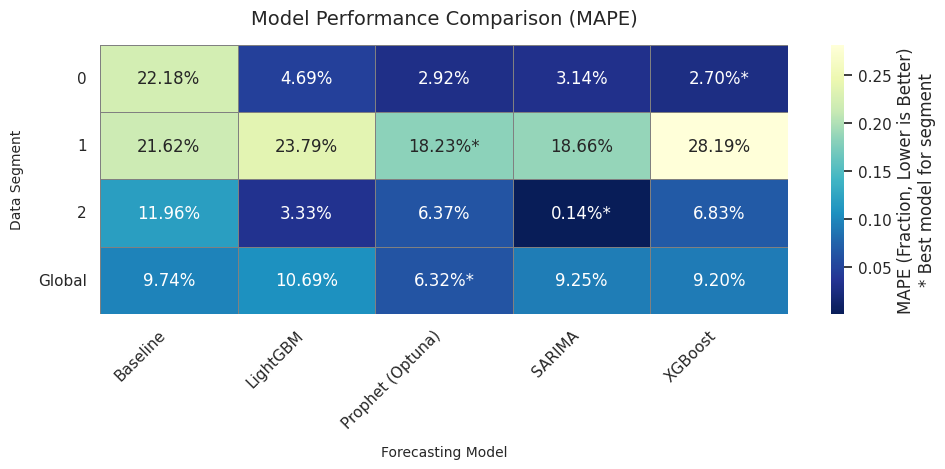

In [88]:

# SAVING DATA FOR STREAMLIT AND GENERATING HEATMAP

print("\n\n" + "=" * 50 + "\nSAVING DATA FOR STREAMLIT\n" + "=" * 50)

# --- Define DATA_PATH and ensure it exists ---
import os
DATA_PATH = '/content/drive/MyDrive/Data for GC/Bike Share' # Original path
try:
    os.makedirs(DATA_PATH, exist_ok=True)
    print(f"Data directory ensured at: {DATA_PATH}")
except OSError as e:
    print(f"Error creating directory {DATA_PATH}: {e}. Please check permissions or path.")

# --- 1. Saving MAPE results from all_model_results_list ---
if not all_model_results_list:
    print("Warning: all_model_results_list is empty. MAPE results not saved.")
else:
    try:
        mape_source_df = pd.DataFrame(all_model_results_list)
        rename_map_mape = {'Model': 'model_type', 'Segment': 'segment_id', 'MAPE': 'mape_fraction'}
        cols_to_rename_mape = {k: v for k, v in rename_map_mape.items() if k in mape_source_df.columns}
        if cols_to_rename_mape:
            mape_source_df.rename(columns=cols_to_rename_mape, inplace=True)

        required_cols_mape = ['model_type', 'segment_id', 'mape_fraction']
        if all(col in mape_source_df.columns for col in required_cols_mape):
            mape_df_to_save = mape_source_df[required_cols_mape].copy()
            mape_df_to_save['segment_id'] = mape_df_to_save['segment_id'].astype(str).str.replace('Cluster ', '', regex=False)
            mape_df_to_save['mape_fraction'] = pd.to_numeric(mape_df_to_save['mape_fraction'], errors='coerce')
            mape_df_to_save.sort_values(['segment_id', 'model_type', 'mape_fraction'], inplace=True)
            mape_df_to_save.drop_duplicates(subset=['segment_id', 'model_type'], keep='first', inplace=True)
            mape_csv_path = os.path.join(DATA_PATH, "mape_results.csv")
            mape_df_to_save.to_csv(mape_csv_path, index=False, encoding='utf-8')
            print(f"MAPE results saved to {mape_csv_path}")
        else:
            print(f"Warning: Necessary columns ({required_cols_mape}) not in DataFrame from all_model_results_list. MAPE not saved. Available: {mape_source_df.columns.tolist()}")
    except Exception as e:
        print(f"Error processing/saving MAPE results: {e}")
        import traceback
        traceback.print_exc()

# --- 2. Defining columns for saving in CSV with forecasts ---
streamlit_export_columns = ['date', 'actual', 'baseline_pred', 'prophet_pred', 'sarima_pred', 'lgbm_pred', 'xgb_pred']

# --- 3. Saving forecast files (forecast_data_segment_*.csv) ---
if not all_segment_dfs:
    print("Warning: all_segment_dfs is empty. No forecast data CSV files generated.")
else:
    for segment_id_str, df_segment_data_orig in all_segment_dfs.items():
        print(f"\n--- Preparing forecast data for Streamlit: Segment '{segment_id_str}' ---")
        if df_segment_data_orig is None or not isinstance(df_segment_data_orig, pd.DataFrame) or df_segment_data_orig.empty:
            print(f"Warning: Data for segment '{segment_id_str}' is None, not DataFrame, or empty. Skipping.")
            continue
        df_segment_data = df_segment_data_orig.copy()
        if not isinstance(df_segment_data.index, pd.DatetimeIndex):
            print(f"Warning: Index for segment '{segment_id_str}' not DatetimeIndex. Attempting conversion.")
            try:
                df_segment_data.index = pd.to_datetime(df_segment_data.index)
            except Exception as e_idx_conv:
                print(f"Error converting index for '{segment_id_str}': {e_idx_conv}. Skipping.")
                continue
        df_segment_data.sort_index(inplace=True)
        df_for_streamlit_export = df_segment_data.reset_index()
        if df_for_streamlit_export.columns[0] != 'date': # Assuming first col is date after reset
            df_for_streamlit_export.rename(columns={df_for_streamlit_export.columns[0]: 'date'}, inplace=True)
        if 'date' not in df_for_streamlit_export.columns:
            print(f"CRITICAL: 'date' column missing for '{segment_id_str}'. Skipping.")
            continue
        try:
            df_for_streamlit_export['date'] = pd.to_datetime(df_for_streamlit_export['date']).dt.strftime('%Y-%m-%d')
        except Exception as e_date_format:
            print(f"Warning: Error formatting 'date' for '{segment_id_str}': {e_date_format}.")

        final_df_to_save = pd.DataFrame()
        for col_export in streamlit_export_columns:
            if col_export in df_for_streamlit_export.columns:
                final_df_to_save[col_export] = df_for_streamlit_export[col_export]
            else:
                # print(f"Note: Column '{col_export}' missing for '{segment_id_str}'. Creating with NaNs.")
                final_df_to_save[col_export] = np.nan
        if 'date' in final_df_to_save.columns:
            final_df_to_save.drop_duplicates(subset=['date'], keep='first', inplace=True)
        safe_segment_id_str = str(segment_id_str).replace('.', '_').replace(' ', '_').replace('/', '_')
        filename = f"forecast_data_segment_{safe_segment_id_str}.csv"
        filepath = os.path.join(DATA_PATH, filename)
        try:
            final_df_to_save.to_csv(filepath, index=False, encoding='utf-8')
            print(f"Streamlit forecast data for '{segment_id_str}' saved to {filepath}")
        except Exception as e_csv_save:
            print(f"Error saving CSV for '{segment_id_str}': {e_csv_save}")

print("\n\n" + "=" * 50 + "\nSTREAMLIT DATA EXPORT COMPLETED\n" + "=" * 50)

# --- 4. Final MAPE summary table and Heatmap (from all_model_results_list) ---
print("\n--- Final MAPE Summary (from all_model_results_list) ---")
print("\n--- DEBUG: Contents of all_model_results_list before DataFrame creation ---")
for item in all_model_results_list:
    print(item)
if not all_model_results_list: print("all_model_results_list is EMPTY")
if not all_model_results_list:
    print("all_model_results_list is empty. No final MAPE summary.")
else:
    try:
        results_df_summary = pd.DataFrame(all_model_results_list)
        if 'MAPE' in results_df_summary.columns and 'mape_fraction' not in results_df_summary.columns:
            results_df_summary.rename(columns={'MAPE': 'mape_fraction'}, inplace=True)
        if 'Model' in results_df_summary.columns and 'model_type' not in results_df_summary.columns:
            results_df_summary.rename(columns={'Model': 'model_type'}, inplace=True)
        if 'Segment' in results_df_summary.columns and 'segment_id' not in results_df_summary.columns:
             results_df_summary.rename(columns={'Segment': 'segment_id'}, inplace=True)

        if 'mape_fraction' not in results_df_summary.columns:
            print("Warning: 'mape_fraction' (or 'MAPE') column not found. Heatmap cannot be generated.")
            results_df_summary = pd.DataFrame()
        else:
            results_df_summary['mape_fraction'] = pd.to_numeric(results_df_summary['mape_fraction'], errors='coerce')

        if 'segment_id' not in results_df_summary.columns:
            print("Warning: 'segment_id' (or 'Segment') column not found. Heatmap cannot be generated.")
            results_df_summary = pd.DataFrame()
        else:
            results_df_summary['segment_id'] = results_df_summary['segment_id'].astype(str).str.replace('Cluster ', '', regex=False)

        if not results_df_summary.empty and \
           all(col in results_df_summary.columns for col in ['model_type', 'segment_id', 'mape_fraction']):
            idx_min_mape = results_df_summary.groupby(['model_type', 'segment_id'])['mape_fraction'].idxmin(skipna=True)
            valid_idx_min_mape = idx_min_mape.dropna()
            if not valid_idx_min_mape.empty:
                best_results_df_summary = results_df_summary.loc[valid_idx_min_mape].copy()
                pivot_mape_summary = best_results_df_summary.pivot_table(
                    index='segment_id', columns='model_type', values='mape_fraction')

                desired_segment_order = ['0', '1', '2', 'Global'] # As per your image
                desired_model_order = ['Baseline', 'LightGBM', 'Prophet (Optuna)', 'SARIMA', 'XGBoost'] # Corrected unique

                current_segments = list(pivot_mape_summary.index)
                ordered_segments = [s for s in desired_segment_order if s in current_segments]
                remaining_segments = sorted([s for s in current_segments if s not in ordered_segments])
                final_segment_order = ordered_segments + remaining_segments

                current_models = list(pivot_mape_summary.columns)
                ordered_models = [m for m in desired_model_order if m in current_models]
                remaining_models = sorted([m for m in current_models if m not in ordered_models])
                final_model_order = ordered_models + remaining_models

                try:
                    pivot_mape_summary = pivot_mape_summary.reindex(index=final_segment_order, columns=final_model_order)
                except Exception as e_reindex:
                    print(f"Warning: Could not reindex pivot table for heatmap: {e_reindex}. Using original order.")

                print("\nMAPE Pivot Table (fractions, ordered):")
                if not pivot_mape_summary.empty: print(pivot_mape_summary.to_string(float_format="%.4f"))
                else: print("Pivot table is empty after filtering.")

                if not pivot_mape_summary.empty:
                    annot_data_summary_percent = pivot_mape_summary.copy()
                    best_model_for_segment_s = pivot_mape_summary.idxmin(axis=1, skipna=True)
                    for seg_s_loop in pivot_mape_summary.index:
                        best_model_s_loop = best_model_for_segment_s.get(seg_s_loop)
                        for model_s_loop in pivot_mape_summary.columns:
                            mape_frac_val_s = pivot_mape_summary.loc[seg_s_loop, model_s_loop]
                            if pd.isna(mape_frac_val_s):
                                annot_data_summary_percent.loc[seg_s_loop, model_s_loop] = "" # Changed N/A to empty for cleaner heatmap if NaN
                            else:
                                text_val_s = f"{mape_frac_val_s:.2%}"
                                if model_s_loop == best_model_s_loop and pd.notna(best_model_s_loop) and pd.notna(mape_frac_val_s):
                                    text_val_s += "*"
                                annot_data_summary_percent.loc[seg_s_loop, model_s_loop] = text_val_s
                    fig_width_s = max(10, len(pivot_mape_summary.columns) * 1.8) # Adjusted sizes
                    fig_height_s = max(5, len(pivot_mape_summary.index) * 0.8)
                    plt.figure(figsize=(fig_width_s, fig_height_s))
                    sns.heatmap(pivot_mape_summary, annot=annot_data_summary_percent, fmt="s", cmap="YlGnBu_r",
                                linewidths=.5, linecolor='grey',
                                cbar_kws={'label': 'MAPE (Fraction, Lower is Better)\n* Best model for segment'})
                    plt.title('Model Performance Comparison (MAPE)', fontsize=14, pad=15)
                    plt.xlabel('Forecasting Model', fontsize=10, labelpad=10)
                    plt.ylabel('Data Segment', fontsize=10, labelpad=10)
                    plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0)
                    plt.tight_layout(pad=1.5)
                    plt.show()
                else:
                    print("Cannot generate heatmap: pivot_mape_summary is empty.")
            else:
                print("DataFrame best_results_df_summary is empty. No pivot table or heatmap.")
        else:
            print("results_df_summary empty or missing key columns. No final MAPE summary.")
    except Exception as e_summary:
        print(f"Error during final MAPE summary: {e_summary}")
        import traceback
        traceback.print_exc()

# 6.Analysis of Results and Conclusions

**Project Goal Recap:** The primary objective was to develop models for forecasting bicycle rental demand for the next 7 days and to test the hypothesis that pre-clustering the data and subsequently training models on each cluster improves prediction accuracy compared to using a single global model.

**Analysis of Model Performance (MAPE):**

The final MAPE results, summarized in the pivot table and heatmap, provide clear insights into model performance across different data segments (clusters and global) and for various forecasting algorithms.

*(Insert your MAPE Pivot Table image here if displaying directly in Colab, or refer to the generated `mape_performance_heatmap.png`)*

**Key Findings:**

1.  **Validation of Clustering Hypothesis:**
    *   The results **strongly support the hypothesis** that a cluster-based modeling approach can yield significantly better forecasting accuracy than a single global model.
    *   **Cluster 0:** The best model (XGBoost at 2.70% MAPE) substantially outperformed the best global model (Prophet (Optuna) at 6.32% MAPE on global data).
    *   **Cluster 2:** This segment saw the most dramatic improvement, with SARIMA achieving an exceptionally low MAPE of 0.14%, far surpassing any global model's performance. This indicates a very distinct and predictable pattern within this cluster that benefits immensely from a specialized model.
    *   **Global vs. Cluster Performance:** While the "Global" segment has Prophet (Optuna) as its best model with 6.32% MAPE, individual cluster models like XGBoost for Cluster 0 (2.70%) and SARIMA for Cluster 2 (0.14%) demonstrate that tailoring models to specific cluster characteristics leads to superior local predictions.
    *   **Cluster 1:** Prophet (Optuna) was also the best for this cluster (18.23% MAPE). While this error is higher than the global Prophet, it's important to note that the global MAPE is an average; the global model's performance specifically on data resembling Cluster 1 might have been different. This cluster might represent more volatile or harder-to-predict demand.

2.  **No Single Best Model:** Different algorithms excelled on different data segments.
    *   **XGBoost** was optimal for Cluster 0.
    *   **Prophet (Optuna)** was optimal for Cluster 1 and the Global dataset.
    *   **SARIMA** was outstanding for Cluster 2.
    *   This highlights the importance of experimenting with a diverse set of models.

3.  **Effectiveness of Advanced Models:** All statistical and machine learning models (LightGBM, Prophet, SARIMA, XGBoost) significantly outperformed the Baseline model across all segments, indicating complex patterns in the data that simpler methods cannot capture.

**Conclusion:**

The project successfully demonstrated that **segmenting the bike-sharing demand data through clustering (PCA + K-Means) and then applying tailored forecasting models to each cluster generally leads to more accurate 7-day demand predictions** compared to relying on a single global model.

The distinct MAPE values achieved by specialized models on individual clusters, particularly the remarkable performance of SARIMA on Cluster 2 and XGBoost on Cluster 0, underscore the value of identifying and modeling underlying heterogeneous demand patterns. This approach allows for more precise forecasts by adapting the modeling technique to the specific characteristics of each identified data segment.

**Recommendations:**

*   For an operational forecasting system, an ensemble or a selection of the best-performing models per cluster should be implemented.
*   Further investigation into Cluster 1 could be beneficial, perhaps exploring different features or alternative modeling approaches, given its relatively higher MAPE.
*   Continuous monitoring of model performance and periodic retraining on new data, along with potential re-evaluation of cluster assignments, is recommended to maintain forecast accuracy over time.